# Initialize

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
import piecewise_regression
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import plot_tree
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RationalQuadratic, Matern
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import shap
import warnings          #ignore warnings
warnings.filterwarnings("ignore")
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

In [ ]:
def plot_data(data_list, plot_stress_strain=True, cutoff_load_thickness=1, cutoff_load_displacement=2):
    """
    Function to plot either stress-strain or load-displacement graphs, and calculates thickness for both cases.

    Parameters:
    - data_list: List of datasets (Pandas DataFrames) to be plotted.
    - plot_stress_strain: Boolean indicating whether to plot stress-strain (True) or load-displacement (False).
    - cutoff_load_thickness: Load cutoff value for determining thickness.
    - cutoff_load_displacement: Load cutoff value for filtering data in the plot.

    Returns:
    - Plots the desired graph based on the provided parameters.
    """

    # Calculate thickness for both cases
    thickness_list = []
    for i in range(len(data_list)):
        # Convert 'S:LVDT (in)' to 'S:LVDT (um)'
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000
        # Determine thickness by subtracting 0 by 'S:LVDT (um)' at cutoff load
        thickness = -data_list[i]['S:LVDT (um)'][data_list[i]['Ch:Load (N)'] > cutoff_load_thickness].iloc[0]
        thickness_list.append(thickness)

    if plot_stress_strain:
        # Stress-Strain plot preparation
        plt.figure(figsize=(8, 6))
        for i, data in enumerate(data_list):
            # Create stress and strain columns
            data['stress (bar)'] = data['Ch:Load (N)'] / 19.635 * 10
            data['strain'] = data['S:LVDT (um)'] / thickness_list[i]
            # Filter data above cutoff load
            data = data[data['Ch:Load (N)'] > cutoff_load_displacement]
            # Shift strain data
            data['strain'] = data['strain'] - data['strain'].iloc[0]
            data_name = f"{namestr(data_list[i], globals())} ({thickness_list[i]:.2f} um)"
            plt.plot(data['strain'], data['stress (bar)'], label=data_name)

        plt.title('Stress-Strain Plot')
        plt.xlabel('Strain')
        plt.ylabel('Stress (bar)')
        plt.legend(loc='upper left')
        plt.show()

    else:
        # Load-Displacement plot preparation
        plt.figure(figsize=(8, 6))
        for i in range(len(data_list)):
            # Filter data above cutoff load
            data = data_list[i][data_list[i]['Ch:Load (N)'] > cutoff_load_displacement]
            # Shift displacement data
            data['S:LVDT (um)'] = data['S:LVDT (um)'] - data['S:LVDT (um)'].iloc[0]
            data_name = f"{namestr(data_list[i], globals())} ({thickness_list[i]:.2f} um)"
            plt.plot(data['S:LVDT (um)'], data['Ch:Load (N)'], label=data_name)

        plt.title('Load-Displacement Plot')
        plt.xlabel('Displacement (um)')
        plt.ylabel('Load (N)')
        plt.legend(loc='upper left')
        plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

cv_list = []
# Function to process and plot the data as described
def plot_data_with_statistics(data_list, thickness_info = False, thickness_list = None, plot_stress_strain=True, cutoff_load_thickness=1, cutoff_load_displacement=2):
    # Calculate thickness for both cases
    #retrieves thickness information
    if thickness_info:
        thickness_list = thickness_list
        for i in range(len(data_list)):
            # Convert 'S:LVDT (in)' to 'S:LVDT (um)'
            data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000
    else:
        thickness_list = []
        for i in range(len(data_list)):
            # Determine thickness by subtracting 0 by 'S:LVDT (um)' at cutoff load
            # Convert 'S:LVDT (in)' to 'S:LVDT (um)'
            data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000
            thickness = -data_list[i]['S:LVDT (um)'][data_list[i]['Ch:Load (N)'] > cutoff_load_thickness].iloc[0]
            thickness_list.append(thickness)
    if plot_stress_strain:
        # Stress-Strain plot preparation
        plt.figure(figsize=(8, 6))
        stress_data = []
        strain_data = []

        for i, data in enumerate(data_list):
            # Create stress and strain columns
            data['stress (bar)'] = data['Ch:Load (N)'] / 19.635 * 10
            data['strain'] = data['S:LVDT (um)'] / thickness_list[i]
            # Filter data above cutoff load
            data = data[data['Ch:Load (N)'] > cutoff_load_displacement]
            # Shift strain data
            data['strain'] = data['strain'] - data['strain'].iloc[0]
            data_name = f"{namestr(data_list[i], globals())} ({thickness_list[i]:.2f} um)"
            plt.plot(data['strain'], data['stress (bar)'], alpha=0.5, label=data_name)
            stress_data.append(data['stress (bar)'].values)
            strain_data.append(data['strain'].values)

        # Calculate average and standard deviation
        min_length = min([len(stress) for stress in stress_data])
        stress_data = [stress[:min_length] for stress in stress_data]
        strain_data = [strain[:min_length] for strain in strain_data]

        avg_stress = np.mean(stress_data, axis=0)
        std_stress = np.std(stress_data, axis=0)
        avg_strain = np.mean(strain_data, axis=0)

        # Calculate Coefficient of Variation (CV)
        overall_avg_stress = np.mean(avg_stress)
        overall_std_stress = np.mean(std_stress)
        cv = overall_std_stress / overall_avg_stress

        # Plot average curve with standard deviation shading
        plt.plot(avg_strain, avg_stress, color='black', label='Average Stress-Strain')
        plt.fill_between(avg_strain, avg_stress - std_stress, avg_stress + std_stress, color='grey', alpha=0.3, label='Standard Deviation')
        plt.title('Stress-Strain Plot')
        plt.xlabel('Strain')
        plt.ylabel('Stress (bar)')
        plt.legend(loc='upper left')
        plt.show()

        cv_list.append(cv)
        print(f'Coefficient of Variation (CV): {cv:.2f}')
        return cv

    else:
        # Load-Displacement plot preparation
        plt.figure(figsize=(8, 6))
        displacement_data = []
        load_data = []

        for i in range(len(data_list)):
            # Filter data above cutoff load
            data = data_list[i][data_list[i]['Ch:Load (N)'] > cutoff_load_displacement]
            # Shift displacement data
            data['S:LVDT (um)'] = data['S:LVDT (um)'] - data['S:LVDT (um)'].iloc[0]
            data_name = f"{namestr(data_list[i], globals())} ({thickness_list[i]:.2f} um)"
            plt.plot(data['S:LVDT (um)'], data['Ch:Load (N)'], alpha=0.5, label=data_name)
            displacement_data.append(data['S:LVDT (um)'].values)
            load_data.append(data['Ch:Load (N)'].values)

        # Calculate average and standard deviation
        min_length = min([len(load) for load in load_data])
        displacement_data = [displacement[:min_length] for displacement in displacement_data]
        load_data = [load[:min_length] for load in load_data]

        avg_displacement = np.mean(displacement_data, axis=0)
        avg_load = np.mean(load_data, axis=0)
        std_load = np.std(load_data, axis=0)

        # Calculate Coefficient of Variation (CV)
        overall_avg_load = np.mean(avg_load)
        overall_std_load = np.mean(std_load)
        cv = overall_std_load / overall_avg_load


        # Plot average curve with standard deviation shading
        plt.plot(avg_displacement, avg_load, color='black', label='Average Load-Displacement')
        plt.fill_between(avg_displacement, avg_load - std_load, avg_load + std_load, color='grey', alpha=0.3, label='Standard Deviation')

        plt.title('Load-Displacement Plot')
        plt.xlabel('Displacement (um)')
        plt.ylabel('Load (N)')
        plt.legend(loc='upper left')
        plt.show()
        
        cv_list.append(cv)
        return cv

# Call the function to process and plot the data
#plot_data_with_statistics(data_list, plot_stress_strain=True,cutoff_load_thickness=1, cutoff_load_displacement=2)




In [ ]:
def plot_data_with_statistics(data_list, thickness_info=False, thickness_list=None, plot_stress_strain=True, cutoff_load_thickness=1, cutoff_load_displacement=2):
    # Calculate thickness for both cases
    if thickness_info:
        thickness_list = thickness_list
        for i in range(len(data_list)):
            # Convert 'S:LVDT (in)' to 'S:LVDT (um)'
            data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000
    else:
        thickness_list = []
        for i in range(len(data_list)):
            # Determine thickness by subtracting 0 by 'S:LVDT (um)' at cutoff load
            data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000
            thickness = -data_list[i]['S:LVDT (um)'][data_list[i]['Ch:Load (N)'] > cutoff_load_thickness].iloc[0]
            thickness_list.append(thickness)

    if plot_stress_strain:
        # Stress-Strain plot preparation
        plt.figure(figsize=(8, 6))
        stress_data = []
        strain_data = []

        for i, data in enumerate(data_list):
            # Create stress and strain columns
            data['stress (bar)'] = data['Ch:Load (N)'] / 19.635 * 10
            data['strain'] = data['S:LVDT (um)'] / thickness_list[i]
            # Filter data above cutoff load
            data = data[data['Ch:Load (N)'] > cutoff_load_displacement]
            # Shift strain data
            data['strain'] = data['strain'] - data['strain'].iloc[0]
            data_name = f"{namestr(data_list[i], globals())} ({thickness_list[i]:.2f} um)"
            plt.plot(data['strain'], data['stress (bar)'], alpha=0.5, label=data_name)
            stress_data.append(data['stress (bar)'].values)
            strain_data.append(data['strain'].values)

        # Interpolate strain data to align all datasets to a common stress range
        min_length = min([len(stress) for stress in stress_data])
        common_stress = np.linspace(np.min([np.min(s) for s in stress_data]), 
                                    np.max([np.max(s) for s in stress_data]), 
                                    min_length)
        aligned_strain_data = [np.interp(common_stress, stress[:min_length], strain[:min_length]) 
                               for stress, strain in zip(stress_data, strain_data)]

        # Calculate average, min, and max strain for each stress level
        avg_strain = np.mean(aligned_strain_data, axis=0)
        min_strain = np.min(aligned_strain_data, axis=0)
        max_strain = np.max(aligned_strain_data, axis=0)

        # Plot average stress-strain curve and the range
        plt.plot(avg_strain, common_stress, color='black', label='Average Stress-Strain')
        plt.fill_betweenx(common_stress, min_strain, max_strain, color='grey', alpha=0.3, label='Strain Range')
        plt.title('Stress-Strain Plot')
        plt.xlabel('Strain')
        plt.ylabel('Stress (bar)')
        plt.legend(loc='upper left', fontsize=10)
        plt.show()

        # Return key results
        return {
            'avg_strain': avg_strain,
            'common_stress': common_stress,
            'min_strain': min_strain,
            'max_strain': max_strain,
            'stress_data': stress_data,
            'strain_data': strain_data
        }

    else:
        # Load-Displacement plot preparation
        plt.figure(figsize=(8, 6))
        displacement_data = []
        load_data = []

        for i in range(len(data_list)):
            # Filter data above cutoff load
            data = data_list[i][data_list[i]['Ch:Load (N)'] > cutoff_load_displacement]
            # Shift displacement data
            data['S:LVDT (um)'] = data['S:LVDT (um)'] - data['S:LVDT (um)'].iloc[0]
            data_name = f"{namestr(data_list[i], globals())} ({thickness_list[i]:.2f} um)"
            plt.plot(data['S:LVDT (um)'], data['Ch:Load (N)'], alpha=0.5, label=data_name)
            displacement_data.append(data['S:LVDT (um)'].values)
            load_data.append(data['Ch:Load (N)'].values)


        min_length = min([len(load) for load in load_data])
        common_load = np.linspace(np.min([np.min(l) for l in load_data]), 
                                  np.max([np.max(l) for l in load_data]), 
                                  min_length)
        aligned_displacement_data = [np.interp(common_load, load[:min_length], displacement[:min_length]) 
                                     for load, displacement in zip(load_data, displacement_data)]

        avg_displacement = np.mean(aligned_displacement_data, axis=0)
        min_displacement = np.min(aligned_displacement_data, axis=0)
        max_displacement = np.max(aligned_displacement_data, axis=0)

        plt.plot(avg_displacement, common_load, color='black', label='Average Load-Displacement')
        plt.fill_betweenx(common_load, min_displacement, max_displacement, color='grey', alpha=0.3, label='Displacement Range')
        plt.title('Load-Displacement Plot')
        plt.xlabel('Displacement (um)')
        plt.ylabel('Load (N)')
        plt.legend(loc='upper left', fontsize=10)
        plt.show()

        # Return key results
        return {
            'avg_displacement': avg_displacement,
            'common_load': common_load,
            'min_displacement': min_displacement,
            'max_displacement': max_displacement,
            'displacement_data': displacement_data,
            'load_data': load_data
        }


In [ ]:
#KNOWLEDGE EXTRACTION PIPELINE CODE
'''
use interpretData and extract function for each batch of trials
use propertyDataFile once all batches are interpreted to create a useable csv file
'''

#IMPORTED PYTHON PACKAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
import piecewise_regression
from sklearn.linear_model import LinearRegression
import warnings          #ignore warnings
warnings.filterwarnings("ignore")

def namestr(obj, namespace):          #read the file name of data
    return [name for name in namespace if namespace[name] is obj][0]

#EXTRACT KNOWLEDGE OF A DATA BATCH
def interpretData(data_list, thickness_info = True, thickness_list = None, concentration_info = True, concentration = None, creep_info = True, cutoff_load_thickness=1, cutoff_load_displacement=2):
    '''
    Returns mechanical properties of a data batch as a list

    Parameters
    -----
    data_list : list including all the trials read as dataframes
    thickness_info : is True if thickness_list provided and accurate
    thickness_list : if needed, provide manually calculated thickness information
    concentration_true : is True if concentration provided and accurate
    conentration : if needed, provide manually measured concentration

    Returns
    -----
    list - [concentration, heating/no heating, mechanical property dictionaries for each trial]

    see Draft1DerivativeKnowledgeExtraction_AimeeTai.ipynb for example
    '''
    for i in range(len(data_list)):
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000

    #retrieves thickness information
    thickness = []
    if thickness_info:
        thickness = thickness_list
    else:
        for i in range(len(data_list)):
            thickness.append(-data_list[i]['S:LVDT (um)'][data_list[i]['Ch:Load (N)'] > cutoff_load_thickness].iloc[0])

    #add concentration and heating to returned list
    mechanicalProperties = []
    
    #set up stress strain curve
    for i in range(len(data_list)): 
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000     #convert in to um
        data_list[i]['stress (bar)'] = data_list[i]['Ch:Load (N)'] / 19.635 *10      #create stress column which is load / area, the area is 19.635 mm^2
        data_list[i]['strain'] = data_list[i]['S:LVDT (um)'] / thickness[i]      #create strain column which is displacement / thickness, the thickness is shown above
    
    # Calculate average standard deviation for all data points
    all_stress_data = []
    for i in range(len(data_list)):
        data = data_list[i][data_list[i]['Ch:Load (N)'] > cutoff_load_displacement]
        data['strain'] = data['strain'] - data['strain'].iloc[0]     #shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data = data.reset_index(drop=True)
        all_stress_data.append(data['stress (bar)'].values)

    min_length = min([len(stress) for stress in all_stress_data])
    truncated_stress_data = [stress[:min_length] for stress in all_stress_data]
    avg_standard_deviation = np.mean([np.std(stress) for stress in truncated_stress_data])
    print(f"Average Standard Deviation: {avg_standard_deviation}")

    #set up for loop for each trial in the batch
    for i in range(len(data_list)):
        plt.figure(figsize=(8, 6))
        #retrieve data names
        data_name = namestr(data_list[i], globals())
        if concentration_info == True:
            conc = concentration
        else:
            conc = data_name.split('_')[2]
            if len(conc) > 2:
                conc = conc[:-2]
        Auto = data_name.split('_')[0]
        if Auto == 'Auto':
            Auto = True
        else: Auto = False
        heating = data_name.split('_')[1]
        if heating == 'noheating' or heating == 'Noheating':
            heating = False
        else: heating = True
        batch = data_name.split('_')[3]
        sample = data_name.split('_')[4]
        trial = data_name.split('_')[5]

        #adjust data for interpretation
        data = data_list[i][data_list[i]['Ch:Load (N)'] > cutoff_load_displacement]      
        data['strain'] = data['strain'] - data['strain'].iloc[0]     #shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data = data.reset_index(drop=True)     #resets indexing
        fracture_index = data['stress (bar)'].idxmax()
        if creep_info:
            fracture_index = data[data['Set Point ()'] > 1].index[0] #find index of fracture point
        # find the index when column Set Point () is greater than 1
        fracture_index += 1
        data_original = data.copy()
        data = data.iloc[:fracture_index]     #remove datapoints after fracture point

        #plot original data
        plt.scatter(data_original['strain'], data_original['stress (bar)'], color='lightgrey', label=data_name)

        #generate spline model
        gam = LinearGAM(s(0))
        gam.fit(data[['strain']], data['stress (bar)'])
        predictions = gam.predict(data[['strain']])
        # replace values in predictions that are greater than the predictions[-1] with predictions[-1] but make a copy of the predictions for the plot
        predictions_for_plot = predictions.copy()
        predictions_for_plot[predictions_for_plot > predictions[-1]] = predictions[-1]
        #print(gam.summary())
        plt.plot(data['strain'], predictions_for_plot, color='black',label='Spline Model')

        creep_strain = None
        if creep_info:
            #calculate creep
            #find the data range where set point is greater than 1
            creep_start = data_original[data_original['Set Point ()'] > 1]['strain'].iloc[0]
            creep_end = data_original[data_original['Set Point ()'] > 1]['strain'].iloc[-1]
            # plot a horizontal line between the two points
            plt.hlines(predictions[-1], creep_start, creep_end, color='red', label='Creep Region')
            creep_strain = creep_end - creep_start

        #calculate derivative of spline model
        data['1st derivative'] = np.gradient(predictions, data['strain'])
        data['2nd derivative'] = np.gradient(data['1st derivative'], data['strain'])

        #identify the elastic region
        data['2nd derivative'].idxmin()     #found the minimum of the 2nd derivative         
        breakpoint1 = data['strain'][data['2nd derivative'].idxmin()]
        #yieldStrength = data['stress (bar)'][data['2nd derivative'].idxmin()]
        #plt.scatter(breakpoint1, yieldStrength, color='black', label='Change Point 1')
        elasticRegion = data[data['strain'] <= breakpoint1]

        #calculate the elastic modulus and yield strength
        modelElastic = LinearRegression()
        modelElastic.fit(elasticRegion['strain'].values.reshape(-1, 1), elasticRegion['stress (bar)'].values)
        elasticModulus = modelElastic.coef_[0]
        yieldStrength = modelElastic.predict(np.array([[breakpoint1]]))
        predElastic = modelElastic.predict(elasticRegion[['strain']])

        #identify the plateau & densification region
        regions = data[data['strain'] >= breakpoint1]
        try:
            pw_fit = piecewise_regression.Fit(list(regions['strain']), list(regions['stress (bar)']), n_breakpoints=4)
        except Exception as e:
            print(f"Piecewise regression fitting failed: {e}")
            continue
        pw_results = pw_fit.get_results()
        eval = None
        if pw_results['estimates'] != None:
            breakpoint2 = pw_results['estimates']['breakpoint1']['estimate']
            breakpoint3 = pw_results['estimates']['breakpoint4']['estimate']
            plateauRegion = regions[regions['strain'] <= breakpoint2]
            densificationRegion = regions[regions['strain'] >= breakpoint3]

            #calculate the plateau region slope
            modelPlateau = LinearRegression()
            modelPlateau.fit(plateauRegion['strain'].values.reshape(-1, 1), plateauRegion['stress (bar)'].values)
            slopePlateau = modelPlateau.coef_[0]
            interceptPlateau = modelPlateau.intercept_

            #calculate the densification region slope
            modelDensification = LinearRegression()
            modelDensification.fit(densificationRegion['strain'].values.reshape(-1, 1), densificationRegion['stress (bar)'].values)
            slopeDensification = modelDensification.coef_[0]
            interceptDensification = modelDensification.intercept_

            #calculate the changepoint between the plateau and densification region
            changepoint = (interceptDensification - interceptPlateau) / (slopePlateau - slopeDensification)
            xPlateau = data[(breakpoint1 <= data['strain']) & (data['strain'] <= changepoint)]
            xDensification = data[changepoint <= data['strain']]
            if len(xDensification) > 0 and len(xPlateau) > 0:
                predPlateau = modelPlateau.predict(xPlateau[['strain']])
                predDensification = modelDensification.predict(xDensification[['strain']])
                # replace values in predDensification that are greater than the predictions[-1] with predictions[-1]
                predDensification[predDensification > predictions[-1]] = predictions[-1]

                #evaluate fit
                plateauModel = LinearGAM(s(0))
                plateauModel.fit(xPlateau[['strain']], xPlateau['stress (bar)'])
                plateauSpline = plateauModel.predict(xPlateau[['strain']])

                correlation_coefficient = np.corrcoef(plateauSpline, predPlateau)[0, 1]

                #ensure the linear models align with each other
                rangeStart = yieldStrength - 3     #arbitrary range
                rangeEnd = yieldStrength + 3
                if rangeStart <= modelPlateau.predict(breakpoint1.reshape(1, -1)) <= rangeEnd and slopePlateau <= elasticModulus*1.25 and correlation_coefficient <= 0.98:
                    eval = True
                else:
                    eval = False
                    
                #dictionary of each trial's mechanical properties
                dict = {'name': data_name,
                        'Auto': Auto,
                        'Heating': heating,
                        'Concentration': conc,
                        'Batch': batch,
                        'Sample': sample,
                        'Trial': trial,
                        "Thickness": thickness[i],
                        "Elastic Modulus":elasticModulus, 
                        "Yield Strength":yieldStrength[0], 
                        "Changepoint":changepoint, 
                        "Slope Plateau":slopePlateau, 
                        "Slope Densification":slopeDensification,
                        "Creep Strain":creep_strain,
                        "Good Fit":eval,
                        "Average Standard Deviation":avg_standard_deviation}
                mechanicalProperties.append(dict)

                #plotted linear models of each region
                plt.plot(elasticRegion['strain'], predElastic, color='blue',  label='Elastic Region', linewidth=3)
                plt.plot(xPlateau['strain'], predPlateau, color='orange', label="Plateau Region", linewidth=3)
                plt.plot(xDensification['strain'], predDensification, color='green', label="Densification Region", linewidth=3)


        
        plt.title(data_name, fontsize=20)
        plt.xlabel('Strain', fontsize=20)
        plt.ylabel('Stress (bar)', fontsize=20)
        plt.legend(loc='upper left', fontsize=15)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.show()

        print("Good Fit:", eval)

    return mechanicalProperties

#ADD DATA TO A GLOABL LIST
def extract(materialProperties):  
    '''
    adds data from the interpretData function list to global lists

    Parameters
    -----
    materialProperties : the returned list of the interpretData function

    Returns
    -----
    none

    NEEDS EMPTY GLOBAL LISTS IN CODE BEFORE USE
    '''
    for i in range(len(materialProperties)):
        name.append(materialProperties[i]['name'])
        auto.append(materialProperties[i]['Auto'])
        concentration.append(materialProperties[i]['Concentration'])
        batch.append(materialProperties[i]['Batch'])
        sample.append(materialProperties[i]['Sample'])
        thickness.append(materialProperties[i]['Thickness'])
        conc.append(materialProperties[0])
        heating.append(materialProperties[i]['Heating'])
        trial.append(materialProperties[i]['Trial'])
            
        elasticModulus.append(materialProperties[i]['Elastic Modulus'])
        yieldStrength.append(materialProperties[i]['Yield Strength'])
        creepStrain.append(materialProperties[i]['Creep Strain'])
        slopePlateau.append(materialProperties[i]['Slope Plateau'])
        slopeDensification.append(materialProperties[i]['Slope Densification'])
        changepoint.append(materialProperties[i]['Changepoint'])
        fit.append(materialProperties[i]["Good Fit"])
        avg_standard_deviation.append(materialProperties[i]["Average Standard Deviation"])

#necessary global lists
name = []
auto = []
heating = []
concentration = []
batch = []
sample = []
trial = []
thickness = []
elasticModulus = []
yieldStrength = []
creepStrain = []
slopePlateau = []
slopeDensification = []
changepoint = []
fit = []
avg_standard_deviation = []
conc = []

#CREATE PROPERTY DATA CSV FILE
def propertyDataFile(filename_old, filename_new):
    '''
    creates property_data.csv from global lists of the material properties from the extract and interpretData function
    '''
    propertyData = {'Name':name,
                    'Auto':auto,
                    'Heating':heating,
                    'Concentration':concentration,
                    'Batch':batch,
                    'Sample':sample,
                    'Trial':trial,
                    'Thickness':thickness,
                    'Elastic Modulus':elasticModulus,
                    'Yield Strength':yieldStrength,
                    'Creep Strain':creepStrain,
                    'Plateau Slope':slopePlateau,
                    'Densification Slope':slopeDensification,
                    'Changepoint':changepoint,
                    'Fit':fit,
                    'Average Standard Deviation':avg_standard_deviation}

    propertyData = pd.DataFrame(propertyData)
    df_old = pd.read_csv(filename_old)
    propertyData = pd.concat([df_old, propertyData], ignore_index=True)
    #propertyData = propertyData.sort_values('Concentration')
    propertyData.to_csv(filename_new, index=False)

In [86]:
#KNOWLEDGE EXTRACTION PIPELINE CODE ------ For plot, can delete later
'''
use interpretData and extract function for each batch of trials
use propertyDataFile once all batches are interpreted to create a useable csv file
'''

#IMPORTED PYTHON PACKAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
import piecewise_regression
from sklearn.linear_model import LinearRegression
import warnings          #ignore warnings
warnings.filterwarnings("ignore")

def namestr(obj, namespace):          #read the file name of data
    return [name for name in namespace if namespace[name] is obj][0]

#EXTRACT KNOWLEDGE OF A DATA BATCH
def interpretData(data_list, thickness_info = True, thickness_list = None, concentration_info = True, concentration = None, creep_info = True, cutoff_load_thickness=1, cutoff_load_displacement=2):
    '''
    Returns mechanical properties of a data batch as a list

    Parameters
    -----
    data_list : list including all the trials read as dataframes
    thickness_info : is True if thickness_list provided and accurate
    thickness_list : if needed, provide manually calculated thickness information
    concentration_true : is True if concentration provided and accurate
    conentration : if needed, provide manually measured concentration

    Returns
    -----
    list - [concentration, heating/no heating, mechanical property dictionaries for each trial]

    see Draft1DerivativeKnowledgeExtraction_AimeeTai.ipynb for example
    '''
    for i in range(len(data_list)):
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000

    #retrieves thickness information
    thickness = []
    if thickness_info:
        thickness = thickness_list
    else:
        for i in range(len(data_list)):
            thickness.append(-data_list[i]['S:LVDT (um)'][data_list[i]['Ch:Load (N)'] > cutoff_load_thickness].iloc[0])

    #add concentration and heating to returned list
    mechanicalProperties = []
    
    #set up stress strain curve
    for i in range(len(data_list)): 
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000     #convert in to um
        data_list[i]['stress (bar)'] = data_list[i]['Ch:Load (N)'] / 19.635 *10      #create stress column which is load / area, the area is 19.635 mm^2
        data_list[i]['strain'] = data_list[i]['S:LVDT (um)'] / thickness[i]      #create strain column which is displacement / thickness, the thickness is shown above
    
    # Calculate average standard deviation for all data points
    all_stress_data = []
    for i in range(len(data_list)):
        data = data_list[i][data_list[i]['Ch:Load (N)'] > cutoff_load_displacement]
        data['strain'] = data['strain'] - data['strain'].iloc[0]     #shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data = data.reset_index(drop=True)
        all_stress_data.append(data['stress (bar)'].values)

    min_length = min([len(stress) for stress in all_stress_data])
    truncated_stress_data = [stress[:min_length] for stress in all_stress_data]
    avg_standard_deviation = np.mean([np.std(stress) for stress in truncated_stress_data])
    print(f"Average Standard Deviation: {avg_standard_deviation}")

    #set up for loop for each trial in the batch
    for i in range(len(data_list)):
        plt.figure(figsize=(8, 5.5))
        #retrieve data names
        data_name = namestr(data_list[i], globals())
        if concentration_info == True:
            conc = concentration
        else:
            conc = data_name.split('_')[2]
            if len(conc) > 2:
                conc = conc[:-2]
        Auto = data_name.split('_')[0]
        if Auto == 'Auto':
            Auto = True
        else: Auto = False
        heating = data_name.split('_')[1]
        if heating == 'noheating' or heating == 'Noheating':
            heating = False
        else: heating = True
        batch = data_name.split('_')[3]
        sample = data_name.split('_')[4]
        trial = data_name.split('_')[5]

        #adjust data for interpretation
        data = data_list[i][data_list[i]['Ch:Load (N)'] > cutoff_load_displacement]      
        data['strain'] = data['strain'] - data['strain'].iloc[0]     #shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data = data.reset_index(drop=True)     #resets indexing
        fracture_index = data['stress (bar)'].idxmax()
        if creep_info:
            fracture_index = data[data['Set Point ()'] > 1].index[0] #find index of fracture point
        # find the index when column Set Point () is greater than 1
        fracture_index += 1
        data_original = data.copy()
        data = data.iloc[:fracture_index]     #remove datapoints after fracture point

        #generate spline model
        gam = LinearGAM(s(0))
        gam.fit(data[['strain']], data['stress (bar)'])
        predictions = gam.predict(data[['strain']])
        # replace values in predictions that are greater than the predictions[-1] with predictions[-1] but make a copy of the predictions for the plot
        predictions_for_plot = predictions.copy()
        predictions_for_plot[predictions_for_plot > predictions[-1]] = predictions[-1]
        #print(gam.summary())
        plt.plot(data['strain'], predictions_for_plot, color='black',label='Spline Model')

        creep_strain = None
        if creep_info:
            #calculate creep
            #find the data range where set point is greater than 1
            creep_start = data_original[data_original['Set Point ()'] > 1]['strain'].iloc[0]
            creep_end = data_original[data_original['Set Point ()'] > 1]['strain'].iloc[-1]
            # plot a horizontal line between the two points
            plt.hlines(predictions[-1], creep_start, creep_end, color='red', label='Creep Region', linewidth=3)
            creep_strain = creep_end - creep_start

        if creep_info:
            # find the index corresponding to the END of creep (last point with Set Point() > 1)
            creep_end_index = data_original[data_original['Set Point ()'] > 1].index[-1] + 1
        else:
            creep_end_index = fracture_index

        # Plot the raw data up to the end of creep region
        plt.scatter(data_original.iloc[:creep_end_index]['strain'], 
                    data_original.iloc[:creep_end_index]['stress (bar)'], 
                    color='lightgrey', label='Raw Data')


        #calculate derivative of spline model
        data['1st derivative'] = np.gradient(predictions, data['strain'])
        data['2nd derivative'] = np.gradient(data['1st derivative'], data['strain'])


        #identify the elastic region
        # normal way
        data['2nd derivative'].idxmin()     #found the minimum of the 2nd derivative 
        #breakpoint1 = data['strain'][data['2nd derivative'].idxmin()]
        # Restrict search to strain <= 0.5
        subset = data[data['strain'] <= 0.5]
        breakpoint1 = subset['strain'][subset['2nd derivative'].idxmin()]


        #yieldStrength = data['stress (bar)'][data['2nd derivative'].idxmin()]
        #plt.scatter(breakpoint1, yieldStrength, color='black', label='Change Point 1')
        elasticRegion = data[data['strain'] <= breakpoint1]

        #calculate the elastic modulus and yield strength
        modelElastic = LinearRegression()
        modelElastic.fit(elasticRegion['strain'].values.reshape(-1, 1), elasticRegion['stress (bar)'].values)
        elasticModulus = modelElastic.coef_[0]
        yieldStrength = modelElastic.predict(np.array([[breakpoint1]]))
        predElastic = modelElastic.predict(elasticRegion[['strain']])

        #identify the plateau & densification region
        regions = data[data['strain'] >= breakpoint1]
        try:
            pw_fit = piecewise_regression.Fit(list(regions['strain']), list(regions['stress (bar)']), n_breakpoints=4)
        except Exception as e:
            print(f"Piecewise regression fitting failed: {e}")
            continue
        pw_results = pw_fit.get_results()
        eval = None
        if pw_results['estimates'] != None:
            breakpoint2 = pw_results['estimates']['breakpoint1']['estimate']
            breakpoint3 = pw_results['estimates']['breakpoint4']['estimate']
            plateauRegion = regions[regions['strain'] <= breakpoint2]
            densificationRegion = regions[regions['strain'] >= breakpoint3]

            #calculate the plateau region slope
            modelPlateau = LinearRegression()
            modelPlateau.fit(plateauRegion['strain'].values.reshape(-1, 1), plateauRegion['stress (bar)'].values)
            slopePlateau = modelPlateau.coef_[0]
            interceptPlateau = modelPlateau.intercept_

            #calculate the densification region slope
            modelDensification = LinearRegression()
            modelDensification.fit(densificationRegion['strain'].values.reshape(-1, 1), densificationRegion['stress (bar)'].values)
            slopeDensification = modelDensification.coef_[0]
            interceptDensification = modelDensification.intercept_

            #calculate the changepoint between the plateau and densification region
            changepoint = (interceptDensification - interceptPlateau) / (slopePlateau - slopeDensification)
            xPlateau = data[(breakpoint1 <= data['strain']) & (data['strain'] <= changepoint)]
            xDensification = data[changepoint <= data['strain']]
            if len(xDensification) > 0 and len(xPlateau) > 0:
                predPlateau = modelPlateau.predict(xPlateau[['strain']])
                predDensification = modelDensification.predict(xDensification[['strain']])
                # replace values in predDensification that are greater than the predictions[-1] with predictions[-1]
                predDensification[predDensification > predictions[-1]] = predictions[-1]

                #evaluate fit
                plateauModel = LinearGAM(s(0))
                plateauModel.fit(xPlateau[['strain']], xPlateau['stress (bar)'])
                plateauSpline = plateauModel.predict(xPlateau[['strain']])

                correlation_coefficient = np.corrcoef(plateauSpline, predPlateau)[0, 1]

                #ensure the linear models align with each other
                rangeStart = yieldStrength - 3     #arbitrary range
                rangeEnd = yieldStrength + 3
                if rangeStart <= modelPlateau.predict(breakpoint1.reshape(1, -1)) <= rangeEnd and slopePlateau <= elasticModulus*1.25 and correlation_coefficient <= 0.98:
                    eval = True
                else:
                    eval = False
                    
                #dictionary of each trial's mechanical properties
                dict = {'name': data_name,
                        'Auto': Auto,
                        'Heating': heating,
                        'Concentration': conc,
                        'Batch': batch,
                        'Sample': sample,
                        'Trial': trial,
                        "Thickness": thickness[i],
                        "Elastic Modulus":elasticModulus, 
                        "Yield Strength":yieldStrength[0], 
                        "Changepoint":changepoint, 
                        "Slope Plateau":slopePlateau, 
                        "Slope Densification":slopeDensification,
                        "Creep Strain":creep_strain,
                        "Good Fit":eval,
                        "Average Standard Deviation":avg_standard_deviation}
                mechanicalProperties.append(dict)

                #plotted linear models of each region
                plt.plot(elasticRegion['strain'], predElastic, color='blue',  label='Elastic Region', linewidth=3)
                plt.plot(xPlateau['strain'], predPlateau, color='orange', label="Plateau Region", linewidth=3)
                plt.plot(xDensification['strain'], predDensification, color='green', label="Densification Region", linewidth=3)
                print(dict)


        
        #plt.title('Stress-Strain Curve Segmentation', fontsize=20)
        plt.xlabel('Strain', fontsize=20)
        plt.ylabel('Stress (bar)', fontsize=20)
        #plt.legend(loc='upper left', fontsize=15)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.show()

        print("Good Fit:", eval)

    return mechanicalProperties

#ADD DATA TO A GLOABL LIST
def extract(materialProperties):  
    '''
    adds data from the interpretData function list to global lists

    Parameters
    -----
    materialProperties : the returned list of the interpretData function

    Returns
    -----
    none

    NEEDS EMPTY GLOBAL LISTS IN CODE BEFORE USE
    '''
    for i in range(len(materialProperties)):
        name.append(materialProperties[i]['name'])
        auto.append(materialProperties[i]['Auto'])
        concentration.append(materialProperties[i]['Concentration'])
        batch.append(materialProperties[i]['Batch'])
        sample.append(materialProperties[i]['Sample'])
        thickness.append(materialProperties[i]['Thickness'])
        conc.append(materialProperties[0])
        heating.append(materialProperties[i]['Heating'])
        trial.append(materialProperties[i]['Trial'])
            
        elasticModulus.append(materialProperties[i]['Elastic Modulus'])
        yieldStrength.append(materialProperties[i]['Yield Strength'])
        creepStrain.append(materialProperties[i]['Creep Strain'])
        slopePlateau.append(materialProperties[i]['Slope Plateau'])
        slopeDensification.append(materialProperties[i]['Slope Densification'])
        changepoint.append(materialProperties[i]['Changepoint'])
        fit.append(materialProperties[i]["Good Fit"])
        avg_standard_deviation.append(materialProperties[i]["Average Standard Deviation"])

#necessary global lists
name = []
auto = []
heating = []
concentration = []
batch = []
sample = []
trial = []
thickness = []
elasticModulus = []
yieldStrength = []
creepStrain = []
slopePlateau = []
slopeDensification = []
changepoint = []
fit = []
avg_standard_deviation = []
conc = []

#CREATE PROPERTY DATA CSV FILE
def propertyDataFile(filename_old, filename_new):
    '''
    creates property_data.csv from global lists of the material properties from the extract and interpretData function
    '''
    propertyData = {'Name':name,
                    'Auto':auto,
                    'Heating':heating,
                    'Concentration':concentration,
                    'Batch':batch,
                    'Sample':sample,
                    'Trial':trial,
                    'Thickness':thickness,
                    'Elastic Modulus':elasticModulus,
                    'Yield Strength':yieldStrength,
                    'Creep Strain':creepStrain,
                    'Plateau Slope':slopePlateau,
                    'Densification Slope':slopeDensification,
                    'Changepoint':changepoint,
                    'Fit':fit,
                    'Average Standard Deviation':avg_standard_deviation}

    propertyData = pd.DataFrame(propertyData)
    df_old = pd.read_csv(filename_old)
    propertyData = pd.concat([df_old, propertyData], ignore_index=True)
    #propertyData = propertyData.sort_values('Concentration')
    propertyData.to_csv(filename_new, index=False)

Average Standard Deviation: 54.50701011299058
{'name': 'Auto_Noheating_17_18_2_1', 'Auto': True, 'Heating': False, 'Concentration': 17, 'Batch': '18', 'Sample': '2', 'Trial': '1', 'Thickness': 118.92280000000001, 'Elastic Modulus': 166.12396680320865, 'Yield Strength': 12.980813463469868, 'Changepoint': 0.5650140304705992, 'Slope Plateau': 73.68376993379013, 'Slope Densification': 975.7263145630998, 'Creep Strain': 0.03780435711234509, 'Good Fit': True, 'Average Standard Deviation': 54.50701011299058}


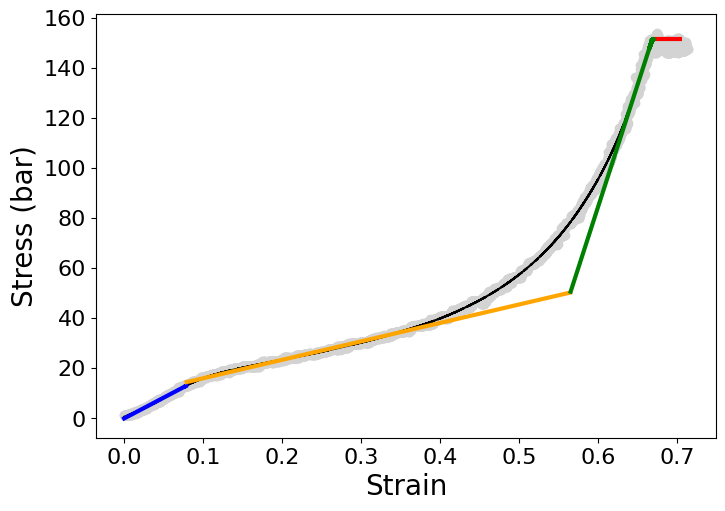

Good Fit: True
{'name': 'Auto_Noheating_17_18_2_2', 'Auto': True, 'Heating': False, 'Concentration': 17, 'Batch': '18', 'Sample': '2', 'Trial': '2', 'Thickness': 126.69520000000001, 'Elastic Modulus': 164.21879229267978, 'Yield Strength': 12.22017605152951, 'Changepoint': 0.5603045253198001, 'Slope Plateau': 77.98414485069847, 'Slope Densification': 922.1343040637688, 'Creep Strain': 0.041499599037690516, 'Good Fit': True, 'Average Standard Deviation': 54.50701011299058}


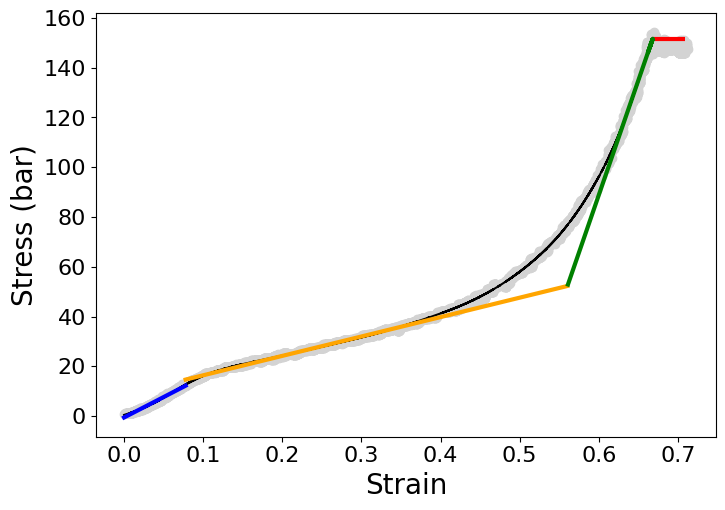

Good Fit: True
{'name': 'Auto_Noheating_17_18_2_3', 'Auto': True, 'Heating': False, 'Concentration': 17, 'Batch': '18', 'Sample': '2', 'Trial': '3', 'Thickness': 119.04979999999999, 'Elastic Modulus': 178.4533227901871, 'Yield Strength': 13.565656150758349, 'Changepoint': 0.5495262394585512, 'Slope Plateau': 76.66583643629106, 'Slope Densification': 932.3053714178229, 'Creep Strain': 0.039470876893535234, 'Good Fit': True, 'Average Standard Deviation': 54.50701011299058}


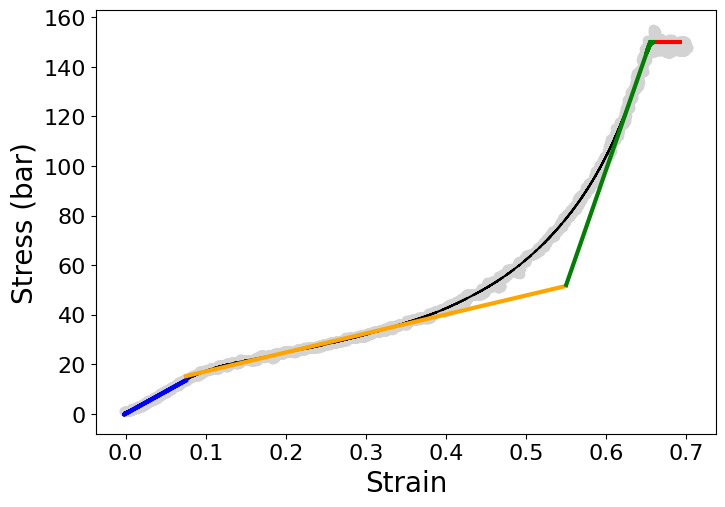

Good Fit: True
{'name': 'Auto_Noheating_17_18_2_4', 'Auto': True, 'Heating': False, 'Concentration': 17, 'Batch': '18', 'Sample': '2', 'Trial': '4', 'Thickness': 119.1514, 'Elastic Modulus': 175.22269308776063, 'Yield Strength': 13.350252700237197, 'Changepoint': 0.5479435996914611, 'Slope Plateau': 77.79294075835979, 'Slope Densification': 960.1806122833966, 'Creep Strain': 0.04028991686207639, 'Good Fit': True, 'Average Standard Deviation': 54.50701011299058}


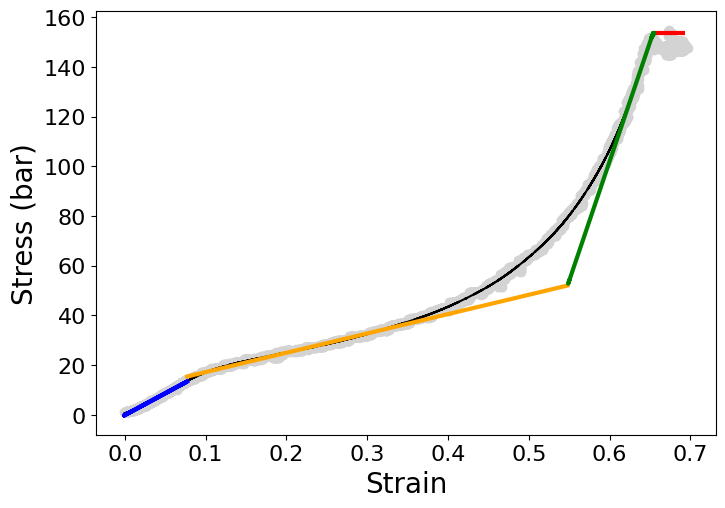

Good Fit: True


In [87]:
Auto_Noheating_17_18_2_1 = pd.read_csv('Data/compression 18/AutoNoHeating-17-18-reverse-2-1_09092024_172831.csv')
Auto_Noheating_17_18_2_2 = pd.read_csv('Data/compression 18/AutoNoHeating-17-18-reverse-2-2_09092024_173210.csv')
Auto_Noheating_17_18_2_3 = pd.read_csv('Data/compression 18/AutoNoHeating-17-18-reverse-2-3_09092024_173627.csv')
Auto_Noheating_17_18_2_4 = pd.read_csv('Data/compression 18/AutoNoHeating-17-18-reverse-2-4_09092024_174029.csv')
data_list_17_18_2 = [Auto_Noheating_17_18_2_1, Auto_Noheating_17_18_2_2, Auto_Noheating_17_18_2_3, Auto_Noheating_17_18_2_4]
interp_17_18_2 = interpretData(data_list_17_18_2, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)


Average Standard Deviation: 48.171184862613146
{'name': 'Auto_Noheating_17_30_1_1', 'Auto': True, 'Heating': False, 'Concentration': 17, 'Batch': '30', 'Sample': '1', 'Trial': '1', 'Thickness': 116.30659999999999, 'Elastic Modulus': 265.4631260689349, 'Yield Strength': 40.580255613191326, 'Changepoint': 0.563309233347015, 'Slope Plateau': 98.94215277403208, 'Slope Densification': 778.1881195562624, 'Creep Strain': 0.05088447259226914, 'Good Fit': False, 'Average Standard Deviation': 48.171184862613146}


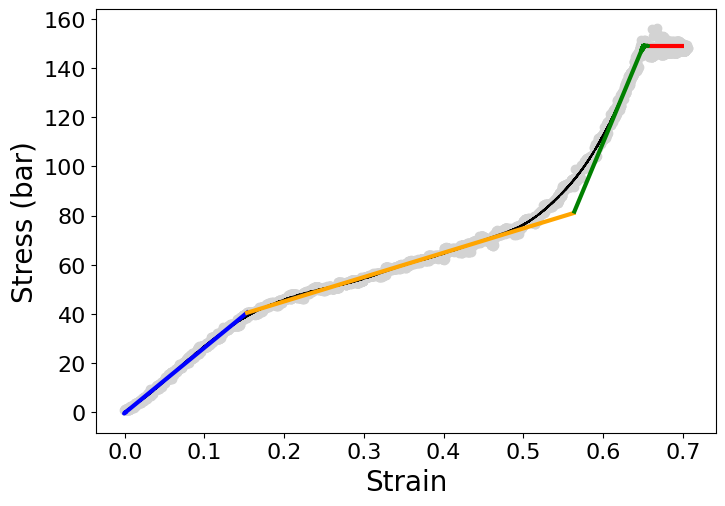

Good Fit: False
{'name': 'Auto_Noheating_17_30_1_2', 'Auto': True, 'Heating': False, 'Concentration': 17, 'Batch': '30', 'Sample': '1', 'Trial': '2', 'Thickness': 116.20499999999998, 'Elastic Modulus': 265.9123229822717, 'Yield Strength': 40.73566755770753, 'Changepoint': 0.551699247205762, 'Slope Plateau': 87.95358837844222, 'Slope Densification': 873.8450204097651, 'Creep Strain': 0.04699453551912569, 'Good Fit': True, 'Average Standard Deviation': 48.171184862613146}


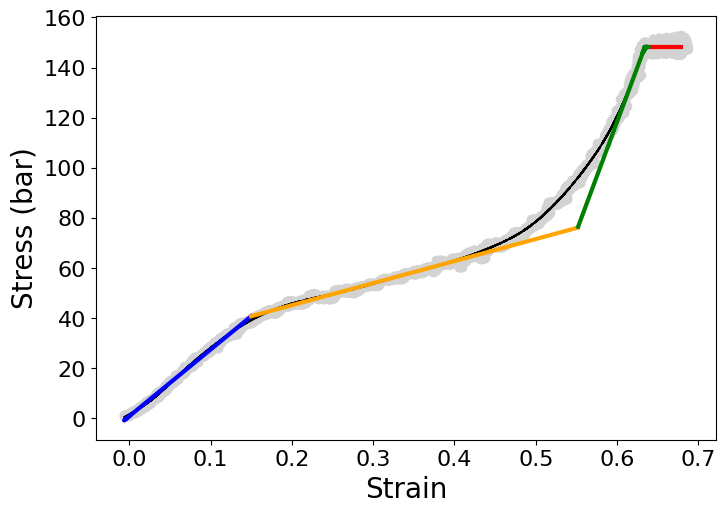

Good Fit: True
{'name': 'Auto_Noheating_17_30_1_3', 'Auto': True, 'Heating': False, 'Concentration': 17, 'Batch': '30', 'Sample': '1', 'Trial': '3', 'Thickness': 116.40820000000001, 'Elastic Modulus': 274.0612437903509, 'Yield Strength': 41.38651944763576, 'Changepoint': 0.5884077191603898, 'Slope Plateau': 143.62449287137193, 'Slope Densification': 911.2950127004707, 'Creep Strain': 0.03382064150120012, 'Good Fit': True, 'Average Standard Deviation': 48.171184862613146}


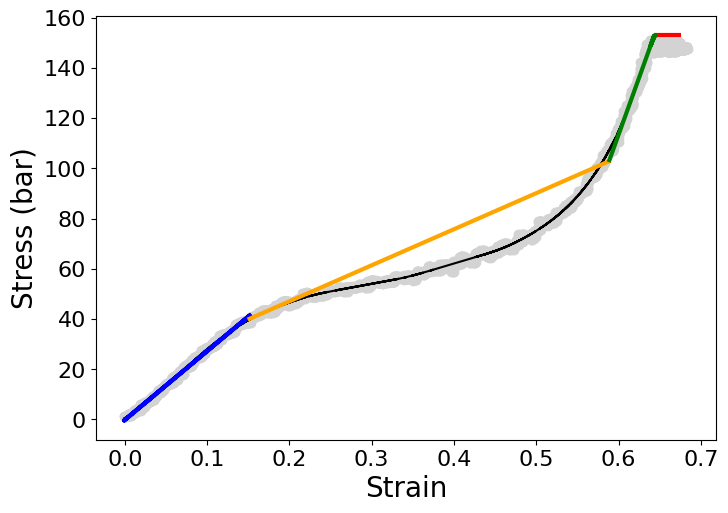

Good Fit: True
{'name': 'Auto_Noheating_17_30_1_4', 'Auto': True, 'Heating': False, 'Concentration': 17, 'Batch': '30', 'Sample': '1', 'Trial': '4', 'Thickness': 118.92280000000001, 'Elastic Modulus': 283.45932548504925, 'Yield Strength': 40.955395208338004, 'Changepoint': 0.5644074680736523, 'Slope Plateau': 137.3869908868503, 'Slope Densification': 921.1726559076776, 'Creep Strain': 0.035882101665954735, 'Good Fit': True, 'Average Standard Deviation': 48.171184862613146}


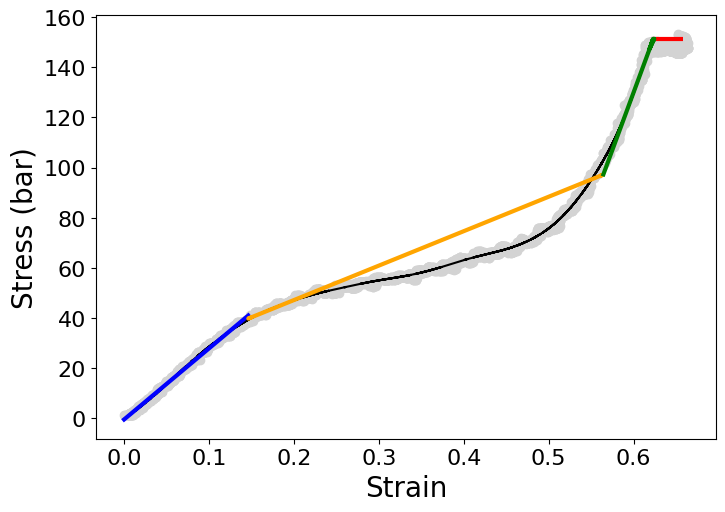

Good Fit: True


In [47]:
Auto_Noheating_17_30_1_1 = pd.read_csv('Data/compression 30/AutoNoHeating-17-30-reverse-1-1_10242024_162253.csv')
Auto_Noheating_17_30_1_2 = pd.read_csv('Data/compression 30/AutoNoHeating-17-30-reverse-1-2_10242024_162600.csv')
Auto_Noheating_17_30_1_3 = pd.read_csv('Data/compression 30/AutoNoHeating-17-30-reverse-1-3_10242024_162919.csv')
Auto_Noheating_17_30_1_4 = pd.read_csv('Data/compression 30/AutoNoHeating-17-30-reverse-1-4_10242024_163228.csv')   
data_list_17_30_1 = [Auto_Noheating_17_30_1_1, Auto_Noheating_17_30_1_2, Auto_Noheating_17_30_1_3, Auto_Noheating_17_30_1_4]
interp_17_30_1 = interpretData(data_list_17_30_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Average Standard Deviation: 53.155665944968725
{'name': 'Auto_Noheating_17_28_1_1', 'Auto': True, 'Heating': False, 'Concentration': 17, 'Batch': '28', 'Sample': '1', 'Trial': '1', 'Thickness': 134.59459999999999, 'Elastic Modulus': 288.4851720730942, 'Yield Strength': 21.49330185788186, 'Changepoint': 0.5586570423089784, 'Slope Plateau': 51.20695144636171, 'Slope Densification': 1041.9442271677194, 'Creep Strain': 0.07227778826193632, 'Good Fit': False, 'Average Standard Deviation': 53.155665944968725}


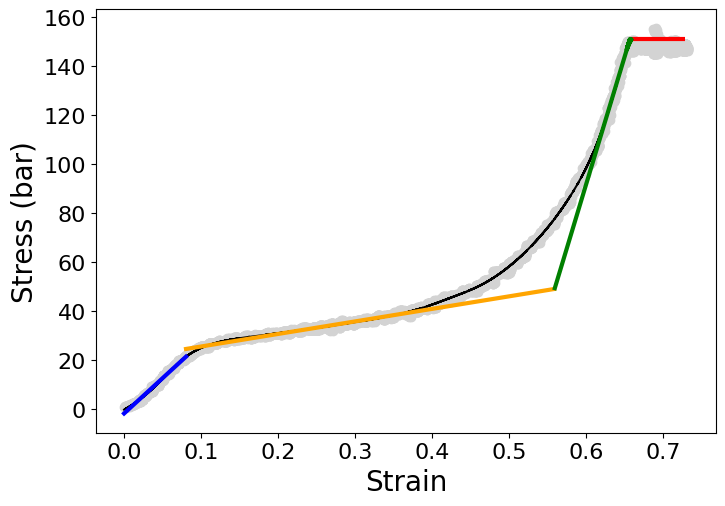

Good Fit: False
{'name': 'Auto_Noheating_17_28_1_2', 'Auto': True, 'Heating': False, 'Concentration': 17, 'Batch': '28', 'Sample': '1', 'Trial': '2', 'Thickness': 139.6238, 'Elastic Modulus': 233.8771965293189, 'Yield Strength': 23.95296215346059, 'Changepoint': 0.5604365658531758, 'Slope Plateau': 51.19160779927699, 'Slope Densification': 1054.35171975425, 'Creep Strain': 0.06112424959068585, 'Good Fit': True, 'Average Standard Deviation': 53.155665944968725}


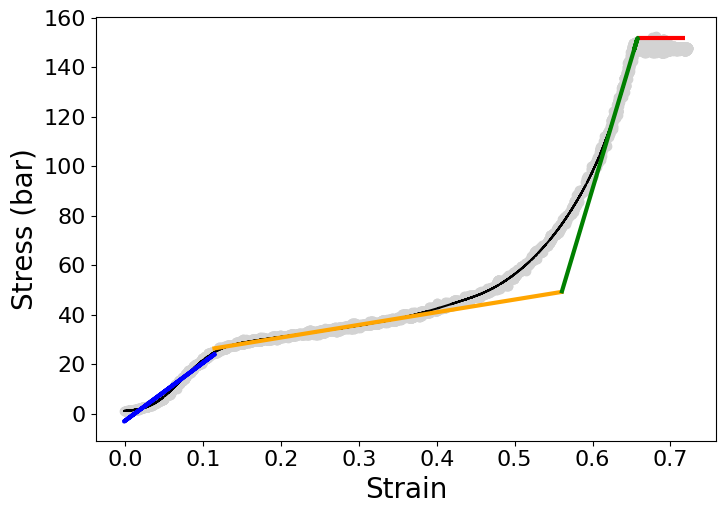

Good Fit: True
{'name': 'Auto_Noheating_17_28_1_3', 'Auto': True, 'Heating': False, 'Concentration': 17, 'Batch': '28', 'Sample': '1', 'Trial': '3', 'Thickness': 132.61339999999998, 'Elastic Modulus': 303.6984768676264, 'Yield Strength': 21.84400421153188, 'Changepoint': 0.5609201754233196, 'Slope Plateau': 52.527104033156846, 'Slope Densification': 1033.8571322822904, 'Creep Strain': 0.06531315839877416, 'Good Fit': False, 'Average Standard Deviation': 53.155665944968725}


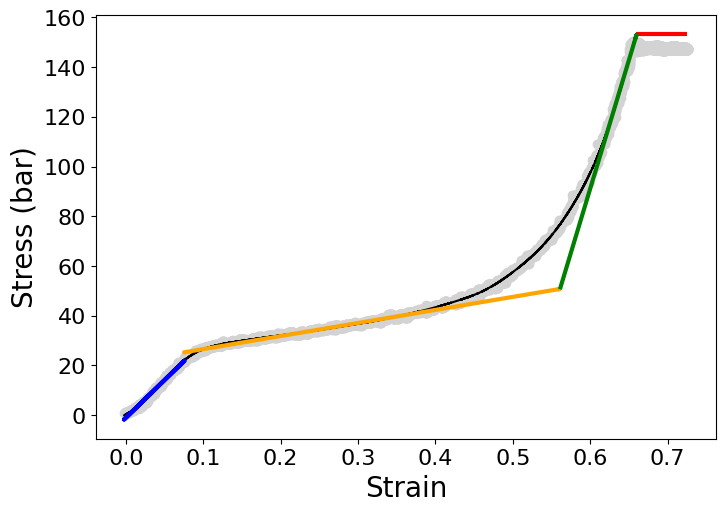

Good Fit: False
{'name': 'Auto_Noheating_17_28_1_4', 'Auto': True, 'Heating': False, 'Concentration': 17, 'Batch': '28', 'Sample': '1', 'Trial': '4', 'Thickness': 132.41019999999997, 'Elastic Modulus': 317.7853590354547, 'Yield Strength': 22.902609784578612, 'Changepoint': 0.5635450532979746, 'Slope Plateau': 51.012273221045255, 'Slope Densification': 1024.7589832417916, 'Creep Strain': 0.06618070209092641, 'Good Fit': True, 'Average Standard Deviation': 53.155665944968725}


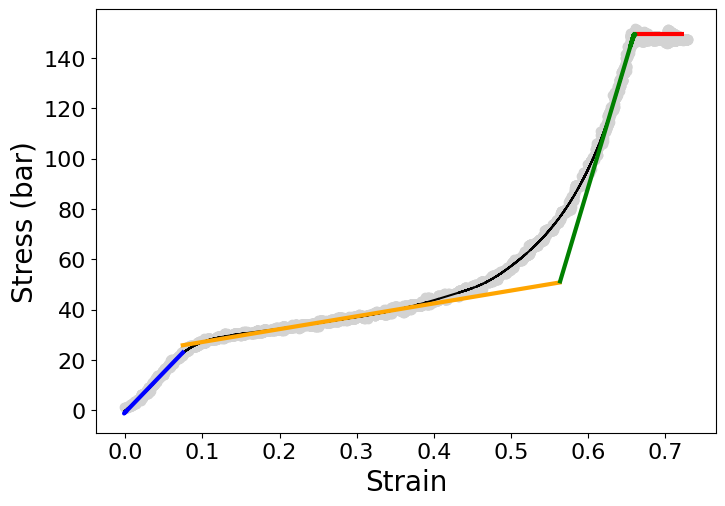

Good Fit: True
{'name': 'Auto_Noheating_17_28_1_34up', 'Auto': True, 'Heating': False, 'Concentration': 17, 'Batch': '28', 'Sample': '1', 'Trial': '34up', 'Thickness': 136.2456, 'Elastic Modulus': 337.90784635067104, 'Yield Strength': 25.599611070449882, 'Changepoint': 0.5576405429023077, 'Slope Plateau': 50.20988635764835, 'Slope Densification': 1070.0966721631867, 'Creep Strain': 0.06431767337807615, 'Good Fit': True, 'Average Standard Deviation': 53.155665944968725}


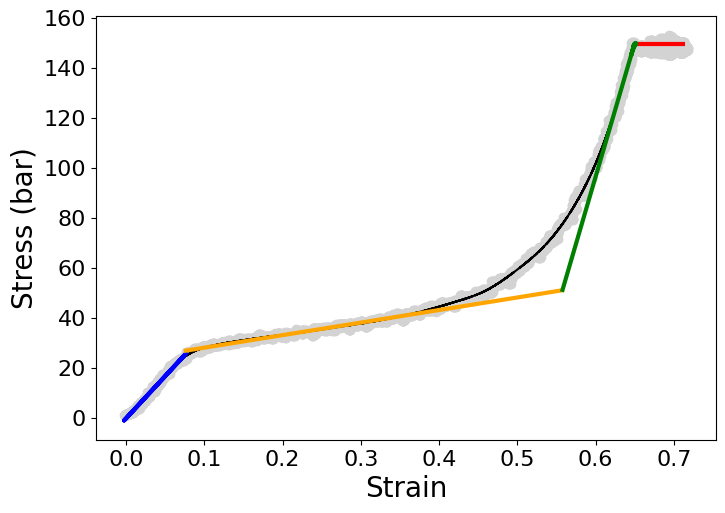

Good Fit: True


In [46]:
Auto_Noheating_17_28_1_1 = pd.read_csv('Data/compression 28/AutoNoHeating-17-28-reverse-1-1_10222024_181954.csv') 
Auto_Noheating_17_28_1_2 = pd.read_csv('Data/compression 28/AutoNoHeating-17-28-reverse-1-2_10222024_182335.csv')
Auto_Noheating_17_28_1_3 = pd.read_csv('Data/compression 28/AutoNoHeating-17-28-reverse-1-3_10222024_182710.csv')
Auto_Noheating_17_28_1_4 = pd.read_csv('Data/compression 28/AutoNoHeating-17-28-reverse-1-4_10222024_183045.csv')
Auto_Noheating_17_28_1_34up = pd.read_csv('Data/compression 28/AutoNoHeating-17-28-reverse-1-34up_10222024_183601.csv')

data_list_17_28_1 = [Auto_Noheating_17_28_1_1, Auto_Noheating_17_28_1_2, Auto_Noheating_17_28_1_3, Auto_Noheating_17_28_1_4, Auto_Noheating_17_28_1_34up]
interp_17_28_1 = interpretData(data_list_17_28_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Average Standard Deviation: 48.995544018800395
{'name': 'Auto_noheating_15wt_3_1_1', 'Auto': True, 'Heating': False, 'Concentration': 14.43, 'Batch': '3', 'Sample': '1', 'Trial': '1', 'Thickness': 103, 'Elastic Modulus': 137.1742254430821, 'Yield Strength': 14.35762948609895, 'Changepoint': 0.5815482888884524, 'Slope Plateau': 61.66109273841788, 'Slope Densification': 768.8732091637054, 'Creep Strain': None, 'Good Fit': True, 'Average Standard Deviation': 48.995544018800395}


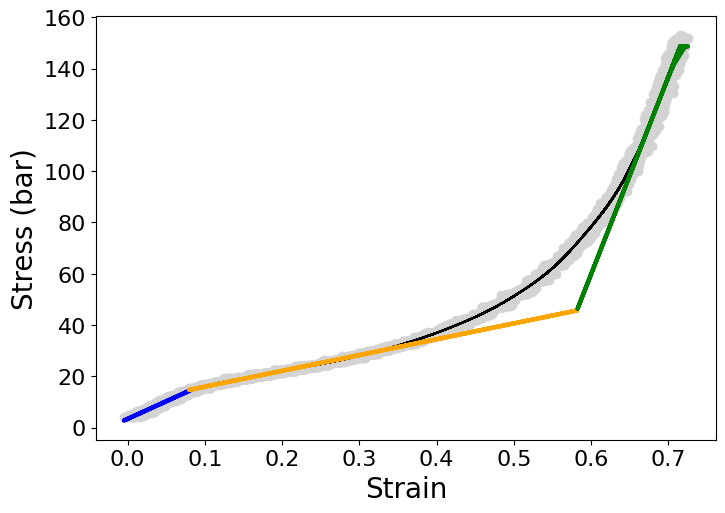

Good Fit: True
{'name': 'Auto_noheating_15wt_3_1_2', 'Auto': True, 'Heating': False, 'Concentration': 14.43, 'Batch': '3', 'Sample': '1', 'Trial': '2', 'Thickness': 105, 'Elastic Modulus': 144.70785292212773, 'Yield Strength': 13.496668573151062, 'Changepoint': 0.5721078918535099, 'Slope Plateau': 65.13426711091577, 'Slope Densification': 781.1927048160976, 'Creep Strain': None, 'Good Fit': True, 'Average Standard Deviation': 48.995544018800395}


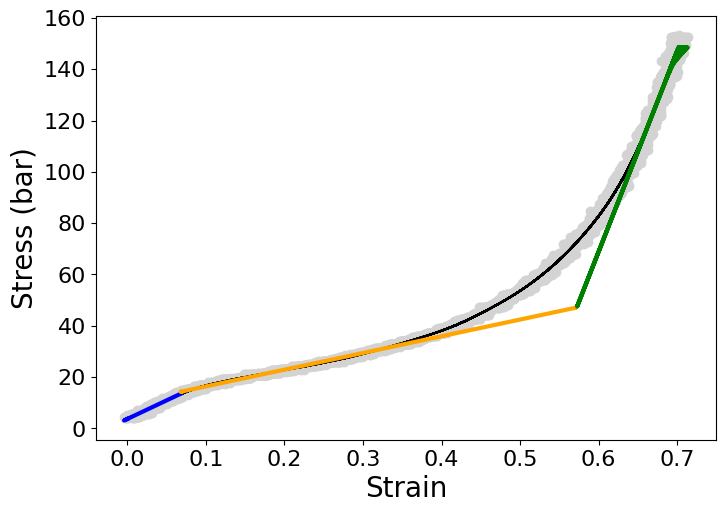

Good Fit: True
{'name': 'Auto_noheating_15wt_3_1_3', 'Auto': True, 'Heating': False, 'Concentration': 14.43, 'Batch': '3', 'Sample': '1', 'Trial': '3', 'Thickness': 105, 'Elastic Modulus': 143.42255201668945, 'Yield Strength': 16.75489649404102, 'Changepoint': 0.5730907338575618, 'Slope Plateau': 62.25931327086893, 'Slope Densification': 765.9510812792925, 'Creep Strain': None, 'Good Fit': True, 'Average Standard Deviation': 48.995544018800395}


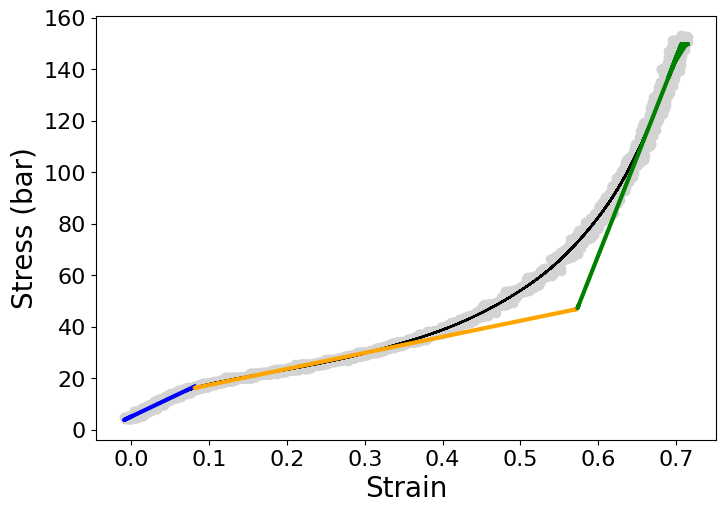

Good Fit: True
{'name': 'Auto_noheating_15wt_3_1_4', 'Auto': True, 'Heating': False, 'Concentration': 14.43, 'Batch': '3', 'Sample': '1', 'Trial': '4', 'Thickness': 105, 'Elastic Modulus': 144.16945252955784, 'Yield Strength': 15.666268157185858, 'Changepoint': 0.5913181952337918, 'Slope Plateau': 62.179815851971114, 'Slope Densification': 757.0368059262718, 'Creep Strain': None, 'Good Fit': True, 'Average Standard Deviation': 48.995544018800395}


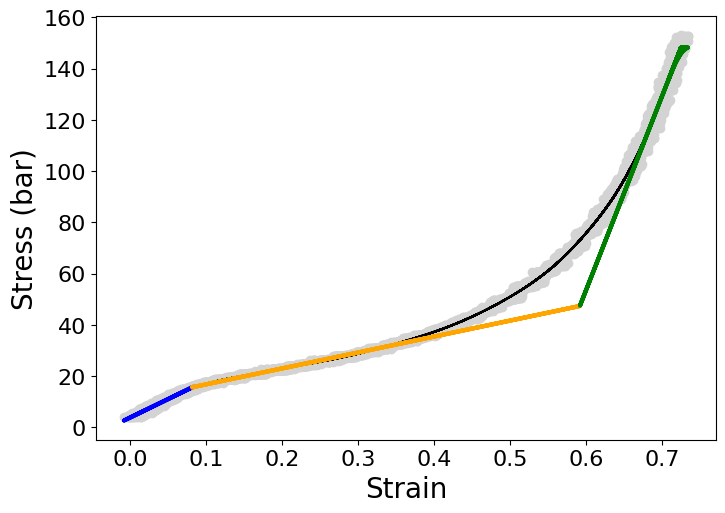

Good Fit: True


In [45]:
Auto_noheating_15wt_3_1_1 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-15-3-1-240212_02122024_175519.csv')
Auto_noheating_15wt_3_1_2 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-15-3-2-240212_02122024_175755.csv')
Auto_noheating_15wt_3_1_3 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-15-3-3-240212_02122024_180046.csv')
Auto_noheating_15wt_3_1_4 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-15-3-4-240212_02122024_180316.csv')
data_list_15_3 = [Auto_noheating_15wt_3_1_1, Auto_noheating_15wt_3_1_2, Auto_noheating_15wt_3_1_3, Auto_noheating_15wt_3_1_4]
thickness_15_3 = [103,105,105,105]
interp_15_3 = interpretData(data_list_15_3, thickness_info = True, thickness_list = thickness_15_3, concentration_info = True, creep_info=False, concentration = 14.43, cutoff_load_thickness=8, cutoff_load_displacement=8)


# Testing

In [ ]:
# TO TEST
Auto_noheating_10wt_3_1_1 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-10-3-1-240212_02122024_160514.csv')
Auto_noheating_10wt_3_1_2 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-10-3-2-240212_02122024_160815.csv')
Auto_noheating_10wt_3_1_3 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-10-3-3-240212_02122024_161038.csv')
Auto_noheating_10wt_3_1_4 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-10-3-4-240212_02122024_161307.csv')
data_list_10_3 = [Auto_noheating_10wt_3_1_1, Auto_noheating_10wt_3_1_2, Auto_noheating_10wt_3_1_3, Auto_noheating_10wt_3_1_4]
thickness_10_3 = [109,113,107,106]
interp_10_3 = interpretData(data_list_10_3, thickness_info = True, thickness_list = thickness_10_3, concentration_info = True, creep_info=False, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_noheating_12wt_3_1_1 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-12-3-1-240212_02122024_161808.csv')
Auto_noheating_12wt_3_1_2 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-12-3-2-240212_02122024_162105.csv')
Auto_noheating_12wt_3_1_3 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-12-3-3-240212_02122024_162358.csv')
Auto_noheating_12wt_3_1_4 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-12-3-4-240212_02122024_162658.csv')
data_list_12_3 = [Auto_noheating_12wt_3_1_1, Auto_noheating_12wt_3_1_2, Auto_noheating_12wt_3_1_3, Auto_noheating_12wt_3_1_4]
thickness_12_3 = [107,110,112,112]
interp_12_3 = interpretData(data_list_12_3, thickness_info = True, thickness_list = thickness_12_3, concentration_info = True, creep_info=False, concentration = 11.63, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Heating_12_24_1_1 = pd.read_csv('Data/compression 24/AutoHeating-12-24-reverse-1-1_09202024_164919.csv')
Auto_Heating_12_24_1_2 = pd.read_csv('Data/compression 24/AutoHeating-12-24-reverse-1-2_09202024_165247.csv')
Auto_Heating_12_24_1_3 = pd.read_csv('Data/compression 24/AutoHeating-12-24-reverse-1-3_09202024_165556.csv')
Auto_Heating_12_24_1_4 = pd.read_csv('Data/compression 24/AutoHeating-12-24-reverse-1-4_09202024_165903.csv')
Auto_Heating_12_24_1_5 = pd.read_csv('Data/compression 24/AutoHeating-12-24-reverse-1-5_09202024_170222.csv')
data_list_12_24 = [Auto_Heating_12_24_1_1, Auto_Heating_12_24_1_2, Auto_Heating_12_24_1_3, Auto_Heating_12_24_1_4, Auto_Heating_12_24_1_5]
interp_12_24 = interpretData(data_list_12_24, thickness_info = False, concentration_info = True, creep_info=True, concentration = 12, cutoff_load_thickness=1, cutoff_load_displacement=2)

extract(interp_10_3)
extract(interp_12_3)
extract(interp_12_24)
propertyData = {'Name':name,
                'Auto':auto,
                'Heating':heating,
                'Concentration':concentration,
                'Batch':batch,
                'Sample':sample,
                'Trial':trial,
                'Thickness':thickness,
                'Elastic Modulus':elasticModulus,
                'Yield Strength':yieldStrength,
                'Creep Strain':creepStrain,
                'Plateau Slope':slopePlateau,
                'Densification Slope':slopeDensification,
                'Changepoint':changepoint,
                'Fit':fit,
                'Average Standard Deviation':avg_standard_deviation}
                
propertyData = pd.DataFrame(propertyData)
propertyData.to_csv('propdatatest.csv', index=False)

In [ ]:
# In use for CV

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

cv_list = []

def plot_data_with_statistics(data_list, thickness_info=False, thickness_list=None, plot_stress_strain=True, cutoff_load_thickness=1, cutoff_load_displacement=2):
    # Calculate thickness if not provided
    if not thickness_info:
        thickness_list = []
        for data in data_list:
            data['S:LVDT (um)'] = data['S:LVDT (in)'] * 25.4 * 1000
            thickness = -data['S:LVDT (um)'][data['Ch:Load (N)'] > cutoff_load_thickness].iloc[0]
            thickness_list.append(thickness)
    else:
        for data in data_list:
            data['S:LVDT (um)'] = data['S:LVDT (in)'] * 25.4 * 1000

    if plot_stress_strain:
        # Prepare stress-strain data
        stress_data = []
        strain_data = []

        for i, data in enumerate(data_list):
            # Filter by set point and remove data points after the first set point greater than 1
            first_exceed_index = data[data['Set Point ()'] > 1].index.min()
            if not np.isnan(first_exceed_index):  # Check if such a point exists
                data = data.loc[:first_exceed_index - 1]  # Truncate data
            # Remove data after the first point where 'Set Point ()' > 1
            first_exceed_index = data[data['Set Point ()'] > 1].index.min()
            if not np.isnan(first_exceed_index):  # Check if such a point exists
                data = data.loc[:first_exceed_index - 1]  # Truncate data

            # Further truncate data after reaching the maximum load
            max_load_index = data['Ch:Load (N)'].idxmax()  # Find the index of maximum load
            data = data.loc[:max_load_index]  # Keep data
            
            data['stress (bar)'] = data['Ch:Load (N)'] / 19.635 * 10
            data['strain'] = data['S:LVDT (um)'] / thickness_list[i]
            data = data[data['Ch:Load (N)'] > cutoff_load_displacement]
            data['strain'] -= data['strain'].iloc[0]
            data_name = f"{namestr(data_list[i], globals())} ({thickness_list[i]:.2f} um)"
            stress_data.append(data['stress (bar)'].values)
            strain_data.append(data['strain'].values)

            # Plot individual curves
            plt.plot(data['strain'], data['stress (bar)'], alpha=0.5, label=data_name)

        # Align datasets to a common stress range
        min_length = min(len(s) for s in stress_data)
        common_stress = np.linspace(
            np.min([np.min(s) for s in stress_data]),
            np.max([np.max(s) for s in stress_data]),
            min_length
        )
        aligned_strain_data = np.array([
            np.interp(common_stress, stress, strain)
            for stress, strain in zip(stress_data, strain_data)
        ])

        # Calculate average and standard deviation of strain
        avg_strain = np.mean(aligned_strain_data, axis=0)
        std_strain = np.std(aligned_strain_data, axis=0)

        # Plot the average curve and standard deviation
        plt.plot(avg_strain, common_stress, color='black', linewidth=2, label='Average Strain-Stress')
        plt.fill_betweenx(common_stress, avg_strain - std_strain, avg_strain + std_strain, color='grey', alpha=0.3, label='Standard Deviation')

        # Finalize plot
        plt.title('Strain-Stress Plot')
        plt.xlabel('Strain')
        plt.ylabel('Stress (bar)')
        plt.legend(loc='upper left')
        plt.show()

        # Calculate Coefficient of Variation (CV)
        overall_avg_strain = np.mean(avg_strain)
        overall_std_strain = np.mean(std_strain)
        cv = overall_std_strain / overall_avg_strain
        cv_list.append(cv)
        print(f'Coefficient of Variation (CV): {cv:.2f}')
        return cv

    else:
        # Load-Displacement Plot
        displacement_data = []
        load_data = []

        for i, data in enumerate(data_list):
            data = data[data['Ch:Load (N)'] > cutoff_load_displacement]
            data['S:LVDT (um)'] -= data['S:LVDT (um)'].iloc[0]

            displacement_data.append(data['S:LVDT (um)'].values)
            load_data.append(data['Ch:Load (N)'].values)

            plt.plot(data['S:LVDT (um)'], data['Ch:Load (N)'], alpha=0.5, label=f"Sample_{i + 1} ({thickness_list[i]:.2f} um)")

        # Align datasets to common displacement range
        min_length = min(len(load) for load in load_data)
        aligned_displacement = np.array([disp[:min_length] for disp in displacement_data])
        aligned_load = np.array([load[:min_length] for load in load_data])

        avg_displacement = np.mean(aligned_displacement, axis=0)
        avg_load = np.mean(aligned_load, axis=0)
        std_load = np.std(aligned_load, axis=0)

        # Plot the average curve and standard deviation
        plt.plot(avg_displacement, avg_load, color='black', linewidth=2, label='Average Load-Displacement')
        plt.fill_between(avg_displacement, avg_load - std_load, avg_load + std_load, color='grey', alpha=0.3, label='Standard Deviation')

        plt.title('Load-Displacement Plot')
        plt.xlabel('Displacement (um)')
        plt.ylabel('Load (N)')
        plt.legend(loc='upper left')
        plt.show()

        # Calculate Coefficient of Variation (CV)
        overall_avg_load = np.mean(avg_load)
        overall_std_load = np.mean(std_load)
        cv = overall_std_load / overall_avg_load
        cv_list.append(cv)
        print(f'Coefficient of Variation (CV): {cv:.2f}')
        return cv


In [ ]:
Auto_noheating_10wt_6_3_1 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-1-240301_03012024_155023.csv')
Auto_noheating_10wt_6_3_2 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-2-240301_03012024_155302.csv')
Auto_noheating_10wt_6_3_3 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-3-240301_03012024_155535.csv')
Auto_noheating_10wt_6_3_4 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-4-240301_03012024_155819.csv')
Auto_noheating_10wt_6_3_5 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-5-240301_03012024_160114.csv')
data_list_10_6_day3 = [Auto_noheating_10wt_6_3_1, Auto_noheating_10wt_6_3_2, Auto_noheating_10wt_6_3_3, Auto_noheating_10wt_6_3_4, Auto_noheating_10wt_6_3_5]
thickness_10_6_day3 = [74, 76, 121, 119, 113]
plot_data_with_statistics(data_list_10_6_day3, thickness_info=True, thickness_list=thickness_10_6_day3, plot_stress_strain=True, cutoff_load_thickness=1, cutoff_load_displacement=2)

In [ ]:
propertyData.to_csv('propdatatest.csv', index=False)

# Actual Run - Data Extraction

In [ ]:
Auto_noheating_10wt_1_1_1 = pd.read_csv('Data/Automembrane/AutoNoheat10-1-1_12132023_184312.csv')
Auto_noheating_10wt_1_1_2 = pd.read_csv('Data/Automembrane/AutoNoheat10-1-2_12132023_184624.csv')
Auto_noheating_10wt_1_1_3 = pd.read_csv('Data/Automembrane/AutoNoheat10-1-3_12132023_184911.csv')
Auto_noheating_10wt_1_1_4 = pd.read_csv('Data/Automembrane/AutoNoheat10-1-4_12132023_185155.csv')
data_list_10_1 = [Auto_noheating_10wt_1_1_1, Auto_noheating_10wt_1_1_2, Auto_noheating_10wt_1_1_3, Auto_noheating_10wt_1_1_4]


Auto_noheating_12wt_1_1_1 = pd.read_csv('Data/Automembrane/AutoNoheat12-1-1_12132023_180629.csv')
Auto_noheating_12wt_1_1_2 = pd.read_csv('Data/Automembrane/AutoNoheat12-1-2_12132023_180947.csv')
Auto_noheating_12wt_1_1_3 = pd.read_csv('Data/Automembrane/AutoNoheat12-1-3_12132023_181314.csv')
Auto_noheating_12wt_1_1_4 = pd.read_csv('Data/Automembrane/AutoNoheat12-1-4_12132023_181753.csv')
data_list_12_1_1 = [Auto_noheating_12wt_1_1_1, Auto_noheating_12wt_1_1_2, Auto_noheating_12wt_1_1_3, Auto_noheating_12wt_1_1_4]

Auto_noheating_12wt_1_2_1 = pd.read_csv('Data/Automembrane/AutoNoheat12-2-1_12132023_182727.csv')
Auto_noheating_12wt_1_2_2 = pd.read_csv('Data/Automembrane/AutoNoheat12-2-2_12132023_183111.csv')
Auto_noheating_12wt_1_2_3 = pd.read_csv('Data/Automembrane/AutoNoheat12-2-3_12132023_183350.csv')
Auto_noheating_12wt_1_2_4 = pd.read_csv('Data/Automembrane/AutoNoheat12-2-4_12132023_183653.csv')
data_list_12_1_2 = [Auto_noheating_12wt_1_2_1, Auto_noheating_12wt_1_2_2, Auto_noheating_12wt_1_2_3, Auto_noheating_12wt_1_2_4]

Auto_noheating_15wt_1_1_1 = pd.read_csv('Data/Automembrane/AutoNoheat15-1-1_12132023_185751.csv')
Auto_noheating_15wt_1_1_2 = pd.read_csv('Data/Automembrane/AutoNoheat15-1-2_12132023_190025.csv')
Auto_noheating_15wt_1_1_3 = pd.read_csv('Data/Automembrane/AutoNoheat15-1-3_12132023_190242.csv')
Auto_noheating_15wt_1_1_4 = pd.read_csv('Data/Automembrane/AutoNoheat15-1-4_12132023_190508.csv')
data_list_15_1 = [Auto_noheating_15wt_1_1_1, Auto_noheating_15wt_1_1_2, Auto_noheating_15wt_1_1_3, Auto_noheating_15wt_1_1_4]

Auto_heating_10wt_1_1_1 = pd.read_csv('Data/Automembrane/AutoHeating-10wt-1-1_12152023_180149.csv')
Auto_heating_10wt_1_1_2 = pd.read_csv('Data/Automembrane/AutoHeating-10wt-1-2_12152023_180445.csv')
Auto_heating_10wt_1_1_3 = pd.read_csv('Data/Automembrane/AutoHeating-10wt-1-3_12152023_180733.csv')
Auto_heating_10wt_1_1_4 = pd.read_csv('Data/Automembrane/AutoHeating-10wt-1-4_12152023_181010.csv')
data_list_10_1_H = [Auto_heating_10wt_1_1_1, Auto_heating_10wt_1_1_2, Auto_heating_10wt_1_1_3, Auto_heating_10wt_1_1_4]

Auto_heating_12wt_1_1_1 = pd.read_csv('Data/Automembrane/AutoHeating-12wt-1-1_12152023_174451.csv')
Auto_heating_12wt_1_1_2 = pd.read_csv('Data/Automembrane/AutoHeating-12wt-1-2_12152023_174720.csv')
Auto_heating_12wt_1_1_3 = pd.read_csv('Data/Automembrane/AutoHeating-12wt-1-3_12152023_175002.csv')
Auto_heating_12wt_1_1_4 = pd.read_csv('Data/Automembrane/AutoHeating-12wt-1-4_12152023_175315.csv')
data_list_12_1_H = [Auto_heating_12wt_1_1_1, Auto_heating_12wt_1_1_2, Auto_heating_12wt_1_1_3, Auto_heating_12wt_1_1_4]

Auto_heating_15wt_1_1_1 = pd.read_csv('Data/Automembrane/AutoHeating-15wt-1-1_12152023_164942.csv')
Auto_heating_15wt_1_1_2 = pd.read_csv('Data/Automembrane/AutoHeating-15wt-1-2_12152023_165240.csv')
Auto_heating_15wt_1_1_3 = pd.read_csv('Data/Automembrane/AutoHeating-15wt-1-3_12152023_165505.csv')
Auto_heating_15wt_1_1_4 = pd.read_csv('Data/Automembrane/AutoHeating-15wt-1-4_12152023_165728.csv')
data_list_15_1_H = [Auto_heating_15wt_1_1_1, Auto_heating_15wt_1_1_2, Auto_heating_15wt_1_1_3, Auto_heating_15wt_1_1_4]

Auto_heating_17wt_1_1_1 = pd.read_csv('Data/Automembrane/AutoHeating-17wt-1-1_12152023_163238.csv')
Auto_heating_17wt_1_1_2 = pd.read_csv('Data/Automembrane/AutoHeating-17wt-1-2_12152023_163546.csv')
Auto_heating_17wt_1_1_3 = pd.read_csv('Data/Automembrane/AutoHeating-17wt-1-3_12152023_163810.csv')
Auto_heating_17wt_1_1_4 = pd.read_csv('Data/Automembrane/AutoHeating-17wt-1-4_12152023_164019.csv')
data_list_17_1_H = [Auto_heating_17wt_1_1_1, Auto_heating_17wt_1_1_2, Auto_heating_17wt_1_1_3, Auto_heating_17wt_1_1_4]

Auto_noheating_10wt_2_1_1 = pd.read_csv('Data/compression sample NH 10,12,15/AutoNoheating-10-2-1-240201_02012024_190744.csv')
Auto_noheating_10wt_2_1_2 = pd.read_csv('Data/compression sample NH 10,12,15/AutoNoheating-10-2-2-240201_02012024_191026.csv')
Auto_noheating_10wt_2_1_3 = pd.read_csv('Data/compression sample NH 10,12,15/AutoNoheating-10-2-3-240201_02012024_191401.csv')
Auto_noheating_10wt_2_1_4 = pd.read_csv('Data/compression sample NH 10,12,15/AutoNoheating-10-2-4-240201_02012024_191648.csv')
data_list_10_2 = [Auto_noheating_10wt_2_1_1, Auto_noheating_10wt_2_1_2, Auto_noheating_10wt_2_1_3, Auto_noheating_10wt_2_1_4]

Auto_noheating_12wt_2_1_1 = pd.read_csv('Data/compression sample NH 10,12,15/AutoNoheating-12-2-1-240201_02012024_183453.csv')
Auto_noheating_12wt_2_1_2 = pd.read_csv('Data/compression sample NH 10,12,15/AutoNoheating-12-2-2-240201_02012024_183730.csv')
Auto_noheating_12wt_2_1_3 = pd.read_csv('Data/compression sample NH 10,12,15/AutoNoheating-12-2-3-240201_02012024_184035.csv')
Auto_noheating_12wt_2_1_4 = pd.read_csv('Data/compression sample NH 10,12,15/AutoNoheating-12-2-4-240201_02012024_184313.csv')
data_list_12_2 = [Auto_noheating_12wt_2_1_1, Auto_noheating_12wt_2_1_2, Auto_noheating_12wt_2_1_3, Auto_noheating_12wt_2_1_4]

Auto_noheating_15wt_2_1_1 = pd.read_csv('Data/compression sample NH 10,12,15/AutoNoheating-15-2-1-240201_02012024_181434.csv')
Auto_noheating_15wt_2_1_2 = pd.read_csv('Data/compression sample NH 10,12,15/AutoNoheating-15-2-2-240201_02012024_181804.csv')
Auto_noheating_15wt_2_1_3 = pd.read_csv('Data/compression sample NH 10,12,15/AutoNoheating-15-2-3-240201_02012024_182043.csv')
Auto_noheating_15wt_2_1_4 = pd.read_csv('Data/compression sample NH 10,12,15/AutoNoheating-15-2-4-240201_02012024_182359.csv')
data_list_15_2 = [Auto_noheating_15wt_2_1_1, Auto_noheating_15wt_2_1_2, Auto_noheating_15wt_2_1_3, Auto_noheating_15wt_2_1_4]
    
Auto_noheating_10wt_3_1_1 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-10-3-1-240212_02122024_160514.csv')
Auto_noheating_10wt_3_1_2 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-10-3-2-240212_02122024_160815.csv')
Auto_noheating_10wt_3_1_3 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-10-3-3-240212_02122024_161038.csv')
Auto_noheating_10wt_3_1_4 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-10-3-4-240212_02122024_161307.csv')
data_list_10_3 = [Auto_noheating_10wt_3_1_1, Auto_noheating_10wt_3_1_2, Auto_noheating_10wt_3_1_3, Auto_noheating_10wt_3_1_4]
thickness_10_3 = [109,113,107,106]
#interp_10_3 = interpretData(data_list_10_3, thickness_info = True, thickness_list = thickness_10_3, concentration_info = True, creep_info=False, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_noheating_12wt_3_1_1 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-12-3-1-240212_02122024_161808.csv')
Auto_noheating_12wt_3_1_2 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-12-3-2-240212_02122024_162105.csv')
Auto_noheating_12wt_3_1_3 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-12-3-3-240212_02122024_162358.csv')
Auto_noheating_12wt_3_1_4 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-12-3-4-240212_02122024_162658.csv')
data_list_12_3 = [Auto_noheating_12wt_3_1_1, Auto_noheating_12wt_3_1_2, Auto_noheating_12wt_3_1_3, Auto_noheating_12wt_3_1_4]
thickness_12_3 = [107,110,112,112]
#interp_12_3 = interpretData(data_list_12_3, thickness_info = True, thickness_list = thickness_12_3, concentration_info = True, creep_info=False, concentration = 11.63, cutoff_load_thickness=1, cutoff_load_displacement=2)



In [ ]:
Auto_noheating_15wt_3_1_1 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-15-3-1-240212_02122024_175519.csv')
Auto_noheating_15wt_3_1_2 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-15-3-2-240212_02122024_175755.csv')
Auto_noheating_15wt_3_1_3 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-15-3-3-240212_02122024_180046.csv')
Auto_noheating_15wt_3_1_4 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-15-3-4-240212_02122024_180316.csv')
data_list_15_3 = [Auto_noheating_15wt_3_1_1, Auto_noheating_15wt_3_1_2, Auto_noheating_15wt_3_1_3, Auto_noheating_15wt_3_1_4]
thickness_15_3 = [103,105,105,105]
#interp_15_3 = interpretData(data_list_15_3, thickness_info = True, thickness_list = thickness_15_3, concentration_info = True, creep_info=False, concentration = 14.43, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_noheating_17wt_3_1_1 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-17-3-1-240212_02122024_180801.csv')
Auto_noheating_17wt_3_1_2 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-17-3-2-240212_02122024_181028.csv')
Auto_noheating_17wt_3_1_3 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-17-3-3-240212_02122024_181307.csv')
Auto_noheating_17wt_3_1_4 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-17-3-4-240212_02122024_181657.csv')
data_list_17_3 = [Auto_noheating_17wt_3_1_1, Auto_noheating_17wt_3_1_2, Auto_noheating_17wt_3_1_3, Auto_noheating_17wt_3_1_4]
thickness_17_3 = [110,105,105,105]
#interp_17_3 = interpretData(data_list_17_3, thickness_info = True, thickness_list = thickness_17_3, concentration_info = True, creep_info=False, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_noheating_10wt_4_1_1 = pd.read_csv('Data/compression 4/AutoNoheating-10-4-1-240223_02232024_161809.csv')
Auto_noheating_10wt_4_1_2 = pd.read_csv('Data/compression 4/AutoNoheating-10-4-2-240223_02232024_162119.csv')
Auto_noheating_10wt_4_1_3 = pd.read_csv('Data/compression 4/AutoNoheating-10-4-3-240223_02232024_162456.csv')
data_list_10_4 = [Auto_noheating_10wt_4_1_1, Auto_noheating_10wt_4_1_2, Auto_noheating_10wt_4_1_3]
thickness_10_4 = [105,105,105]
#interp_10_4 = interpretData(data_list_10_4, thickness_info = True, thickness_list = thickness_10_4, concentration_info = True, creep_info=False, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_noheating_12wt_4_1_1 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-1-240223_02232024_163339.csv')
Auto_noheating_12wt_4_1_2 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-2-240223_02232024_163631.csv')
Auto_noheating_12wt_4_1_3 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-3-240223_02232024_163935.csv')
Auto_noheating_12wt_4_1_4 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-4-240223_02232024_164316.csv')
Auto_noheating_12wt_4_1_5 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-5-240223_02232024_164618.csv')
data_list_12_4 = [Auto_noheating_12wt_4_1_1, Auto_noheating_12wt_4_1_2, Auto_noheating_12wt_4_1_3, Auto_noheating_12wt_4_1_4, Auto_noheating_12wt_4_1_5]
thickness_12_4 = [111,108,104,104,102]
#interp_12_4 = interpretData(data_list_12_4, thickness_info = True, thickness_list = thickness_12_4, concentration_info = True, creep_info=False, concentration = 11.63, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_noheating_15wt_4_1_1 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-15-4-1-240226_02262024_162514.csv')
Auto_noheating_15wt_4_1_2 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-15-4-2-240226_02262024_162808.csv')
Auto_noheating_15wt_4_1_3 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-15-4-3-240226_02262024_163110.csv')
Auto_noheating_15wt_4_1_4 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-15-4-4-240226_02262024_163353.csv')
data_list_15_4 = [Auto_noheating_15wt_4_1_1, Auto_noheating_15wt_4_1_2, Auto_noheating_15wt_4_1_3, Auto_noheating_15wt_4_1_4]
thickness_15_4 = [109,103,100,100]
#interp_15_4 = interpretData(data_list_15_4, thickness_info = True, thickness_list = thickness_15_4, concentration_info = True, creep_info=False, concentration = 14.43, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_noheating_17wt_4_1_1 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-17-4-1-240226_02262024_163853.csv')
Auto_noheating_17wt_4_1_2 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-17-4-2-240226_02262024_164117.csv')
Auto_noheating_17wt_4_1_3 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-17-4-3-240226_02262024_164351.csv')
Auto_noheating_17wt_4_1_4 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-17-4-4-240226_02262024_164621.csv')
data_list_17_4 = [Auto_noheating_17wt_4_1_1, Auto_noheating_17wt_4_1_2, Auto_noheating_17wt_4_1_3, Auto_noheating_17wt_4_1_4]
thickness_17_4 = [109,106,106,105]
#interp_17_4 = interpretData(data_list_17_4, thickness_info = True, thickness_list = thickness_17_4, concentration_info = True, creep_info=False, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_noheating_10wt_5_1_1 = pd.read_csv('Data/compression 5/AutoNoheating-10-5-1-240223_02232024_193040.csv')
Auto_noheating_10wt_5_1_2 = pd.read_csv('Data/compression 5/AutoNoheating-10-5-2-240223_02232024_193342.csv')
Auto_noheating_10wt_5_1_3 = pd.read_csv('Data/compression 5/AutoNoheating-10-5-3-240223_02232024_193652.csv')
Auto_noheating_10wt_5_1_4 = pd.read_csv('Data/compression 5/AutoNoheating-10-5-4-240223_02232024_193947.csv')
data_list_10_5 = [Auto_noheating_10wt_5_1_1, Auto_noheating_10wt_5_1_2, Auto_noheating_10wt_5_1_3, Auto_noheating_10wt_5_1_4]
thickness_10_5 = [117,142,149,118]
# interp_10_5 = interpretData(data_list_10_5, thickness_info = True, thickness_list = thickness_10_5, concentration_info = True, creep_info=False, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_noheating_17wt_5_1_1 = pd.read_csv('Data/compression 5/AutoNoheating-17-5-1-240223_02232024_194527.csv')
Auto_noheating_17wt_5_1_2 = pd.read_csv('Data/compression 5/AutoNoheating-17-5-2-240223_02232024_194752.csv')
Auto_noheating_17wt_5_1_3 = pd.read_csv('Data/compression 5/AutoNoheating-17-5-3-240223_02232024_195016.csv')
Auto_noheating_17wt_5_1_4 = pd.read_csv('Data/compression 5/AutoNoheating-17-5-4-240223_02232024_195303.csv')
data_list_17_5 = [Auto_noheating_17wt_5_1_1, Auto_noheating_17wt_5_1_2, Auto_noheating_17wt_5_1_3, Auto_noheating_17wt_5_1_4]
thickness_17_5 = [107,106,101,100]
# interp_17_5 = interpretData(data_list_17_5, thickness_info = True, thickness_list = thickness_17_5, concentration_info = True, creep_info=False, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_noheating_10wt_6_1_1 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day1-1-240228_02282024_201331.csv')
Auto_noheating_10wt_6_1_2 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day1-2-240228_02282024_201646.csv')
Auto_noheating_10wt_6_1_3 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day1-3-240228_02282024_201943.csv')
Auto_noheating_10wt_6_1_4 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day1-4-240228_02282024_202246.csv')
data_list_10_6_day1 = [Auto_noheating_10wt_6_1_1, Auto_noheating_10wt_6_1_2, Auto_noheating_10wt_6_1_3, Auto_noheating_10wt_6_1_4]
thickness_10_6_day1 = [99, 86, 98, 120]
# interp_10_6_day1 = interpretData(data_list_10_6_day1, thickness_info = True, thickness_list = thickness_10_6_day1, concentration_info = True, creep_info=False, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_noheating_10wt_6_2_1 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-1-240229_02292024_165802.csv')
Auto_noheating_10wt_6_2_2 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-2-240229_02292024_170133.csv')
Auto_noheating_10wt_6_2_3 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-3-240229_02292024_170353.csv')
Auto_noheating_10wt_6_2_4 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-4-240229_02292024_170638.csv')
Auto_noheating_10wt_6_2_5 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-5-240229_02292024_170950.csv')    
data_list_10_6_day2 = [Auto_noheating_10wt_6_2_1, Auto_noheating_10wt_6_2_2, Auto_noheating_10wt_6_2_3, Auto_noheating_10wt_6_2_4, Auto_noheating_10wt_6_2_5]
thickness_10_6_day2 = [76, 76, 62, 130, 156]
# interp_10_6_day2 = interpretData(data_list_10_6_day2, thickness_info = True, thickness_list = thickness_10_6_day2, concentration_info = True, creep_info=False, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_noheating_10wt_6_3_1 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-1-240301_03012024_155023.csv')
Auto_noheating_10wt_6_3_2 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-2-240301_03012024_155302.csv')
Auto_noheating_10wt_6_3_3 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-3-240301_03012024_155535.csv')
Auto_noheating_10wt_6_3_4 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-4-240301_03012024_155819.csv')
Auto_noheating_10wt_6_3_5 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-5-240301_03012024_160114.csv')
data_list_10_6_day3 = [Auto_noheating_10wt_6_3_1, Auto_noheating_10wt_6_3_2, Auto_noheating_10wt_6_3_3, Auto_noheating_10wt_6_3_4, Auto_noheating_10wt_6_3_5]
thickness_10_6_day3 = [74, 76, 121, 119, 113]
# interp_10_6_day3 = interpretData(data_list_10_6_day3, thickness_info = True, thickness_list = thickness_10_6_day3, concentration_info = True, creep_info=False, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_heating_12_7_1_1 = pd.read_csv('Data/compression 7/AutoHeating-12-7-1-1-240320_03202024_202947.csv')
Auto_heating_12_7_1_2 = pd.read_csv('Data/compression 7/AutoHeating-12-7-1-2-240320_03202024_203323.csv')
Auto_heating_12_7_1_3 = pd.read_csv('Data/compression 7/AutoHeating-12-7-1-3-240320_03202024_203606.csv')
Auto_heating_12_7_1_4 = pd.read_csv('Data/compression 7/AutoHeating-12-7-1-4-240320_03202024_203910.csv')
data_list_12_7_1 = [Auto_heating_12_7_1_1, Auto_heating_12_7_1_2, Auto_heating_12_7_1_3, Auto_heating_12_7_1_4]
thickness_12_7_1 = [115, 122, 125, 125]
# interp_12_7_1 = interpretData(data_list_12_7_1, thickness_info = True, thickness_list = thickness_12_7_1, concentration_info = True, creep_info=False, concentration = 11.63, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_heating_12_7_2_1 = pd.read_csv('Data/compression 7/AutoHeating-12-7-2-1-240320_03202024_204415.csv')
Auto_heating_12_7_2_2 = pd.read_csv('Data/compression 7/AutoHeating-12-7-2-2-240320_03202024_204706.csv')
Auto_heating_12_7_2_3 = pd.read_csv('Data/compression 7/AutoHeating-12-7-2-3-240320_03202024_204950.csv')
Auto_heating_12_7_2_4 = pd.read_csv('Data/compression 7/AutoHeating-12-7-2-4-240320_03202024_205221.csv')
data_list_12_7_2 = [Auto_heating_12_7_2_1, Auto_heating_12_7_2_2, Auto_heating_12_7_2_3, Auto_heating_12_7_2_4]
thickness_12_7_2 = [108,112,116,115]
# interp_12_7_2 = interpretData(data_list_12_7_2, thickness_info = True, thickness_list = thickness_12_7_2, concentration_info = True, creep_info=False, concentration = 11.63, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_heating_12_8_1_1 = pd.read_csv('Data/compression 8/AutoHeating-12-8-1-1-240328_03282024_152144.csv')
Auto_heating_12_8_1_2 = pd.read_csv('Data/compression 8/AutoHeating-12-8-1-2-240328_03282024_152416.csv')
Auto_heating_12_8_1_3 = pd.read_csv('Data/compression 8/AutoHeating-12-8-1-3-240328_03282024_152657.csv')
Auto_heating_12_8_1_4 = pd.read_csv('Data/compression 8/AutoHeating-12-8-1-4-240328_03282024_152944.csv')
thickness_12_8 = [100,105,110,116]
data_list_12_8 = [Auto_heating_12_8_1_1, Auto_heating_12_8_1_2, Auto_heating_12_8_1_3, Auto_heating_12_8_1_4]
# interp_12_8 = interpretData(data_list_12_8, thickness_info = True, thickness_list = thickness_12_8, concentration_info = True, creep_info=False, concentration = 11.63, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_heating_17_8_1_1 = pd.read_csv('Data/compression 8/AutoHeating-17-8-1-1-240328_03282024_153404.csv')
Auto_heating_17_8_1_2 = pd.read_csv('Data/compression 8/AutoHeating-17-8-1-2-240328_03282024_153634.csv')
Auto_heating_17_8_1_3 = pd.read_csv('Data/compression 8/AutoHeating-17-8-1-3-240328_03282024_153853.csv')
Auto_heating_17_8_1_4 = pd.read_csv('Data/compression 8/AutoHeating-17-8-1-4-240328_03282024_154142.csv')
thickness_17_8 = [103,104,107,109]
data_list_17_8 = [Auto_heating_17_8_1_1, Auto_heating_17_8_1_2, Auto_heating_17_8_1_3, Auto_heating_17_8_1_4]
# interp_17_8 = interpretData(data_list_17_8, thickness_info = True, thickness_list = thickness_17_8, concentration_info = True, creep_info=False, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_heating_13_9_1_1 = pd.read_csv('Data/compression 9/AutoHeating-13-9-1--240404_04042024_173756.csv')
Auto_heating_13_9_1_2 = pd.read_csv('Data/compression 9/AutoHeating-13-9-2--240404_04042024_174116.csv')
Auto_heating_13_9_1_3 = pd.read_csv('Data/compression 9/AutoHeating-13-9-3--240404_04042024_174359.csv')  
Auto_heating_13_9_1_4 = pd.read_csv('Data/compression 9/AutoHeating-13-9-4--240404_04042024_174655.csv')
thickness_13_9 = [112,121,125,137]
data_list_13_9 = [Auto_heating_13_9_1_1, Auto_heating_13_9_1_2, Auto_heating_13_9_1_3, Auto_heating_13_9_1_4]
# interp_13_9 = interpretData(data_list_13_9, thickness_info = True, thickness_list = thickness_13_9, concentration_info = True, creep_info=False, concentration = 13, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_heating_17_10_1_1 = pd.read_csv('Data/compression 10/AutoHeating-17-10-1-240424_04242024_224404.csv')
Auto_heating_17_10_1_2 = pd.read_csv('Data/compression 10/AutoHeating-17-10-2-240424_04242024_224654.csv')
Auto_heating_17_10_1_3 = pd.read_csv('Data/compression 10/AutoHeating-17-10-3-240424_04242024_224921.csv')
Auto_heating_17_10_1_4 = pd.read_csv('Data/compression 10/AutoHeating-17-10-4-240424_04242024_225129.csv')
Auto_heating_17_10_1_5 = pd.read_csv('Data/compression 10/AutoHeating-17-10-5-240424_04242024_232454.csv')
Auto_heating_17_10_1_6 = pd.read_csv('Data/compression 10/AutoHeating-17-10-6-240424_04242024_232735.csv')
Auto_heating_17_10_1_7 = pd.read_csv('Data/compression 10/AutoHeating-17-10-7-240424_04242024_232950.csv')   
data_list_17_10 = [Auto_heating_17_10_1_1, Auto_heating_17_10_1_2, Auto_heating_17_10_1_3, Auto_heating_17_10_1_4, Auto_heating_17_10_1_5, Auto_heating_17_10_1_6, Auto_heating_17_10_1_7]
# interp_17_10 = interpretData(data_list_17_10, thickness_info = False, concentration_info = True, creep_info=False, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_10_11_1_1 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-1-240529_05292024_155944.csv')
Auto_Noheating_10_11_1_2 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-2-240529_05292024_160237.csv')
Auto_Noheating_10_11_1_3 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-3-240529_05292024_160529.csv')
Auto_Noheating_10_11_1_4 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-4-240529_05292024_160857.csv')
data_list_10_11 = [Auto_Noheating_10_11_1_1, Auto_Noheating_10_11_1_2, Auto_Noheating_10_11_1_3, Auto_Noheating_10_11_1_4]
# interp_10_11 = interpretData(data_list_10_11, thickness_info = False, concentration_info = True, creep_info=False, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_12_11_1_1 = pd.read_csv('Data/compression 11/AutoNoHeating-12-11-1-240530_05302024_161031.csv')
Auto_Noheating_12_11_1_2 = pd.read_csv('Data/compression 11/AutoNoHeating-12-11-2-240530_05302024_161322.csv')
Auto_Noheating_12_11_1_3 = pd.read_csv('Data/compression 11/AutoNoHeating-12-11-3-240530_05302024_161603.csv')
Auto_Noheating_12_11_1_4 = pd.read_csv('Data/compression 11/AutoNoHeating-12-11-4-240530_05302024_161848.csv')
data_list_12_11 = [Auto_Noheating_12_11_1_1, Auto_Noheating_12_11_1_2, Auto_Noheating_12_11_1_3, Auto_Noheating_12_11_1_4]
# interp_12_11 = interpretData(data_list_12_11, thickness_info = False, concentration_info = True, creep_info=False, concentration = 12, cutoff_load_thickness=1, cutoff_load_displacement=2)
                   
Auto_Noheating_14_11_1_1 = pd.read_csv('Data/compression 11/AutoNoHeating-14-11-1-240530_05302024_163014.csv')
Auto_Noheating_14_11_1_2 = pd.read_csv('Data/compression 11/AutoNoHeating-14-11-2-240530_05302024_163256.csv')
Auto_Noheating_14_11_1_3 = pd.read_csv('Data/compression 11/AutoNoHeating-14-11-3-240530_05302024_163547.csv')
Auto_Noheating_14_11_1_4 = pd.read_csv('Data/compression 11/AutoNoHeating-14-11-4-240530_05302024_163822.csv')
data_list_14_11 = [Auto_Noheating_14_11_1_1, Auto_Noheating_14_11_1_2, Auto_Noheating_14_11_1_3, Auto_Noheating_14_11_1_4]
# interp_14_11 = interpretData(data_list_14_11, thickness_info = False, concentration_info = True, creep_info=False, concentration = 14, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_16_11_1_1 = pd.read_csv('Data/compression 11/AutoNoHeating-16-11-1-240530_05302024_172602.csv')
Auto_Noheating_16_11_1_2 = pd.read_csv('Data/compression 11/AutoNoHeating-16-11-2-240530_05302024_172818.csv')
Auto_Noheating_16_11_1_3 = pd.read_csv('Data/compression 11/AutoNoHeating-16-11-3-240530_05302024_173048.csv')
Auto_Noheating_16_11_1_4 = pd.read_csv('Data/compression 11/AutoNoHeating-16-11-4-240530_05302024_173310.csv')
data_list_16_11 = [Auto_Noheating_16_11_1_1, Auto_Noheating_16_11_1_2, Auto_Noheating_16_11_1_3, Auto_Noheating_16_11_1_4]
# interp_16_11 = interpretData(data_list_16_11, thickness_info = False, concentration_info = True, creep_info=False, concentration = 16, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_10_13_1_1 = pd.read_csv('Data/compression 13/AutoNoHeating-10-13-1-240724_07242024_162246.csv')
Auto_Noheating_10_13_1_2 = pd.read_csv('Data/compression 13/AutoNoHeating-10-13-2-240724_07242024_162540.csv')
Auto_Noheating_10_13_1_3 = pd.read_csv('Data/compression 13/AutoNoHeating-10-13-3-240724_07242024_162903.csv')
Auto_Noheating_10_13_1_4 = pd.read_csv('Data/compression 13/AutoNoHeating-10-13-4-240724_07242024_163219.csv')
data_list_10_13 = [Auto_Noheating_10_13_1_1, Auto_Noheating_10_13_1_2, Auto_Noheating_10_13_1_3, Auto_Noheating_10_13_1_4]
# interp_10_13 = interpretData(data_list_10_13, thickness_info = False, concentration_info = True, creep_info=False, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_12_13_1_1 = pd.read_csv('Data/compression 13/AutoNoHeating-12-13-1-240724_07242024_163643.csv')
Auto_Noheating_12_13_1_2 = pd.read_csv('Data/compression 13/AutoNoHeating-12-13-2-240724_07242024_163915.csv')
Auto_Noheating_12_13_1_3 = pd.read_csv('Data/compression 13/AutoNoHeating-12-13-3-240724_07242024_164150.csv')
Auto_Noheating_12_13_1_4 = pd.read_csv('Data/compression 13/AutoNoHeating-12-13-4-240724_07242024_164439.csv')
data_list_12_13 = [Auto_Noheating_12_13_1_1, Auto_Noheating_12_13_1_2, Auto_Noheating_12_13_1_3, Auto_Noheating_12_13_1_4]
# interp_12_13 = interpretData(data_list_12_13, thickness_info = False, concentration_info = True, creep_info=False, concentration = 12, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_15_13_1_1 = pd.read_csv('Data/compression 13/AutoNoHeating-15-13-1-240724_07242024_165531.csv')
Auto_Noheating_15_13_1_2 = pd.read_csv('Data/compression 13/AutoNoHeating-15-13-2-240724_07242024_165801.csv')
Auto_Noheating_15_13_1_3 = pd.read_csv('Data/compression 13/AutoNoHeating-15-13-3-240724_07242024_170026.csv')
Auto_Noheating_15_13_1_4 = pd.read_csv('Data/compression 13/AutoNoHeating-15-13-4-240724_07242024_170251.csv')
data_list_15_13 = [Auto_Noheating_15_13_1_1, Auto_Noheating_15_13_1_2, Auto_Noheating_15_13_1_3, Auto_Noheating_15_13_1_4]
# interp_15_13 = interpretData(data_list_15_13, thickness_info = False, concentration_info = True, creep_info=False, concentration = 15, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_10_14_1_1 = pd.read_csv('Data/compression 14/AutoNoHeating-10-14-1-240726_07262024_161126.csv')
Auto_Noheating_10_14_1_2 = pd.read_csv('Data/compression 14/AutoNoHeating-10-14-2-240726_07262024_162047.csv')
Auto_Noheating_10_14_1_3 = pd.read_csv('Data/compression 14/AutoNoHeating-10-14-3-240726_07262024_162317.csv')
Auto_Noheating_10_14_1_4 = pd.read_csv('Data/compression 14/AutoNoHeating-10-14-4-240726_07262024_162600.csv')
Auto_Noheating_10_14_1_5 = pd.read_csv('Data/compression 14/AutoNoHeating-10-14-5-240726_07262024_162844.csv')
data_list_10_14 = [Auto_Noheating_10_14_1_1, Auto_Noheating_10_14_1_2, Auto_Noheating_10_14_1_3, Auto_Noheating_10_14_1_4, Auto_Noheating_10_14_1_5]
# interp_10_14 = interpretData(data_list_10_14, thickness_info = False, concentration_info = True, creep_info=False, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_12_14_1_1 = pd.read_csv('Data/compression 14/AutoNoHeating-12-14-1-240726_07262024_163326.csv')
Auto_Noheating_12_14_1_2 = pd.read_csv('Data/compression 14/AutoNoHeating-12-14-2-240726_07262024_164102.csv')
Auto_Noheating_12_14_1_3 = pd.read_csv('Data/compression 14/AutoNoHeating-12-14-3-240726_07262024_164326.csv')
Auto_Noheating_12_14_1_4 = pd.read_csv('Data/compression 14/AutoNoHeating-12-14-4-240726_07262024_164611.csv')
Auto_Noheating_12_14_1_5 = pd.read_csv('Data/compression 14/AutoNoHeating-12-14-5-240726_07262024_164850.csv')
data_list_12_14 = [Auto_Noheating_12_14_1_1, Auto_Noheating_12_14_1_2, Auto_Noheating_12_14_1_3, Auto_Noheating_12_14_1_4, Auto_Noheating_12_14_1_5]
# interp_12_14 = interpretData(data_list_12_14, thickness_info = False, concentration_info = True, creep_info=False, concentration = 12, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_14_14_1_1 = pd.read_csv('Data/compression 14/AutoNoHeating-14-14-1-240726_07262024_165411.csv')
Auto_Noheating_14_14_1_2 = pd.read_csv('Data/compression 14/AutoNoHeating-14-14-2-240726_07262024_165653.csv')
Auto_Noheating_14_14_1_3 = pd.read_csv('Data/compression 14/AutoNoHeating-14-14-3-240726_07262024_165921.csv')
Auto_Noheating_14_14_1_4 = pd.read_csv('Data/compression 14/AutoNoHeating-14-14-4-240726_07262024_170144.csv')
data_list_14_14 = [Auto_Noheating_14_14_1_1, Auto_Noheating_14_14_1_2, Auto_Noheating_14_14_1_3, Auto_Noheating_14_14_1_4]
# interp_14_14 = interpretData(data_list_14_14, thickness_info = False, concentration_info = True, creep_info=False, concentration = 14, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_16_14_1_1 = pd.read_csv('Data/compression 14/AutoNoHeating-16-14-1-240726_07262024_170554.csv')
Auto_Noheating_16_14_1_2 = pd.read_csv('Data/compression 14/AutoNoHeating-16-14-2-240726_07262024_170827.csv')
Auto_Noheating_16_14_1_3 = pd.read_csv('Data/compression 14/AutoNoHeating-16-14-3-240726_07262024_171104.csv')
Auto_Noheating_16_14_1_4 = pd.read_csv('Data/compression 14/AutoNoHeating-16-14-4-240726_07262024_171343.csv')
data_list_16_14 = [Auto_Noheating_16_14_1_1, Auto_Noheating_16_14_1_2, Auto_Noheating_16_14_1_3, Auto_Noheating_16_14_1_4]
# interp_16_14 = interpretData(data_list_16_14, thickness_info = False, concentration_info = True, creep_info=False, concentration = 16, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_17_15_1_1 = pd.read_csv('Data/compression 15/AutoNoHeating-17-15-reverse-longpurge-1_08262024_185949.csv')
Auto_Noheating_17_15_1_2 = pd.read_csv('Data/compression 15/AutoNoHeating-17-15-reverse-longpurge-2re_08262024_190939.csv')
Auto_Noheating_17_15_1_3 = pd.read_csv('Data/compression 15/AutoNoHeating-17-15-reverse-longpurge-3_08262024_191247.csv')
Auto_Noheating_17_15_1_4 = pd.read_csv('Data/compression 15/AutoNoHeating-17-15-reverse-longpurge-4_08262024_191610.csv')
data_list_17_15_1 = [Auto_Noheating_17_15_1_1, Auto_Noheating_17_15_1_2, Auto_Noheating_17_15_1_3, Auto_Noheating_17_15_1_4]
# interp_17_15_1 = interpretData(data_list_17_15_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_17_15_2_1 = pd.read_csv('Data/compression 15/AutoNoHeating-17-15-reverse-shortpurge-1_08262024_191951.csv')
Auto_Noheating_17_15_2_2 = pd.read_csv('Data/compression 15/AutoNoHeating-17-15-reverse-shortpurge-2re_08262024_192857.csv')
Auto_Noheating_17_15_2_3 = pd.read_csv('Data/compression 15/AutoNoHeating-17-15-reverse-shortpurge-3_08262024_193217.csv')
Auto_Noheating_17_15_2_4 = pd.read_csv('Data/compression 15/AutoNoHeating-17-15-reverse-shortpurge-4_08262024_193600.csv')
data_list_17_15_2 = [Auto_Noheating_17_15_2_1, Auto_Noheating_17_15_2_2, Auto_Noheating_17_15_2_3, Auto_Noheating_17_15_2_4]
# interp_17_15_2 = interpretData(data_list_17_15_2, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Manual_Noheating_17_16_1_1 = pd.read_csv('Data/compression 16/ManualNoHeating-17-16-reverse-hand-1_08302024_170803.csv')
Manual_Noheating_17_16_1_2 = pd.read_csv('Data/compression 16/ManualNoHeating-17-16-reverse-hand-2_08302024_171130.csv')
Manual_Noheating_17_16_1_3 = pd.read_csv('Data/compression 16/ManualNoHeating-17-16-reverse-hand-3_08302024_171454.csv')
Manual_Noheating_17_16_1_4 = pd.read_csv('Data/compression 16/ManualNoHeating-17-16-reverse-hand-4_08302024_171813.csv')
data_list_17_16_1 = [Manual_Noheating_17_16_1_1, Manual_Noheating_17_16_1_2, Manual_Noheating_17_16_1_3, Manual_Noheating_17_16_1_4]
# interp_17_16_1 = interpretData(data_list_17_16_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Manual_Noheating_17_16_2_1 = pd.read_csv('Data/compression 16/ManualNoHeating-17-16-reverse-hand-2-1_08302024_172204.csv')
Manual_Noheating_17_16_2_2 = pd.read_csv('Data/compression 16/ManualNoHeating-17-16-reverse-hand-2-2_08302024_172523.csv')
Manual_Noheating_17_16_2_3 = pd.read_csv('Data/compression 16/ManualNoHeating-17-16-reverse-hand-2-3_08302024_172846.csv')
Manual_Noheating_17_16_2_4 = pd.read_csv('Data/compression 16/ManualNoHeating-17-16-reverse-hand-2-4_08302024_173156.csv')
data_list_17_16_2 = [Manual_Noheating_17_16_2_1, Manual_Noheating_17_16_2_2, Manual_Noheating_17_16_2_3, Manual_Noheating_17_16_2_4]
# interp_17_16_2 = interpretData(data_list_17_16_2, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Manual_Noheating_10_17_1_1 = pd.read_csv('Data/compression 17/ManualNoHeating-10-17-reverse-hand-1-1_09062024_164958.csv')
Manual_Noheating_10_17_1_2 = pd.read_csv('Data/compression 17/ManualNoHeating-10-17-reverse-hand-1-2_09062024_165354.csv')
Manual_Noheating_10_17_1_3 = pd.read_csv('Data/compression 17/ManualNoHeating-10-17-reverse-hand-1-3_09062024_165746.csv')
Manual_Noheating_10_17_1_4 = pd.read_csv('Data/compression 17/ManualNoHeating-10-17-reverse-hand-1-4_09062024_170120.csv')
data_list_10_17_1 = [Manual_Noheating_10_17_1_1, Manual_Noheating_10_17_1_2, Manual_Noheating_10_17_1_3, Manual_Noheating_10_17_1_4]
# interp_10_17_1 = interpretData(data_list_10_17_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Manual_Noheating_10_17_2_1 = pd.read_csv('Data/compression 17/ManualNoHeating-10-17-reverse-hand-2-1_09062024_170642.csv')
Manual_Noheating_10_17_2_2 = pd.read_csv('Data/compression 17/ManualNoHeating-10-17-reverse-hand-2-2_09062024_171051.csv')
Manual_Noheating_10_17_2_3 = pd.read_csv('Data/compression 17/ManualNoHeating-10-17-reverse-hand-2-3_09062024_171521.csv')
Manual_Noheating_10_17_2_4 = pd.read_csv('Data/compression 17/ManualNoHeating-10-17-reverse-hand-2-4_09062024_171852.csv')
data_list_10_17_2 = [Manual_Noheating_10_17_2_1, Manual_Noheating_10_17_2_2, Manual_Noheating_10_17_2_3, Manual_Noheating_10_17_2_4]
# interp_10_17_2 = interpretData(data_list_10_17_2, thickness_info = False, concentration_info = True, creep_info=True, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_17_18_1_1 = pd.read_csv('Data/compression 18/AutoNoHeating-17-18-reverse-1-1_09092024_171055.csv')
Auto_Noheating_17_18_1_2 = pd.read_csv('Data/compression 18/AutoNoHeating-17-18-reverse-1-2_09092024_171415.csv')
Auto_Noheating_17_18_1_3 = pd.read_csv('Data/compression 18/AutoNoHeating-17-18-reverse-1-3_09092024_171803.csv')
Auto_Noheating_17_18_1_4 = pd.read_csv('Data/compression 18/AutoNoHeating-17-18-reverse-1-4_09092024_172140.csv')
data_list_17_18_1 = [Auto_Noheating_17_18_1_1, Auto_Noheating_17_18_1_2, Auto_Noheating_17_18_1_3, Auto_Noheating_17_18_1_4]
# interp_17_18_1 = interpretData(data_list_17_18_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_17_18_2_1 = pd.read_csv('Data/compression 18/AutoNoHeating-17-18-reverse-2-1_09092024_172831.csv')
Auto_Noheating_17_18_2_2 = pd.read_csv('Data/compression 18/AutoNoHeating-17-18-reverse-2-2_09092024_173210.csv')
Auto_Noheating_17_18_2_3 = pd.read_csv('Data/compression 18/AutoNoHeating-17-18-reverse-2-3_09092024_173627.csv')
Auto_Noheating_17_18_2_4 = pd.read_csv('Data/compression 18/AutoNoHeating-17-18-reverse-2-4_09092024_174029.csv')
data_list_17_18_2 = [Auto_Noheating_17_18_2_1, Auto_Noheating_17_18_2_2, Auto_Noheating_17_18_2_3, Auto_Noheating_17_18_2_4]
# interp_17_18_2 = interpretData(data_list_17_18_2, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_17_19_1_1 = pd.read_csv('Data/compression 19/AutoNoHeating-17-19-reverse-1-1_09112024_155104.csv')
Auto_Noheating_17_19_1_2 = pd.read_csv('Data/compression 19/AutoNoHeating-17-19-reverse-1-2_09112024_155438.csv')
Auto_Noheating_17_19_1_3 = pd.read_csv('Data/compression 19/AutoNoHeating-17-19-reverse-1-3_09112024_155750.csv')
Auto_Noheating_17_19_1_4 = pd.read_csv('Data/compression 19/AutoNoHeating-17-19-reverse-1-4_09112024_160111.csv')
data_list_17_19_1 = [Auto_Noheating_17_19_1_1, Auto_Noheating_17_19_1_2, Auto_Noheating_17_19_1_3, Auto_Noheating_17_19_1_4]
# interp_17_19_1 = interpretData(data_list_17_19_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_17_19_2_1 = pd.read_csv('Data/compression 19/AutoNoHeating-17-19-reverse-2-1_09112024_161107.csv')
Auto_Noheating_17_19_2_2 = pd.read_csv('Data/compression 19/AutoNoHeating-17-19-reverse-2-2_09112024_161433.csv')
Auto_Noheating_17_19_2_3 = pd.read_csv('Data/compression 19/AutoNoHeating-17-19-reverse-2-3re_09112024_163621.csv')
Auto_Noheating_17_19_2_4 = pd.read_csv('Data/compression 19/AutoNoHeating-17-19-reverse-2-4_09112024_163928.csv')
data_list_17_19_2 = [Auto_Noheating_17_19_2_1, Auto_Noheating_17_19_2_2, Auto_Noheating_17_19_2_3, Auto_Noheating_17_19_2_4]
# interp_17_19_2 = interpretData(data_list_17_19_2, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_17_20_1_1 = pd.read_csv('Data/compression 20/AutoNoHeating-17-20-reverse-1-1_09112024_164815.csv')
Auto_Noheating_17_20_1_2 = pd.read_csv('Data/compression 20/AutoNoHeating-17-20-reverse-1-2_09112024_165150.csv')
Auto_Noheating_17_20_1_3 = pd.read_csv('Data/compression 20/AutoNoHeating-17-20-reverse-1-3_09112024_165529.csv')
Auto_Noheating_17_20_1_4 = pd.read_csv('Data/compression 20/AutoNoHeating-17-20-reverse-1-4_09112024_165849.csv')
data_list_17_20_1 = [Auto_Noheating_17_20_1_1, Auto_Noheating_17_20_1_2, Auto_Noheating_17_20_1_3, Auto_Noheating_17_20_1_4]
# interp_17_20_1 = interpretData(data_list_17_20_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_17_20_2_1 = pd.read_csv('Data/compression 20/AutoNoHeating-17-20-reverse-2-1_09112024_170520.csv')
Auto_Noheating_17_20_2_2 = pd.read_csv('Data/compression 20/AutoNoHeating-17-20-reverse-2-2_09112024_170840.csv')
Auto_Noheating_17_20_2_3 = pd.read_csv('Data/compression 20/AutoNoHeating-17-20-reverse-2-3_09112024_171142.csv')
Auto_Noheating_17_20_2_4 = pd.read_csv('Data/compression 20/AutoNoHeating-17-20-reverse-2-4_09112024_171452.csv')
data_list_17_20_2 = [Auto_Noheating_17_20_2_1, Auto_Noheating_17_20_2_2, Auto_Noheating_17_20_2_3, Auto_Noheating_17_20_2_4]
# interp_17_20_2 = interpretData(data_list_17_20_2, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_10_21_1_1 = pd.read_csv('Data/compression 21/AutoNoHeating-10-21-reverse-1-1re_09132024_162523.csv')
Auto_Noheating_10_21_1_2 = pd.read_csv('Data/compression 21/AutoNoHeating-10-21-reverse-1-2_09132024_162918.csv')
Auto_Noheating_10_21_1_3 = pd.read_csv('Data/compression 21/AutoNoHeating-10-21-reverse-1-3_09132024_163251.csv')
Auto_Noheating_10_21_1_4 = pd.read_csv('Data/compression 21/AutoNoHeating-10-21-reverse-1-4_09132024_163615.csv')
data_list_10_21_1 = [Auto_Noheating_10_21_1_1, Auto_Noheating_10_21_1_2, Auto_Noheating_10_21_1_3, Auto_Noheating_10_21_1_4]
# interp_10_21_1 = interpretData(data_list_10_21_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_10_21_2_1 = pd.read_csv('Data/compression 21/AutoNoHeating-10-21-reverse-2-1_09132024_165857.csv')
Auto_Noheating_10_21_2_2 = pd.read_csv('Data/compression 21/AutoNoHeating-10-21-reverse-2-2_09132024_170234.csv')
Auto_Noheating_10_21_2_3 = pd.read_csv('Data/compression 21/AutoNoHeating-10-21-reverse-2-3_09132024_170557.csv')
Auto_Noheating_10_21_2_4 = pd.read_csv('Data/compression 21/AutoNoHeating-10-21-reverse-2-4_09132024_170909.csv')
data_list_10_21_2 = [Auto_Noheating_10_21_2_1, Auto_Noheating_10_21_2_2, Auto_Noheating_10_21_2_3, Auto_Noheating_10_21_2_4]
# interp_10_21_2 = interpretData(data_list_10_21_2, thickness_info = False, concentration_info = True, creep_info=True, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_17_22_1_1 = pd.read_csv('Data/compression 22/AutoNoHeating-17-22-reverse-1-1_09172024_163230.csv')
Auto_Noheating_17_22_1_2 = pd.read_csv('Data/compression 22/AutoNoHeating-17-22-reverse-1-2_09172024_163555.csv')
Auto_Noheating_17_22_1_4 = pd.read_csv('Data/compression 22/AutoNoHeating-17-22-reverse-1-4_09172024_164831.csv')
data_list_17_22 = [Auto_Noheating_17_22_1_1, Auto_Noheating_17_22_1_2, Auto_Noheating_17_22_1_4]
# interp_17_22 = interpretData(data_list_17_22, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_12_23_1_1 = pd.read_csv('Data/compression 23/AutoNoHeating-12-23-reverse-1-1_09192024_181609.csv')
Auto_Noheating_12_23_1_2 = pd.read_csv('Data/compression 23/AutoNoHeating-12-23-reverse-1-2_09192024_182029.csv')
Auto_Noheating_12_23_1_3 = pd.read_csv('Data/compression 23/AutoNoHeating-12-23-reverse-1-3_09192024_182358.csv')
Auto_Noheating_12_23_1_4 = pd.read_csv('Data/compression 23/AutoNoHeating-12-23-reverse-1-4_09192024_182719.csv')
Auto_Noheating_12_23_1_5 = pd.read_csv('Data/compression 23/AutoNoHeating-12-23-reverse-1-5_09192024_183037.csv')
data_list_12_23_1 = [Auto_Noheating_12_23_1_1, Auto_Noheating_12_23_1_2, Auto_Noheating_12_23_1_3, Auto_Noheating_12_23_1_4, Auto_Noheating_12_23_1_5]
# interp_12_23_1 = interpretData(data_list_12_23_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 12, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_12_23_2_1 = pd.read_csv('Data/compression 23/AutoNoHeating-12-23-reverse-2-1_09192024_183858.csv')
Auto_Noheating_12_23_2_2 = pd.read_csv('Data/compression 23/AutoNoHeating-12-23-reverse-2-2_09192024_184237.csv')
Auto_Noheating_12_23_2_3 = pd.read_csv('Data/compression 23/AutoNoHeating-12-23-reverse-2-3_09192024_184554.csv')
Auto_Noheating_12_23_2_4 = pd.read_csv('Data/compression 23/AutoNoHeating-12-23-reverse-2-4_09192024_184913.csv')
Auto_Noheating_12_23_2_5 = pd.read_csv('Data/compression 23/AutoNoHeating-12-23-reverse-2-5_09192024_185240.csv')
data_list_12_23_2 = [Auto_Noheating_12_23_2_1, Auto_Noheating_12_23_2_2, Auto_Noheating_12_23_2_3, Auto_Noheating_12_23_2_4, Auto_Noheating_12_23_2_5]
# interp_12_23_2 = interpretData(data_list_12_23_2, thickness_info = False, concentration_info = True, creep_info=True, concentration = 12, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Heating_12_24_1_1 = pd.read_csv('Data/compression 24/AutoHeating-12-24-reverse-1-1_09202024_164919.csv')
Auto_Heating_12_24_1_2 = pd.read_csv('Data/compression 24/AutoHeating-12-24-reverse-1-2_09202024_165247.csv')
Auto_Heating_12_24_1_3 = pd.read_csv('Data/compression 24/AutoHeating-12-24-reverse-1-3_09202024_165556.csv')
Auto_Heating_12_24_1_4 = pd.read_csv('Data/compression 24/AutoHeating-12-24-reverse-1-4_09202024_165903.csv')
Auto_Heating_12_24_1_5 = pd.read_csv('Data/compression 24/AutoHeating-12-24-reverse-1-5_09202024_170222.csv')
data_list_12_24 = [Auto_Heating_12_24_1_1, Auto_Heating_12_24_1_2, Auto_Heating_12_24_1_3, Auto_Heating_12_24_1_4, Auto_Heating_12_24_1_5]
# interp_12_24 = interpretData(data_list_12_24, thickness_info = False, concentration_info = True, creep_info=True, concentration = 12, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_17_25_1_1 = pd.read_csv('Data/compression 25/AutoNoHeating-17-25-reverse-1-1_09232024_183849.csv')
Auto_Noheating_17_25_1_2 = pd.read_csv('Data/compression 25/AutoNoHeating-17-25-reverse-1-2_09232024_184206.csv')
Auto_Noheating_17_25_1_3 = pd.read_csv('Data/compression 25/AutoNoHeating-17-25-reverse-1-3_09232024_184520.csv')
Auto_Noheating_17_25_1_4 = pd.read_csv('Data/compression 25/AutoNoHeating-17-25-reverse-1-5_09232024_185351.csv')
data_list_17_25 = [Auto_Noheating_17_25_1_1, Auto_Noheating_17_25_1_2, Auto_Noheating_17_25_1_3, Auto_Noheating_17_25_1_4]
# interp_17_25 = interpretData(data_list_17_25, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

In [ ]:
Auto_Noheating_17_26_1_1 = pd.read_csv('Data/compression 26/AutoNoHeating-17-26-reverse-1-1_09262024_172655.csv')
Auto_Noheating_17_26_1_2 = pd.read_csv('Data/compression 26/AutoNoHeating-17-26-reverse-1-2_09262024_173025.csv')
Auto_Noheating_17_26_1_3 = pd.read_csv('Data/compression 26/AutoNoHeating-17-26-reverse-1-3_09262024_173401.csv')
Auto_Noheating_17_26_1_4 = pd.read_csv('Data/compression 26/AutoNoHeating-17-26-reverse-1-4_09262024_173709.csv')
data_list_17_26_1 = [Auto_Noheating_17_26_1_1, Auto_Noheating_17_26_1_2, Auto_Noheating_17_26_1_3, Auto_Noheating_17_26_1_4]
# interp_17_26_1 = interpretData(data_list_17_26_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_17_26_2_1 = pd.read_csv('Data/compression 26/AutoNoHeating-17-26-reverse-2-1_09262024_181431.csv')
Auto_Noheating_17_26_2_2 = pd.read_csv('Data/compression 26/AutoNoHeating-17-26-reverse-2-2_09262024_181743.csv')
Auto_Noheating_17_26_2_3 = pd.read_csv('Data/compression 26/AutoNoHeating-17-26-reverse-2-3_09262024_182059.csv')
Auto_Noheating_17_26_2_4 = pd.read_csv('Data/compression 26/AutoNoHeating-17-26-reverse-2-4_09262024_182410.csv')
data_list_17_26_2 = [Auto_Noheating_17_26_2_1, Auto_Noheating_17_26_2_2, Auto_Noheating_17_26_2_3, Auto_Noheating_17_26_2_4]
# interp_17_26_2 = interpretData(data_list_17_26_2, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

In [ ]:
Auto_Noheating_17_27_1_2 = pd.read_csv('Data/compression 27/AutoNoHeating-17-27-reverse-1-2_10162024_171305.csv')
Auto_Noheating_17_27_1_3 = pd.read_csv('Data/compression 27/AutoNoHeating-17-27-reverse-1-3_10162024_170940.csv')
Auto_Noheating_17_27_1_4 = pd.read_csv('Data/compression 27/AutoNoHeating-17-27-reverse-1-4_10162024_170625.csv')   

data_list_17_27_1 = [Auto_Noheating_17_27_1_2, Auto_Noheating_17_27_1_3, Auto_Noheating_17_27_1_4]
# interp_17_27_1 = interpretData(data_list_17_27_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)


In [ ]:
Auto_Noheating_17_28_1_1 = pd.read_csv('Data/compression 28/AutoNoHeating-17-28-reverse-1-1_10222024_181954.csv') 
Auto_Noheating_17_28_1_2 = pd.read_csv('Data/compression 28/AutoNoHeating-17-28-reverse-1-2_10222024_182335.csv')
Auto_Noheating_17_28_1_3 = pd.read_csv('Data/compression 28/AutoNoHeating-17-28-reverse-1-3_10222024_182710.csv')
Auto_Noheating_17_28_1_4 = pd.read_csv('Data/compression 28/AutoNoHeating-17-28-reverse-1-4_10222024_183045.csv')
Auto_Noheating_17_28_1_34up = pd.read_csv('Data/compression 28/AutoNoHeating-17-28-reverse-1-34up_10222024_183601.csv')

data_list_17_28_1 = [Auto_Noheating_17_28_1_1, Auto_Noheating_17_28_1_2, Auto_Noheating_17_28_1_3, Auto_Noheating_17_28_1_4, Auto_Noheating_17_28_1_34up]
# interp_17_28_1 = interpretData(data_list_17_28_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

In [ ]:
Auto_Noheating_17_29_1_1 = pd.read_csv('Data/compression 29/AutoNoHeating-17-29-reverse-1-1_10232024_171935.csv')
Auto_Noheating_17_29_1_2 = pd.read_csv('Data/compression 29/AutoNoHeating-17-29-reverse-1-2_10232024_172326.csv')
Auto_Noheating_17_29_1_3 = pd.read_csv('Data/compression 29/AutoNoHeating-17-29-reverse-1-3_10232024_172757.csv')
Auto_Noheating_17_29_1_4 = pd.read_csv('Data/compression 29/AutoNoHeating-17-29-reverse-1-4_10232024_173213.csv')

data_list_17_29_1 = [Auto_Noheating_17_29_1_1, Auto_Noheating_17_29_1_2, Auto_Noheating_17_29_1_3, Auto_Noheating_17_29_1_4]
# interp_17_29_1 = interpretData(data_list_17_29_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

In [ ]:
Auto_Noheating_17_29_2_1 = pd.read_csv('Data/compression 29/AutoNoHeating-17-29-reverse-2-1_10232024_184026.csv')
Auto_Noheating_17_29_2_2 = pd.read_csv('Data/compression 29/AutoNoHeating-17-29-reverse-2-2_10232024_184345.csv')
Auto_Noheating_17_29_2_3 = pd.read_csv('Data/compression 29/AutoNoHeating-17-29-reverse-2-3_10232024_184712.csv')
Auto_Noheating_17_29_2_4 = pd.read_csv('Data/compression 29/AutoNoHeating-17-29-reverse-2-4_10232024_185038.csv')

data_list_17_29_2 = [Auto_Noheating_17_29_2_1, Auto_Noheating_17_29_2_2, Auto_Noheating_17_29_2_3, Auto_Noheating_17_29_2_4]
# interp_17_29_2 = interpretData(data_list_17_29_2, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

In [ ]:
Auto_Noheating_17_30_1_1 = pd.read_csv('Data/compression 30/AutoNoHeating-17-30-reverse-1-1_10242024_162253.csv')
Auto_Noheating_17_30_1_2 = pd.read_csv('Data/compression 30/AutoNoHeating-17-30-reverse-1-2_10242024_162600.csv')
Auto_Noheating_17_30_1_3 = pd.read_csv('Data/compression 30/AutoNoHeating-17-30-reverse-1-3_10242024_162919.csv')
Auto_Noheating_17_30_1_4 = pd.read_csv('Data/compression 30/AutoNoHeating-17-30-reverse-1-4_10242024_163228.csv')   

data_list_17_30_1 = [Auto_Noheating_17_30_1_1, Auto_Noheating_17_30_1_2, Auto_Noheating_17_30_1_3, Auto_Noheating_17_30_1_4]
# interp_17_30_1 = interpretData(data_list_17_30_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

In [ ]:
Manual_Noheating_10_31_1_1 = pd.read_csv('Data/compression 31/ManualNoHeating-10-31-reverse-1-1_11132024_181017.csv')
Manual_Noheating_10_31_1_2 = pd.read_csv('Data/compression 31/ManualNoHeating-10-31-reverse-1-2_11132024_181401.csv')
Manual_Noheating_10_31_1_3 = pd.read_csv('Data/compression 31/ManualNoHeating-10-31-reverse-1-3_11132024_181747.csv')

data_list_10_31_1 = [Manual_Noheating_10_31_1_1, Manual_Noheating_10_31_1_2, Manual_Noheating_10_31_1_3]
# interp_10_31_1 = interpretData(data_list_10_31_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Manual_Noheating_12_31_1_1 = pd.read_csv('Data/compression 31/ManualNoHeating-12-31-reverse-1-1_11132024_175833.csv')
Manual_Noheating_12_31_1_2 = pd.read_csv('Data/compression 31/ManualNoHeating-12-31-reverse-1-2_11132024_180211.csv')
Manual_Noheating_12_31_1_3 = pd.read_csv('Data/compression 31/ManualNoHeating-12-31-reverse-1-3_11132024_180554.csv')

data_list_12_31_1 = [Manual_Noheating_12_31_1_1, Manual_Noheating_12_31_1_2, Manual_Noheating_12_31_1_3]
# interp_12_31_1 = interpretData(data_list_12_31_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 12, cutoff_load_thickness=1, cutoff_load_displacement=2)

Manual_Noheating_15_31_1_1 = pd.read_csv('Data/compression 31/ManualNoHeating-15-31-reverse-1-1_11132024_174658.csv')
Manual_Noheating_15_31_1_2 = pd.read_csv('Data/compression 31/ManualNoHeating-15-31-reverse-1-2_11132024_175034.csv')
Manual_Noheating_15_31_1_3 = pd.read_csv('Data/compression 31/ManualNoHeating-15-31-reverse-1-3_11132024_175409.csv')

data_list_15_31_1 = [Manual_Noheating_15_31_1_1, Manual_Noheating_15_31_1_2, Manual_Noheating_15_31_1_3]
# interp_15_31_1 = interpretData(data_list_15_31_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 15, cutoff_load_thickness=1, cutoff_load_displacement=2)

Manual_Noheating_17_31_1_1 = pd.read_csv('Data/compression 31/ManualNoHeating-17-31-reverse-1-1_11132024_173611.csv')
Manual_Noheating_17_31_1_2 = pd.read_csv('Data/compression 31/ManualNoHeating-17-31-reverse-1-2_11132024_174010.csv')
Manual_Noheating_17_31_1_3 = pd.read_csv('Data/compression 31/ManualNoHeating-17-31-reverse-1-3_11132024_174326.csv')

data_list_17_31_1 = [Manual_Noheating_17_31_1_1, Manual_Noheating_17_31_1_2, Manual_Noheating_17_31_1_3]
# interp_17_31_1 = interpretData(data_list_17_31_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

In [ ]:
Auto_Noheating_10_32_1_1 = pd.read_csv('Data/compression 32/AutoNoHeating-10-32-reverse-1-1_11142024_181717.csv')

data_list_10_32_1 = [Auto_Noheating_10_32_1_1]
# interp_10_32_1 = interpretData(data_list_10_32_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_12_32_1_1 = pd.read_csv('Data/compression 32/AutoNoHeating-12-32-reverse-1-1_11142024_180359.csv')
Auto_Noheating_12_32_1_2 = pd.read_csv('Data/compression 32/AutoNoHeating-12-32-reverse-1-2_11142024_180722.csv')
Auto_Noheating_12_32_1_3 = pd.read_csv('Data/compression 32/AutoNoHeating-12-32-reverse-1-3_11142024_181110.csv')

data_list_12_32_1 = [Auto_Noheating_12_32_1_1, Auto_Noheating_12_32_1_2, Auto_Noheating_12_32_1_3]
# interp_12_32_1 = interpretData(data_list_12_32_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 12, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_15_32_1_0 = pd.read_csv('Data/compression 32/AutoNoHeating-15-32-reverse-1-0_11142024_175040.csv')
Auto_Noheating_15_32_1_1 = pd.read_csv('Data/compression 32/AutoNoHeating-15-32-reverse-1-1_11142024_163353.csv')
Auto_Noheating_15_32_1_2 = pd.read_csv('Data/compression 32/AutoNoHeating-15-32-reverse-1-2_11142024_174331.csv')
Auto_Noheating_15_32_1_3 = pd.read_csv('Data/compression 32/AutoNoHeating-15-32-reverse-1-3_11142024_174638.csv')
Auto_Noheating_15_32_1_4ring = pd.read_csv('Data/compression 32/AutoNoHeating-15-32-reverse-1-4ring_11142024_175357.csv')

data_list_15_32_1 = [Auto_Noheating_15_32_1_0, Auto_Noheating_15_32_1_1, Auto_Noheating_15_32_1_2, Auto_Noheating_15_32_1_3, Auto_Noheating_15_32_1_4ring]
# interp_15_32_1 = interpretData(data_list_15_32_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 15, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_17_32_1_1 = pd.read_csv('Data/compression 32/AutoNoHeating-17-32-reverse-1-1_11142024_160512.csv')
Auto_Noheating_17_32_1_2 = pd.read_csv('Data/compression 32/AutoNoHeating-17-32-reverse-1-2_11142024_160930.csv')
Auto_Noheating_17_32_1_3 = pd.read_csv('Data/compression 32/AutoNoHeating-17-32-reverse-1-3_11142024_161302.csv')

data_list_17_32_1 = [Auto_Noheating_17_32_1_1, Auto_Noheating_17_32_1_2, Auto_Noheating_17_32_1_3]
# interp_17_32_1 = interpretData(data_list_17_32_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)


In [ ]:
Auto_Noheating_10_33_1_1 = pd.read_csv('Data/compression 33/AutoNoHeating-10-33-reverse-1-1_11152024_172934.csv')
Auto_Noheating_10_33_1_2 = pd.read_csv('Data/compression 33/AutoNoHeating-10-33-reverse-1-2_11152024_173423.csv')
Auto_Noheating_10_33_1_3 = pd.read_csv('Data/compression 33/AutoNoHeating-10-33-reverse-1-3_11152024_173801.csv')

data_list_10_33_1 = [Auto_Noheating_10_33_1_1, Auto_Noheating_10_33_1_2, Auto_Noheating_10_33_1_3]
# interp_10_33_1 = interpretData(data_list_10_33_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_12_33_1_1 = pd.read_csv('Data/compression 33/AutoNoHeating-12-33-reverse-1-1_11152024_174935.csv')
Auto_Noheating_12_33_1_1re = pd.read_csv('Data/compression 33/AutoNoHeating-12-33-reverse-1-1re_11152024_180004.csv')
Auto_Noheating_12_33_1_2 = pd.read_csv('Data/compression 33/AutoNoHeating-12-33-reverse-1-2_11152024_175257.csv')
Auto_Noheating_12_33_1_3 = pd.read_csv('Data/compression 33/AutoNoHeating-12-33-reverse-1-3_11152024_175623.csv')

data_list_12_33_1 = [Auto_Noheating_12_33_1_1, Auto_Noheating_12_33_1_1re, Auto_Noheating_12_33_1_2, Auto_Noheating_12_33_1_3]
# interp_12_33_1 = interpretData(data_list_12_33_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 12, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_15_33_1_1 = pd.read_csv('Data/compression 33/AutoNoHeating-15-33-reverse-1-1_11152024_180532.csv')
Auto_Noheating_15_33_1_2 = pd.read_csv('Data/compression 33/AutoNoHeating-15-33-reverse-1-2_11152024_180839.csv')
Auto_Noheating_15_33_1_3 = pd.read_csv('Data/compression 33/AutoNoHeating-15-33-reverse-1-3_11152024_181808.csv')
Auto_Noheating_15_33_1_4 = pd.read_csv('Data/compression 33/AutoNoHeating-15-33-reverse-1-4_11152024_182106.csv')

data_list_15_33_1 = [Auto_Noheating_15_33_1_1, Auto_Noheating_15_33_1_2, Auto_Noheating_15_33_1_3, Auto_Noheating_15_33_1_4]
# interp_15_33_1 = interpretData(data_list_15_33_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 15, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_17_33_1_1 = pd.read_csv('Data/compression 33/AutoNoHeating-17-33-reverse-1-1_11152024_182528.csv')
Auto_Noheating_17_33_1_2 = pd.read_csv('Data/compression 33/AutoNoHeating-17-33-reverse-1-2_11152024_182836.csv')
Auto_Noheating_17_33_1_3 = pd.read_csv('Data/compression 33/AutoNoHeating-17-33-reverse-1-3_11152024_183159.csv')
Auto_Noheating_17_33_1_3re = pd.read_csv('Data/compression 33/AutoNoHeating-17-33-reverse-1-3re_11152024_183815.csv')
Auto_Noheating_17_33_1_4 = pd.read_csv('Data/compression 33/AutoNoHeating-17-33-reverse-1-4_11152024_183506.csv')

data_list_17_33_1 = [Auto_Noheating_17_33_1_1, Auto_Noheating_17_33_1_2, Auto_Noheating_17_33_1_3, Auto_Noheating_17_33_1_3re, Auto_Noheating_17_33_1_4]
# interp_17_33_1 = interpretData(data_list_17_33_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

In [ ]:
Auto_Noheating_10_34_1_1 = pd.read_csv('Data/compression 34/AutoNoHeating-10-34-reverse-1-1_11152024_194105.csv')
Auto_Noheating_10_34_1_2 = pd.read_csv('Data/compression 34/AutoNoHeating-10-34-reverse-1-2_11152024_194500.csv')
Auto_Noheating_10_34_1_3 = pd.read_csv('Data/compression 34/AutoNoHeating-10-34-reverse-1-3_11152024_194819.csv')

data_list_10_34_1 = [Auto_Noheating_10_34_1_1, Auto_Noheating_10_34_1_2, Auto_Noheating_10_34_1_3]
# interp_10_34_1 = interpretData(data_list_10_34_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_12_34_1_1 = pd.read_csv('Data/compression 34/AutoNoHeating-12-34-reverse-1-1_11152024_195315.csv')
Auto_Noheating_12_34_1_2 = pd.read_csv('Data/compression 34/AutoNoHeating-12-34-reverse-1-2_11152024_195644.csv')
Auto_Noheating_12_34_1_3 = pd.read_csv('Data/compression 34/AutoNoHeating-12-34-reverse-1-3_11152024_195959.csv')

data_list_12_34_1 = [Auto_Noheating_12_34_1_1, Auto_Noheating_12_34_1_2, Auto_Noheating_12_34_1_3]
# interp_12_34_1 = interpretData(data_list_12_34_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 12, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_15_34_1_0 = pd.read_csv('Data/compression 34/AutoNoHeating-15-34-reverse-1-0_11152024_202618.csv')
#Auto_Noheating_15_34_1_1re = pd.read_csv('Data/compression 34/AutoNoHeating-15-34-reverse-1-1re_11152024_200956.csv')
Auto_Noheating_15_34_1_1rere = pd.read_csv('Data/compression 34/AutoNoHeating-15-34-reverse-1-1rere_11152024_201307.csv')
Auto_Noheating_15_34_1_2 = pd.read_csv('Data/compression 34/AutoNoHeating-15-34-reverse-1-2_11152024_201618.csv')
Auto_Noheating_15_34_1_3 = pd.read_csv('Data/compression 34/AutoNoHeating-15-34-reverse-1-3_11152024_201936.csv') 
Auto_Noheating_15_34_1_4 = pd.read_csv('Data/compression 34/AutoNoHeating-15-34-reverse-1-4_11152024_202253.csv')  

data_list_15_34_1 = [Auto_Noheating_15_34_1_0, Auto_Noheating_15_34_1_1rere, Auto_Noheating_15_34_1_2, Auto_Noheating_15_34_1_3, Auto_Noheating_15_34_1_4]
# interp_15_34_1 = interpretData(data_list_15_34_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 15, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_Noheating_17_34_1_1 = pd.read_csv('Data/compression 34/AutoNoHeating-17-34-reverse-1-1_11152024_203044.csv')
Auto_Noheating_17_34_1_2 = pd.read_csv('Data/compression 34/AutoNoHeating-17-34-reverse-1-2_11152024_203412.csv')
Auto_Noheating_17_34_1_3 = pd.read_csv('Data/compression 34/AutoNoHeating-17-34-reverse-1-3_11152024_203712.csv')

data_list_17_34_1 = [Auto_Noheating_17_34_1_1, Auto_Noheating_17_34_1_2, Auto_Noheating_17_34_1_3]
# interp_17_34_1 = interpretData(data_list_17_34_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)


In [ ]:
Manual_Noheating_10_35_1_1 = pd.read_csv('Data/compression 35/ManualNoHeating-10-35-reverse-1-1_11182024_163520.csv')
Manual_Noheating_10_35_1_2 = pd.read_csv('Data/compression 35/ManualNoHeating-10-35-reverse-1-2_11182024_163912.csv')
Manual_Noheating_10_35_1_3 = pd.read_csv('Data/compression 35/ManualNoHeating-10-35-reverse-1-3_11182024_164242.csv')
Manual_Noheating_10_35_1_4 = pd.read_csv('Data/compression 35/ManualNoHeating-10-35-reverse-1-4_11182024_164618.csv')

data_list_10_35_1 = [Manual_Noheating_10_35_1_1, Manual_Noheating_10_35_1_2, Manual_Noheating_10_35_1_3, Manual_Noheating_10_35_1_4]
# interp_10_35_1 = interpretData(data_list_10_35_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)

Manual_Noheating_12_35_1_1 = pd.read_csv('Data/compression 35/ManualNoHeating-12-35-reverse-1-1_11182024_165017.csv')
Manual_Noheating_12_35_1_2 = pd.read_csv('Data/compression 35/ManualNoHeating-12-35-reverse-1-2_11182024_165348.csv')
Manual_Noheating_12_35_1_3 = pd.read_csv('Data/compression 35/ManualNoHeating-12-35-reverse-1-3_11182024_165724.csv')

data_list_12_35_1 = [Manual_Noheating_12_35_1_1, Manual_Noheating_12_35_1_2, Manual_Noheating_12_35_1_3]
# interp_12_35_1 = interpretData(data_list_12_35_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 12, cutoff_load_thickness=1, cutoff_load_displacement=2)

Manual_Noheating_15_35_1_1 = pd.read_csv('Data/compression 35/ManualNoHeating-15-35-reverse-1-1_11182024_175212.csv')
Manual_Noheating_15_35_1_2 = pd.read_csv('Data/compression 35/ManualNoHeating-15-35-reverse-1-2_11182024_175530.csv')
Manual_Noheating_15_35_1_3 = pd.read_csv('Data/compression 35/ManualNoHeating-15-35-reverse-1-3_11182024_175935.csv')

data_list_15_35_1 = [Manual_Noheating_15_35_1_1, Manual_Noheating_15_35_1_2, Manual_Noheating_15_35_1_3]
# interp_15_35_1 = interpretData(data_list_15_35_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 15, cutoff_load_thickness=1, cutoff_load_displacement=2)

Manual_Noheating_17_35_1_1 = pd.read_csv('Data/compression 35/ManualNoHeating-17-35-reverse-1-1_11182024_180329.csv')
Manual_Noheating_17_35_1_2 = pd.read_csv('Data/compression 35/ManualNoHeating-17-35-reverse-1-2_11182024_180726.csv')
Manual_Noheating_17_35_1_3 = pd.read_csv('Data/compression 35/ManualNoHeating-17-35-reverse-1-3_11182024_181047.csv')

data_list_17_35_1 = [Manual_Noheating_17_35_1_1, Manual_Noheating_17_35_1_2, Manual_Noheating_17_35_1_3]
# interp_17_35_1 = interpretData(data_list_17_35_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)


In [ ]:
Auto_heating_15_36_1_1 = pd.read_csv('Data/compression 36/Heating-15-36-reverse-1-2_11202024_165635(in).csv')
Auto_heating_15_36_1_2 = pd.read_csv('Data/compression 36/Heating-15-36-reverse-1-3_11202024_170022(in).csv')
Auto_heating_15_36_1_3 = pd.read_csv('Data/compression 36/Heating-15-36-reverse-1-4_11202024_170418(in).csv')
Auto_heating_15_36_1_4 = pd.read_csv('Data/compression 36/Heating-15-36-reverse-1-5_11202024_171027(in).csv')

data_list_15_36_1 = [Auto_heating_15_36_1_1, Auto_heating_15_36_1_2, Auto_heating_15_36_1_3, Auto_heating_15_36_1_4]
# interp_15_36_1 = interpretData(data_list_15_36_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 15, cutoff_load_thickness=1, cutoff_load_displacement=2)

Auto_heating_17_36_1_1 = pd.read_csv('Data/compression 36/Heating-17-36-reverse-1-1_11202024_171748(in).csv')
Auto_heating_17_36_1_2 = pd.read_csv('Data/compression 36/Heating-17-36-reverse-1-2_11202024_172428(in).csv')
Auto_heating_17_36_1_3 = pd.read_csv('Data/compression 36/Heating-17-36-reverse-1-3_11202024_172847(in).csv')

data_list_17_36_1 = [Auto_heating_17_36_1_1, Auto_heating_17_36_1_2, Auto_heating_17_36_1_3]
# interp_17_36_1 = interpretData(data_list_17_36_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=1, cutoff_load_displacement=2)

In [ ]:
Auto_heating_17_37_1_1 = pd.read_csv('Data/compression 37/Heating-17-37-reverse-1-1_11202024_172847_11212024_105627(in).csv')
Auto_heating_17_37_1_2 = pd.read_csv('Data/compression 37/Heating-17-37-reverse-1-2_11212024_110043(in).csv')
Auto_heating_17_37_1_3 = pd.read_csv('Data/compression 37/Heating-17-37-reverse-1-3_11212024_110701(in).csv')

data_list_17_37_1 = [Auto_heating_17_37_1_1, Auto_heating_17_37_1_2, Auto_heating_17_37_1_3]
# interp_17_37_1 = interpretData(data_list_17_37_1, thickness_info = False, concentration_info = True, creep_info=True, concentration = 17, cutoff_load_thickness=10, cutoff_load_displacement=7)

In [ ]:
# extract all the material properties from all the interp objects
extract(interp_10_3)
extract(interp_12_3)
extract(interp_15_3)
extract(interp_17_3)
extract(interp_10_4)
extract(interp_12_4)
extract(interp_15_4)
extract(interp_17_4)
extract(interp_10_5)
extract(interp_17_5)
extract(interp_10_6_day1)
extract(interp_10_6_day2)
extract(interp_10_6_day3)
extract(interp_12_7_1)
extract(interp_12_7_2)
extract(interp_12_8)
extract(interp_17_8)
extract(interp_13_9)
extract(interp_17_10)
extract(interp_10_11)
extract(interp_12_11)
extract(interp_14_11)
extract(interp_16_11)
extract(interp_10_13)
extract(interp_12_13)
extract(interp_15_13)
extract(interp_10_14)
extract(interp_12_14)
extract(interp_14_14)
extract(interp_16_14)
extract(interp_17_15_1)
extract(interp_17_15_2)
extract(interp_17_16_1)
extract(interp_17_16_2)
extract(interp_10_17_1)
extract(interp_10_17_2)
extract(interp_17_18_1)
extract(interp_17_18_2)
extract(interp_17_19_1)
extract(interp_17_19_2)
extract(interp_17_20_1)
extract(interp_17_20_2)
extract(interp_10_21_1)
extract(interp_10_21_2)
extract(interp_17_22)
extract(interp_12_23_1)
extract(interp_12_23_2)
extract(interp_12_24)
extract(interp_17_25)

In [ ]:
extract(interp_17_26_1)
extract(interp_17_26_2)

In [ ]:
extract(interp_17_27_1)

In [ ]:
extract(interp_17_28_1)
extract(interp_17_29_1)
extract(interp_17_29_2)
extract(interp_17_30_1)
extract(interp_10_31_1)
extract(interp_12_31_1)
extract(interp_15_31_1)
extract(interp_17_31_1)
extract(interp_10_32_1)
extract(interp_12_32_1)
extract(interp_15_32_1)
extract(interp_17_32_1)
extract(interp_10_33_1)
extract(interp_12_33_1)
extract(interp_15_33_1)
extract(interp_17_33_1)
extract(interp_10_34_1)
extract(interp_12_34_1)
extract(interp_15_34_1) 
extract(interp_17_34_1)
extract(interp_10_35_1)
extract(interp_12_35_1)
extract(interp_15_35_1)
extract(interp_17_35_1)
extract(interp_15_36_1)
extract(interp_17_36_1)
extract(interp_17_37_1)


In [ ]:
propertyData = {'Name':name,
            'Auto':auto,
            'Heating':heating,
            'Concentration':concentration,
            'Batch':batch,
            'Sample':sample,
            'Trial':trial,
            'Thickness':thickness,
            'Elastic Modulus':elasticModulus,
            'Yield Strength':yieldStrength,
            'Creep Strain':creepStrain,
            'Plateau Slope':slopePlateau,
            'Densification Slope':slopeDensification,
            'Changepoint':changepoint,
            'Fit':fit,
            'Average Standard Deviation':avg_standard_deviation}

propertyData = pd.DataFrame(propertyData)
propertyData.to_csv('propertydata20240927tillbatch37nov21.csv', index=False)

In [ ]:
propertyDataFile('propertydata20240927tillbatch27_oct17.csv', 'propertydata20240927tillbatch35nov19.csv')

In [ ]:
# create a new df with only Auto, Heating, Concentration, Batch, and Sample from the original df
df = pd.read_csv('propertydata20240927tillbatch35nov19.csv')
df2 = df[['Auto', 'Heating', 'Concentration', 'Batch', 'Sample']]
# drop duplicates from the new df
df2 = df2.drop_duplicates()
# reset the index of the new df
df2 = df2.reset_index(drop=True)
df2.to_csv('all_data_parametersnov19.csv', index=False)

In [ ]:
# Separate code to just calculate variance
cv_list = []
# plot_data_with_statistics all the data_lists
plot_data_with_statistics(data_list_10_3, thickness_info = True, thickness_list=thickness_10_3)
plot_data_with_statistics(data_list_12_3, thickness_info = True, thickness_list=thickness_12_3)
plot_data_with_statistics(data_list_15_3, thickness_info = True, thickness_list=thickness_15_3)
plot_data_with_statistics(data_list_17_3, thickness_info = True, thickness_list=thickness_17_3)
plot_data_with_statistics(data_list_10_4, thickness_info = True, thickness_list=thickness_10_4)
plot_data_with_statistics(data_list_12_4, thickness_info = True, thickness_list=thickness_12_4)
plot_data_with_statistics(data_list_15_4, thickness_info = True, thickness_list=thickness_15_4)
plot_data_with_statistics(data_list_17_4, thickness_info = True, thickness_list=thickness_17_4)
plot_data_with_statistics(data_list_10_5, thickness_info = True, thickness_list=thickness_10_5)
plot_data_with_statistics(data_list_17_5, thickness_info = True, thickness_list=thickness_17_5)
plot_data_with_statistics(data_list_10_6_day1, thickness_info = True, thickness_list=thickness_10_6_day1)
plot_data_with_statistics(data_list_10_6_day2, thickness_info = True, thickness_list=thickness_10_6_day2)
plot_data_with_statistics(data_list_10_6_day3, thickness_info = True, thickness_list=thickness_10_6_day3)
plot_data_with_statistics(data_list_12_7_1, thickness_info = True, thickness_list=thickness_12_7_1)
plot_data_with_statistics(data_list_12_7_2, thickness_info = True, thickness_list=thickness_12_7_2)
plot_data_with_statistics(data_list_12_8, thickness_info = True, thickness_list=thickness_12_8)
plot_data_with_statistics(data_list_17_8, thickness_info = True, thickness_list=thickness_17_8)
plot_data_with_statistics(data_list_13_9, thickness_info = True, thickness_list=thickness_13_9)
plot_data_with_statistics(data_list_17_10)
plot_data_with_statistics(data_list_10_11)
plot_data_with_statistics(data_list_12_11)
plot_data_with_statistics(data_list_14_11)
plot_data_with_statistics(data_list_16_11)
plot_data_with_statistics(data_list_10_13)
plot_data_with_statistics(data_list_12_13)
plot_data_with_statistics(data_list_15_13)
plot_data_with_statistics(data_list_10_14)
plot_data_with_statistics(data_list_12_14)
plot_data_with_statistics(data_list_14_14)
plot_data_with_statistics(data_list_16_14)
plot_data_with_statistics(data_list_17_15_1)
plot_data_with_statistics(data_list_17_15_2)
plot_data_with_statistics(data_list_17_16_1)
plot_data_with_statistics(data_list_17_16_2)
plot_data_with_statistics(data_list_10_17_1)
plot_data_with_statistics(data_list_10_17_2)
plot_data_with_statistics(data_list_17_18_1)
plot_data_with_statistics(data_list_17_18_2)
plot_data_with_statistics(data_list_17_19_1)
plot_data_with_statistics(data_list_17_19_2)
plot_data_with_statistics(data_list_17_20_1)
plot_data_with_statistics(data_list_17_20_2)
plot_data_with_statistics(data_list_10_21_1)
plot_data_with_statistics(data_list_10_21_2)
plot_data_with_statistics(data_list_17_22)
plot_data_with_statistics(data_list_12_23_1)
plot_data_with_statistics(data_list_12_23_2)
plot_data_with_statistics(data_list_12_24)
plot_data_with_statistics(data_list_17_25)
plot_data_with_statistics(data_list_17_26_1)
plot_data_with_statistics(data_list_17_26_2)
plot_data_with_statistics(data_list_17_27_1)
plot_data_with_statistics(data_list_17_28_1)
plot_data_with_statistics(data_list_17_29_1)
plot_data_with_statistics(data_list_17_29_2)
plot_data_with_statistics(data_list_17_30_1)
plot_data_with_statistics(data_list_10_31_1)
plot_data_with_statistics(data_list_12_31_1)
plot_data_with_statistics(data_list_15_31_1)
plot_data_with_statistics(data_list_17_31_1)
plot_data_with_statistics(data_list_10_32_1)
plot_data_with_statistics(data_list_12_32_1)
plot_data_with_statistics(data_list_15_32_1)
plot_data_with_statistics(data_list_17_32_1)
plot_data_with_statistics(data_list_10_33_1)
plot_data_with_statistics(data_list_12_33_1)
plot_data_with_statistics(data_list_15_33_1)
plot_data_with_statistics(data_list_17_33_1)
plot_data_with_statistics(data_list_10_34_1)
plot_data_with_statistics(data_list_12_34_1)
plot_data_with_statistics(data_list_15_34_1)
plot_data_with_statistics(data_list_17_34_1)
plot_data_with_statistics(data_list_10_35_1)
plot_data_with_statistics(data_list_12_35_1)
plot_data_with_statistics(data_list_15_35_1)
plot_data_with_statistics(data_list_17_35_1)
plot_data_with_statistics(data_list_15_36_1)
plot_data_with_statistics(data_list_17_36_1)
plot_data_with_statistics(data_list_17_37_1,cutoff_load_thickness=5, cutoff_load_displacement=5)

In [ ]:
len(cv_list)

# Interpreting

In [2]:
df = pd.read_csv('propertydata20240927tillbatch37nov21.csv')
df

,Name,Auto,Heating,Concentration,Batch,Sample,Trial,Thickness,Elastic Modulus,Yield Strength,Creep Strain,Plateau Slope,Densification Slope,Changepoint,Fit,Average Standard Deviation
0,Auto_noheating_10wt_3_1_1,True,False,10.00,3,1,1,109.0000,76.728733,8.035941,NaN,40.371877,990.455813,0.728571,True,53.797772
1,Auto_noheating_10wt_3_1_2,True,False,10.00,3,1,2,113.0000,86.010750,8.854239,NaN,48.653420,931.396721,0.703094,True,53.797772
2,Auto_noheating_10wt_3_1_3,True,False,10.00,3,1,3,107.0000,84.672400,8.199867,NaN,48.443704,977.255772,0.683290,True,53.797772
3,Auto_noheating_10wt_3_1_4,True,False,10.00,3,1,4,106.0000,134.939046,88.742717,NaN,795.632583,-69.850029,0.788129,False,53.797772
4,Auto_noheating_12wt_3_1_1,True,False,11.63,3,1,1,107.0000,88.268477,8.670033,NaN,43.708133,892.534617,0.664271,True,52.829720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,Auto_heating_15_36_1_3,True,True,15.00,36,1,3,115.9764,117.304863,10.950087,0.028252,78.602285,1087.690566,0.689427,True,56.663193
239,Auto_heating_15_36_1_4,True,True,15.00,36,1,4,117.7290,121.511233,11.210320,0.034304,92.193790,956.935936,0.665967,False,56.663193
240,Auto_heating_17_36_1_1,True,True,17.00,36,1,1,127.0254,176.661609,14.252450,0.043991,73.241317,1040.322244,0.565335,True,53.182789
241,Auto_heating_17_36_1_2,True,True,17.00,36,1,2,126.2634,178.138828,13.452987,0.046067,85.156251,953.551303,0.541922,True,53.182789


In [3]:
df_parameters = pd.read_csv('all_data_parameters_2024_11_26.csv')
df_parameters

,Auto,Heating,Concentration,Batch,Sample,Mixing Height and Lift Adjusted,Heated Container,Heated Block,Heating Block Temperature,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Cast Position Adjusted,Lifting Delay,Date,Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Coefficient of Variation
0,True,False,10.00,3,1,1,0,0,25,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
1,True,False,11.63,3,1,1,0,0,25,True,4,0.0,1,0,2024-02-12,64,0,0,0.010549
2,True,False,14.43,3,1,1,0,0,25,True,4,0.0,1,0,2024-02-12,64,0,0,0.011184
3,True,False,17.00,3,1,1,0,0,25,False,4,0.0,1,0,2024-02-12,64,0,0,0.013384
4,True,False,10.00,4,1,1,0,0,25,True,1,0.0,1,0,2024-02-23,61,0,0,0.156273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,False,False,15.00,35,1,1,0,0,25,False,0,0.0,1,1,2024-11-18,50,0,0,0.190041
75,False,False,17.00,35,1,1,0,0,25,False,0,0.0,1,1,2024-11-18,50,0,0,0.139232
76,True,True,15.00,36,1,1,0,1,80,True,2,0.0,1,1,2024-11-20,58,0,0,0.052464
77,True,True,17.00,36,1,1,0,1,80,False,2,0.0,1,1,2024-11-20,58,0,0,0.047234


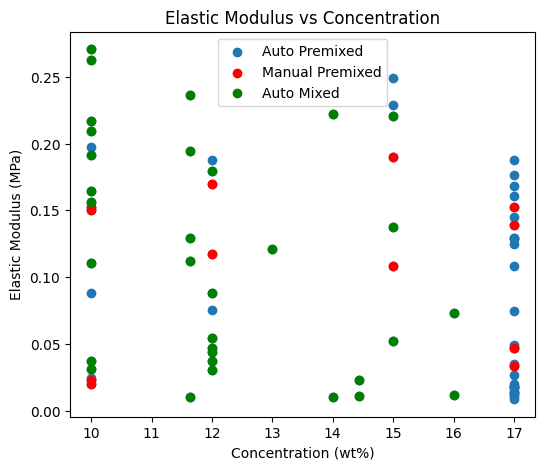

In [4]:
data_grouped = df_parameters
# drop if Coefficient of Variation is 0
data_grouped = data_grouped[data_grouped['Coefficient of Variation'] != 0]
# only take batch 31, 33, 34, 35
#data_grouped = data_grouped[data_grouped['Batch'].isin([31, 33, 34, 35,36,37])]
#only show date after 2024-10-16
#data_grouped = data_grouped[data_grouped['Date'] > '2024-09-20']
# plot Average Standard Deviation vs Concentration with error bars
plt.figure(figsize=(6, 5))
plt.scatter(data_grouped['Concentration'], data_grouped['Coefficient of Variation'], marker='o')
plt.scatter(data_grouped[data_grouped['Auto'] == False]['Concentration'], data_grouped[data_grouped['Auto'] == False]['Coefficient of Variation'], marker='o', color='red')
plt.scatter(data_grouped[data_grouped['Mixed'] == True]['Concentration'], data_grouped[data_grouped['Mixed'] == True]['Coefficient of Variation'], marker='o', color='green')
# contour the relative humidity
plt.xlabel('Concentration (wt%)')
plt.ylabel('Elastic Modulus (MPa)')
plt.title('Elastic Modulus vs Concentration')
plt.legend(['Auto Premixed', 'Manual Premixed', 'Auto Mixed'])
plt.show()

In [5]:
data_grouped = df_parameters
# drop if Coefficient of Variation is 0
data_grouped = data_grouped[data_grouped['Coefficient of Variation'] != 0]
# drop heating data
data_grouped = data_grouped[data_grouped['Heating'] == False]
# drop nitrogen data
data_grouped = data_grouped[data_grouped['Nitrogen (Side from drop)'] == 0]
data_grouped = data_grouped[data_grouped['Nitrogen (After blade)'] == 0]
#data_grouped = data_grouped[data_grouped['Concentration'] > 12]
#data_grouped = data_grouped[data_grouped['Date'] > '2024-03-01']
#data_grouped = data_grouped[data_grouped['Coefficient of Variation'] < 0.4]
# Create a new column for category labeling
data_grouped['Category'] = 'Manual Premixed'
data_grouped.loc[data_grouped['Auto'] == True, 'Category'] = 'Auto Premixed'
data_grouped.loc[data_grouped['Mixed'] == True, 'Category'] = 'Auto Mixed'

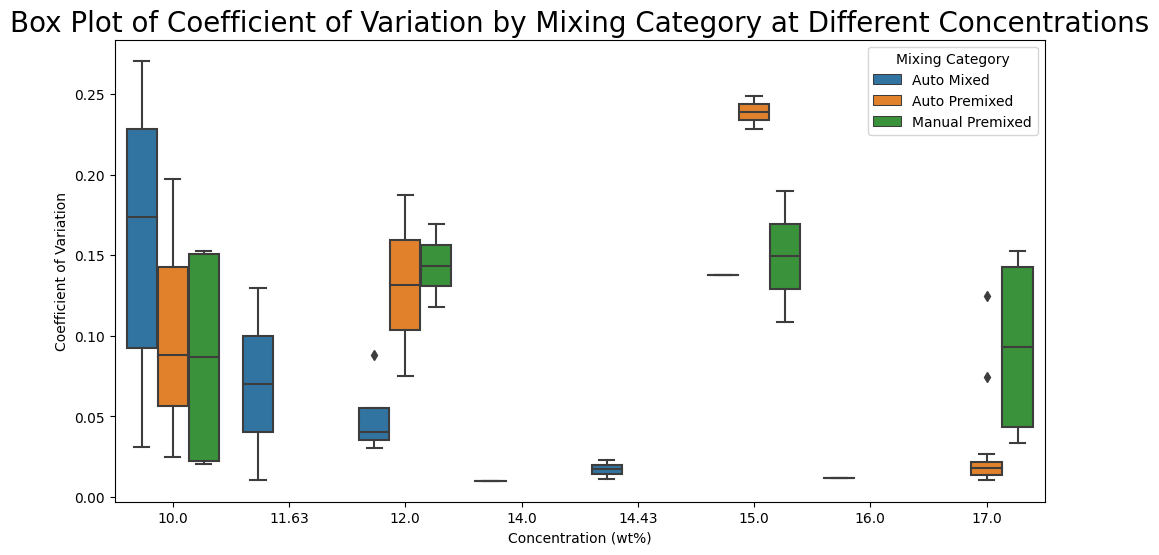

In [6]:
# Plot box plots for Coefficient of Variation grouped by Category and Concentration
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_grouped, x='Concentration', y='Coefficient of Variation', hue='Category')
plt.xlabel('Concentration (wt%)')
plt.ylabel('Coefficient of Variation')
plt.title('Box Plot of Coefficient of Variation by Mixing Category at Different Concentrations', fontsize=20)
plt.legend(title='Mixing Category', loc='upper right')
plt.show()


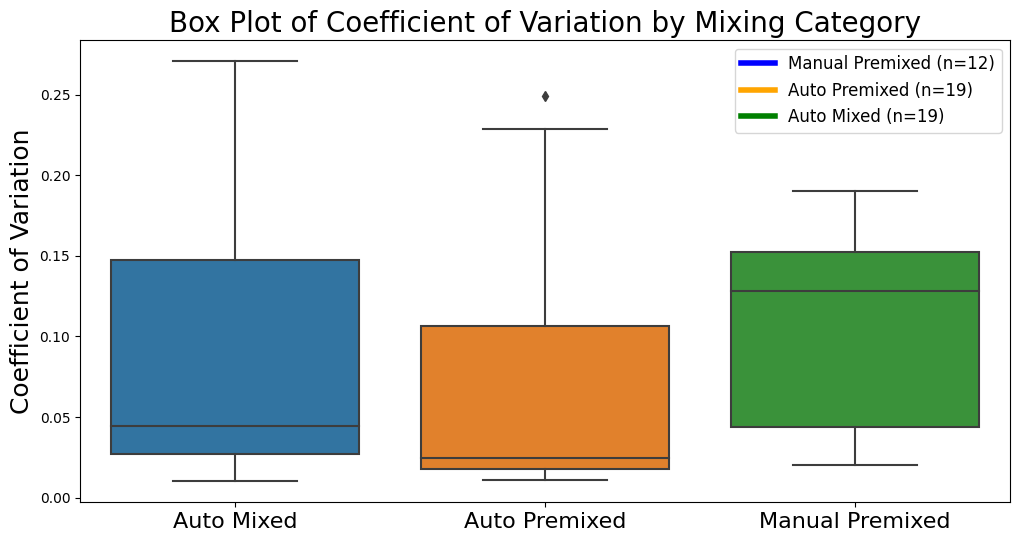

In [7]:
# Calculate sample sizes for each category
sample_sizes = data_grouped['Category'].value_counts()

# Adjust the font size and incorporate the sample sizes into the legend
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_grouped, x='Category', y='Coefficient of Variation')

# Create a custom legend with sample sizes
handles = [
    plt.Line2D([0], [0], color="blue", lw=4, label=f"Manual Premixed (n={sample_sizes['Manual Premixed']})"),
    plt.Line2D([0], [0], color="orange", lw=4, label=f"Auto Premixed (n={sample_sizes['Auto Premixed']})"),
    plt.Line2D([0], [0], color="green", lw=4, label=f"Auto Mixed (n={sample_sizes['Auto Mixed']})"),
]

plt.legend(handles=handles, loc="upper right", fontsize=12)

plt.ylabel('Coefficient of Variation', fontsize=18)
plt.xlabel('', fontsize=18)
plt.xticks(fontsize=16)
plt.title('Box Plot of Coefficient of Variation by Mixing Category', fontsize=20)
plt.show()



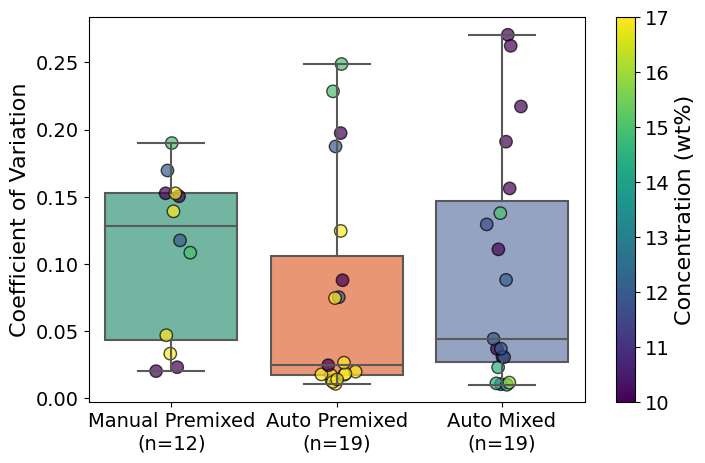

In [53]:
# Order categories for the box plot
category_order = ['Manual Premixed', 'Auto Premixed', 'Auto Mixed']

# Calculate sample sizes for each category
sample_sizes = data_grouped['Category'].value_counts()

# Plot box plots for Coefficient of Variation grouped by Category in the desired order
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=data_grouped, 
    x='Category', 
    y='Coefficient of Variation', 
    palette="Set2", 
    order=category_order,
    whis=[0, 100]
)

# Define a colormap for concentrations
norm = plt.Normalize(data_grouped['Concentration'].min(), data_grouped['Concentration'].max())
cmap = plt.cm.viridis

# Overlay scatter points for individual concentrations within each category
for i, category in enumerate(category_order):
    category_data = data_grouped[data_grouped['Category'] == category]
    np.random.seed(40)
    x_positions = np.random.normal(i, 0.05, size=len(category_data))  # Add jitter to x positions
    plt.scatter(
        x_positions,
        category_data['Coefficient of Variation'],
        c=category_data['Concentration'],  # Color by concentration
        cmap=cmap,
        norm=norm,
        alpha=0.7,
        s=80,
        edgecolor='black'
    )

# Add a colorbar to represent concentrations
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Concentration (wt%)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Add sample size to x-labels
plt.xticks(
    ticks=range(len(category_order)), 
    labels=[
        f"{category}\n(n={sample_sizes[category]})" for category in category_order
    ],
    fontsize=14,
    rotation=0,
    ha='center'
)
plt.yticks(fontsize=14)
plt.ylabel('Coefficient of Variation', fontsize=16)
plt.xlabel('', fontsize=18)
#plt.title('Box Plot of Coefficient of Variation by Manual and Auto Synthesis', fontsize=20)
plt.show()


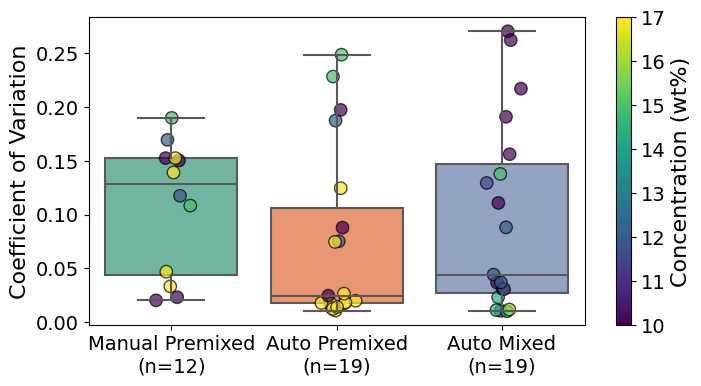

In [52]:
# Order categories for the box plot
category_order = ['Manual Premixed', 'Auto Premixed', 'Auto Mixed']

# Calculate sample sizes for each category
sample_sizes = data_grouped['Category'].value_counts()

# Plot box plots for Coefficient of Variation grouped by Category in the desired order
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=data_grouped, 
    x='Category', 
    y='Coefficient of Variation', 
    palette="Set2", 
    order=category_order,
    whis=[0, 100]
)

# Define a colormap for concentrations
norm = plt.Normalize(data_grouped['Concentration'].min(), data_grouped['Concentration'].max())
cmap = plt.cm.viridis

# Overlay scatter points for individual concentrations within each category
for i, category in enumerate(category_order):
    category_data = data_grouped[data_grouped['Category'] == category]
    np.random.seed(40)
    x_positions = np.random.normal(i, 0.05, size=len(category_data))  # Add jitter to x positions
    plt.scatter(
        x_positions,
        category_data['Coefficient of Variation'],
        c=category_data['Concentration'],  # Color by concentration
        cmap=cmap,
        norm=norm,
        alpha=0.7,
        s=80,
        edgecolor='black'
    )

# Add a colorbar to represent concentrations
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Concentration (wt%)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Add sample size to x-labels
plt.xticks(
    ticks=range(len(category_order)), 
    labels=[
        f"{category}\n(n={sample_sizes[category]})" for category in category_order
    ],
    fontsize=14,
    rotation=0,
    ha='center'
)
plt.yticks(fontsize=14)
plt.ylabel('Coefficient of Variation', fontsize=16)
plt.xlabel('', fontsize=18)
#plt.title('Box Plot of Coefficient of Variation by Manual and Auto Synthesis', fontsize=20)
plt.show()


In [54]:
# merge the two dataframes on Auto, Heating, Concentration, Batch, Sample
data = pd.merge(df, df_parameters, on=['Auto', 'Heating', 'Concentration', 'Batch', 'Sample'])
# only keep Fit = True
#data = data[data['Fit'] == True]
# heating
data = data[data['Heating'] == False]
# Coupon-to-Bath Wait Time (min)
data = data[data['Coupon-to-Bath Wait Time (min)'] == 0]
# data = data[data['Auto'] == True]
#only show date after 2024-10-16
#data = data[data['Date'] > '2024-09-20']
#data = data[data['Relative Humidity'] > 49]
# only take batch 31, 33, 34, 35
#data = data[data['Batch'].isin([31, 33, 34, 35, 36])]

data

,Name,Auto,Heating,Concentration,Batch,Sample,Trial,Thickness,Elastic Modulus,Yield Strength,...,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Cast Position Adjusted,Lifting Delay,Date,Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Coefficient of Variation
0,Auto_noheating_10wt_3_1_1,True,False,10.00,3,1,1,109.0000,76.728733,8.035941,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
1,Auto_noheating_10wt_3_1_2,True,False,10.00,3,1,2,113.0000,86.010750,8.854239,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
2,Auto_noheating_10wt_3_1_3,True,False,10.00,3,1,3,107.0000,84.672400,8.199867,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
3,Auto_noheating_10wt_3_1_4,True,False,10.00,3,1,4,106.0000,134.939046,88.742717,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
4,Auto_noheating_12wt_3_1_1,True,False,11.63,3,1,1,107.0000,88.268477,8.670033,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.010549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,Manual_Noheating_12_35_1_1,False,False,12.00,35,1,1,127.9144,74.794704,62.929975,...,False,0,0.0,1,1,2024-11-18,50,0,0,0.117584
232,Manual_Noheating_12_35_1_2,False,False,12.00,35,1,2,123.4186,96.297987,70.212727,...,False,0,0.0,1,1,2024-11-18,50,0,0,0.117584
233,Manual_Noheating_12_35_1_3,False,False,12.00,35,1,3,123.9774,114.947180,64.540243,...,False,0,0.0,1,1,2024-11-18,50,0,0,0.117584
234,Manual_Noheating_15_35_1_1,False,False,15.00,35,1,1,129.8702,94.627610,62.375304,...,False,0,0.0,1,1,2024-11-18,50,0,0,0.190041


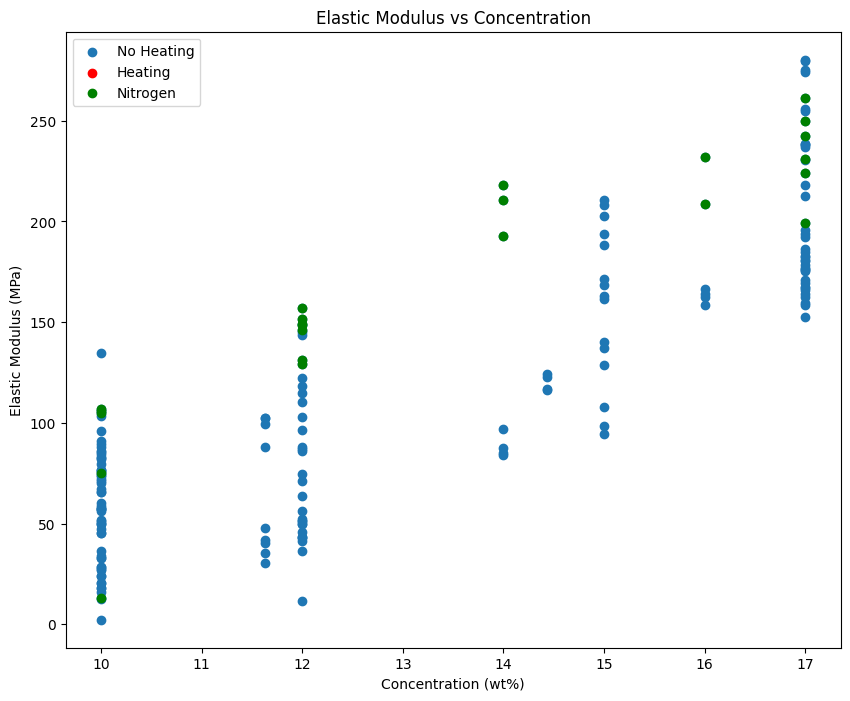

In [55]:
# plot Elastic Modulus vs Concentration
plt.figure(figsize=(10, 8))
plt.scatter(data['Concentration'], data['Elastic Modulus'])
# if Heating = True, plot in red, else plot in blue
plt.scatter(data[data['Heating'] == True]['Concentration'], data[data['Heating'] == True]['Elastic Modulus'], color='red')
# if Nitrogen = 1, plot in green, else plot in blue
plt.scatter(data[data['Nitrogen (Side from drop)'] == 1]['Concentration'], data[data['Nitrogen (Side from drop)'] == 1]['Elastic Modulus'], color='green')
plt.xlabel('Concentration (wt%)')
plt.ylabel('Elastic Modulus (MPa)')
plt.title('Elastic Modulus vs Concentration')
plt.legend(['No Heating', 'Heating', 'Nitrogen'])
plt.show()

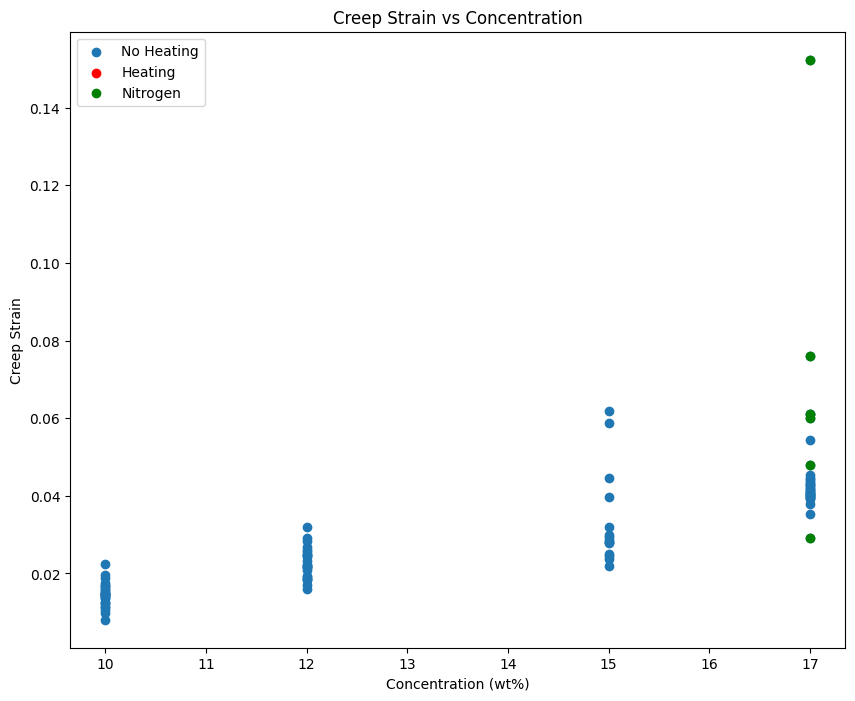

In [56]:
# plot Creep Strain vs Concentration
plt.figure(figsize=(10, 8))
plt.scatter(data['Concentration'], data['Creep Strain'])
plt.scatter(data[data['Heating'] == True]['Concentration'], data[data['Heating'] == True]['Creep Strain'], color='red')
# if Nitrogen = 1, plot in green, else plot in blue
plt.scatter(data[data['Nitrogen (Side from drop)'] == 1]['Concentration'], data[data['Nitrogen (Side from drop)'] == 1]['Creep Strain'], color='green')
plt.xlabel('Concentration (wt%)')
plt.ylabel('Creep Strain')
plt.title('Creep Strain vs Concentration')
plt.legend(['No Heating', 'Heating', 'Nitrogen'])
plt.show()

## Grouped

In [57]:
# Group by the specified columns and calculate mean and std for the required properties
data_grouped = data.groupby(['Auto', 'Heating', 'Concentration', 'Batch', 'Sample']).agg({
    'Elastic Modulus': ['mean', 'std'],
    'Yield Strength': ['mean', 'std'],
    'Creep Strain': ['mean', 'std'],
    'Plateau Slope': ['mean', 'std'],
    'Densification Slope': ['mean', 'std'],
    'Changepoint': ['mean', 'std'],
    'Average Standard Deviation': ['mean', 'std'],
    'Coefficient of Variation': ['mean', 'std']
})

# Flatten MultiIndex columns after aggregation
data_grouped.columns = ['_'.join(col).strip() for col in data_grouped.columns.values]
data_grouped = data_grouped.reset_index()

# Merge the grouped data with df_parameters
data_grouped = pd.merge(data_grouped, df_parameters, on=['Auto', 'Heating', 'Concentration', 'Batch', 'Sample'])
# shuffle
data_grouped = data_grouped.sample(frac=1, random_state=42).reset_index(drop=True)
data_grouped


,Auto,Heating,Concentration,Batch,Sample,Elastic Modulus_mean,Elastic Modulus_std,Yield Strength_mean,Yield Strength_std,Creep Strain_mean,...,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Cast Position Adjusted,Lifting Delay,Date,Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Coefficient of Variation
0,True,False,12.00,32,1,119.797042,42.290980,30.198832,24.476588,0.019309,...,False,0,0.0,1,1,2024-11-14,46,0,0,0.075334
1,False,False,12.00,35,1,95.346624,20.093137,65.894315,3.825540,0.021647,...,False,0,0.0,1,1,2024-11-18,50,0,0,0.117584
2,True,False,12.00,33,1,106.701086,5.391885,68.597644,0.917450,0.026193,...,False,0,0.0,1,1,2024-11-15,50,0,0,0.187493
3,True,False,10.00,6,1,35.102261,20.823966,17.952590,5.638945,NaN,...,True,1,0.0,1,0,2024-02-28,77,0,0,0.191079
4,True,False,10.00,21,1,56.885008,18.467885,32.642527,6.886120,0.016055,...,False,0,0.0,1,1,2024-09-13,76,0,0,0.197462
5,True,False,17.00,19,2,242.915092,26.320162,53.291808,53.361675,0.060546,...,False,0,0.0,1,1,2024-09-11,68,1,0,0.129268
6,True,False,16.00,14,1,220.510402,16.602283,19.736372,2.978700,NaN,...,True,1,0.0,1,1,2024-07-26,54,1,0,0.073166
7,True,False,12.00,11,1,42.736240,1.258304,2.833861,0.188638,NaN,...,True,1,0.0,1,1,2024-05-30,49,0,0,0.030669
8,True,False,17.00,4,1,178.973793,2.999909,14.504132,0.415735,NaN,...,False,4,0.0,1,0,2024-02-26,59,0,0,0.010787
9,True,False,10.00,5,1,51.168444,25.540908,20.332874,5.869294,NaN,...,True,0,0.0,1,0,2024-02-23,61,0,0,0.217247


In [58]:
# show rows with Elastic Modulus_mean > 300
data_grouped[data_grouped['Elastic Modulus_mean'] > 250]

,Auto,Heating,Concentration,Batch,Sample,Elastic Modulus_mean,Elastic Modulus_std,Yield Strength_mean,Yield Strength_std,Creep Strain_mean,...,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Cast Position Adjusted,Lifting Delay,Date,Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Coefficient of Variation
22,True,False,17.0,33,1,277.386121,3.020173,21.12867,2.333048,0.045986,...,False,0,0.0,1,1,2024-11-15,50,0,0,0.124628


In [59]:
data_grouped.columns

Index(['Auto', 'Heating', 'Concentration', 'Batch', 'Sample',
       'Elastic Modulus_mean', 'Elastic Modulus_std', 'Yield Strength_mean',
       'Yield Strength_std', 'Creep Strain_mean', 'Creep Strain_std',
       'Plateau Slope_mean', 'Plateau Slope_std', 'Densification Slope_mean',
       'Densification Slope_std', 'Changepoint_mean', 'Changepoint_std',
       'Average Standard Deviation_mean', 'Average Standard Deviation_std',
       'Coefficient of Variation_mean', 'Coefficient of Variation_std',
       'Mixing Height and Lift Adjusted', 'Heated Container', 'Heated Block',
       'Heating Block Temperature', 'Mixed', 'Rest Time (days)',
       'Coupon-to-Bath Wait Time (min)', 'Cast Position Adjusted',
       'Lifting Delay', 'Date', 'Relative Humidity',
       'Nitrogen (Side from drop)', 'Nitrogen (After blade)',
       'Coefficient of Variation'],
      dtype='object')

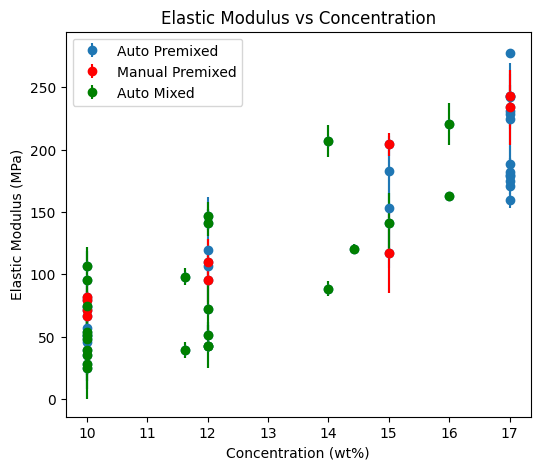

In [60]:
# plot Elastic Modulus vs Concentration with error bars
plt.figure(figsize=(6, 5))
plt.errorbar(data_grouped['Concentration'], data_grouped['Elastic Modulus_mean'], yerr=data_grouped['Elastic Modulus_std'], fmt='o')
plt.errorbar(data_grouped[data_grouped['Auto'] == False]['Concentration'], data_grouped[data_grouped['Auto'] == False]['Elastic Modulus_mean'], yerr=data_grouped[data_grouped['Auto'] == False]['Elastic Modulus_std'], fmt='o', color='red')
plt.errorbar(data_grouped[data_grouped['Mixed'] == True]['Concentration'], data_grouped[data_grouped['Mixed'] == True]['Elastic Modulus_mean'], yerr=data_grouped[data_grouped['Mixed'] == True]['Elastic Modulus_std'], fmt='o', color='green')
# contour the relative humidity
plt.xlabel('Concentration (wt%)')
plt.ylabel('Elastic Modulus (MPa)')
plt.title('Elastic Modulus vs Concentration')
plt.legend(['Auto Premixed', 'Manual Premixed', 'Auto Mixed'])
plt.show()

In [61]:
#data_grouped.to_csv('all_data_grouped_20241107.csv', index=False)

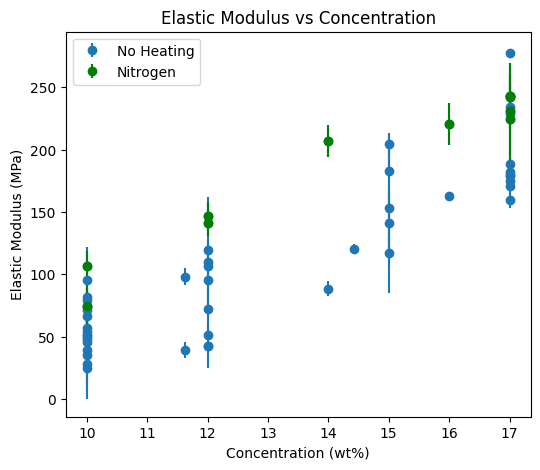

In [62]:
# plot Elastic Modulus vs Concentration with error bars
plt.figure(figsize=(6, 5))
plt.errorbar(data_grouped['Concentration'], data_grouped['Elastic Modulus_mean'], yerr=data_grouped['Elastic Modulus_std'], fmt='o')
#plt.errorbar(data_grouped[data_grouped['Heating'] == True]['Concentration'], data_grouped[data_grouped['Heating'] == True]['Elastic Modulus_mean'], yerr=data_grouped[data_grouped['Heating'] == True]['Elastic Modulus_std'], fmt='o', color='red')
plt.errorbar(data_grouped[data_grouped['Nitrogen (Side from drop)'] == 1]['Concentration'], data_grouped[data_grouped['Nitrogen (Side from drop)'] == 1]['Elastic Modulus_mean'], yerr=data_grouped[data_grouped['Nitrogen (Side from drop)'] == 1]['Elastic Modulus_std'], fmt='o', color='green')
# contour the relative humidity
plt.xlabel('Concentration (wt%)')
plt.ylabel('Elastic Modulus (MPa)')
plt.title('Elastic Modulus vs Concentration')
plt.legend(['No Heating',  'Nitrogen'])
plt.show()

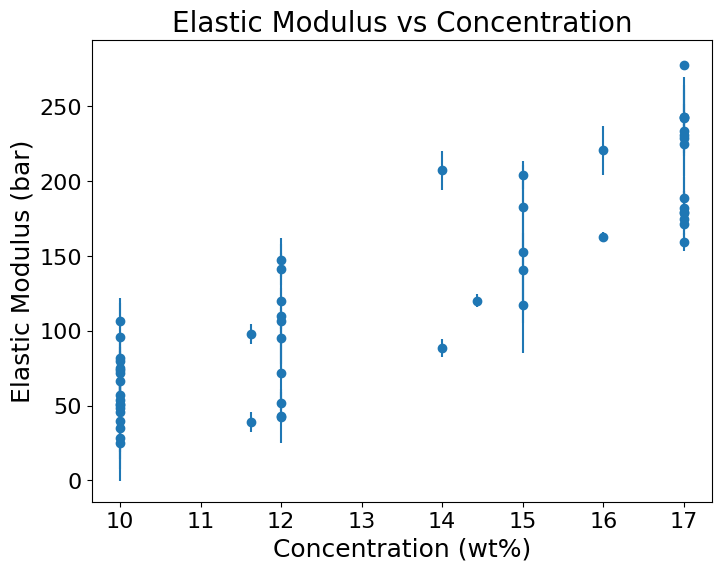

In [63]:
# plot Elastic Modulus vs Concentration with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(data_grouped['Concentration'], data_grouped['Elastic Modulus_mean'], yerr=data_grouped['Elastic Modulus_std'], fmt='o')
plt.xlabel('Concentration (wt%)', fontsize=18)
plt.ylabel('Elastic Modulus (bar)', fontsize=18)
plt.title('Elastic Modulus vs Concentration', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

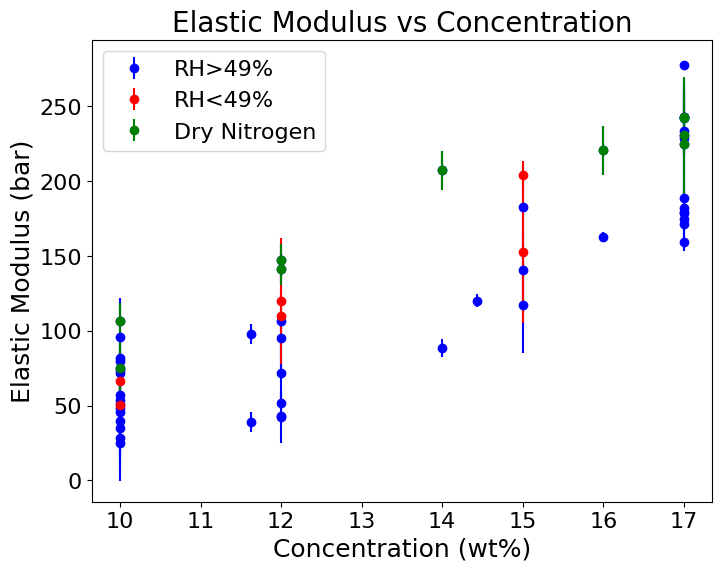

In [64]:
# plot Elastic Modulus vs Concentration with error bars
plt.figure(figsize=(8, 6))
RH_cutoff = 49
plt.errorbar(data_grouped[data_grouped['Relative Humidity'] >= RH_cutoff]['Concentration'], data_grouped[data_grouped['Relative Humidity'] >= RH_cutoff]['Elastic Modulus_mean'], yerr=data_grouped[data_grouped['Relative Humidity'] >= RH_cutoff]['Elastic Modulus_std'], fmt='o', color='blue')
plt.errorbar(data_grouped[data_grouped['Relative Humidity'] < RH_cutoff]['Concentration'], data_grouped[data_grouped['Relative Humidity'] < RH_cutoff]['Elastic Modulus_mean'], yerr=data_grouped[data_grouped['Relative Humidity'] < RH_cutoff]['Elastic Modulus_std'], fmt='o', color='red')
plt.errorbar(data_grouped[data_grouped['Nitrogen (Side from drop)'] == 1]['Concentration'], data_grouped[data_grouped['Nitrogen (Side from drop)'] == 1]['Elastic Modulus_mean'], yerr=data_grouped[data_grouped['Nitrogen (Side from drop)'] == 1]['Elastic Modulus_std'], fmt='o', color='green')
# contour the relative humidity
plt.xlabel('Concentration (wt%)', fontsize=18)
plt.ylabel('Elastic Modulus (bar)', fontsize=18)
plt.title('Elastic Modulus vs Concentration', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['RH>'+str(RH_cutoff)+'%', 'RH<'+str(RH_cutoff)+'%', 'Dry Nitrogen'], fontsize=16)
plt.show()

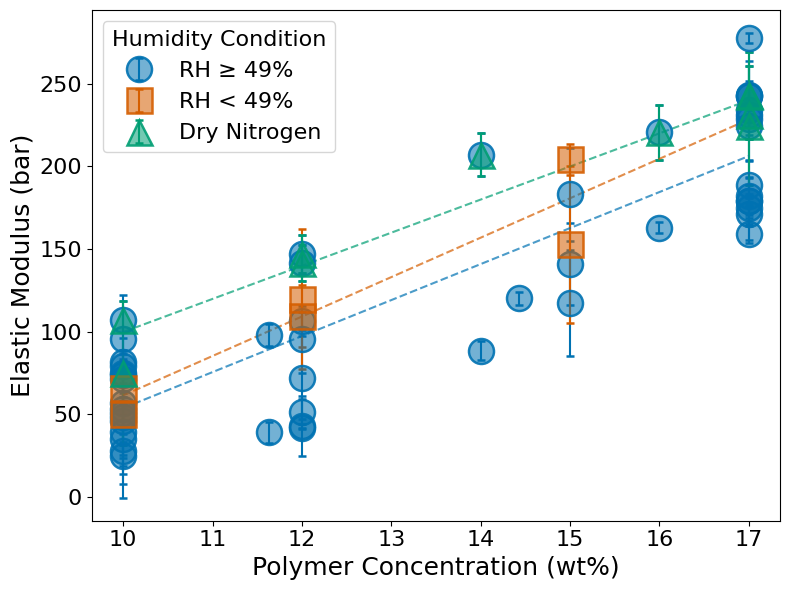

In [80]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
from sklearn.linear_model import LinearRegression

# --- Color-blind-friendly palette (Okabe–Ito) ---
palette = {
    "high_RH": "#0072B2",     # blue
    "low_RH":  "#D55E00",     # vermilion
    "dry_N2":  "#009E73",     # bluish green
}

# Define humidity cutoff and categorize data
RH_cutoff = 49
high_RH = data_grouped[data_grouped['Relative Humidity'] >= RH_cutoff]
low_RH = data_grouped[data_grouped['Relative Humidity'] < RH_cutoff]
dry_nitrogen = data_grouped[data_grouped['Nitrogen (Side from drop)'] == 1]

plt.figure(figsize=(8, 6))

# Styling
marker_size = 18
cap_size = 3
error_line_width = 1.5
fit_line_alpha = 0.7
fit_line_style = '--'
marker_face_alpha = 0.55       # << marker fill transparency
marker_edge_alpha = 0.9        # << marker edge transparency
marker_edge_width = 1.8

# High RH
plt.errorbar(
    high_RH['Concentration'], high_RH['Elastic Modulus_mean'],
    yerr=high_RH['Elastic Modulus_std'], fmt='o',
    color=palette["high_RH"],                 # line color
    ecolor=palette["high_RH"],                # errorbar color
    markerfacecolor=to_rgba(palette["high_RH"], marker_face_alpha),
    markeredgecolor=to_rgba(palette["high_RH"], marker_edge_alpha),
    markeredgewidth=marker_edge_width, markersize=marker_size,
    capsize=cap_size, elinewidth=error_line_width,
    label=f'RH ≥ {RH_cutoff}%'
)

# Low RH
plt.errorbar(
    low_RH['Concentration'], low_RH['Elastic Modulus_mean'],
    yerr=low_RH['Elastic Modulus_std'], fmt='s',
    color=palette["low_RH"], ecolor=palette["low_RH"],
    markerfacecolor=to_rgba(palette["low_RH"], marker_face_alpha),
    markeredgecolor=to_rgba(palette["low_RH"], marker_edge_alpha),
    markeredgewidth=marker_edge_width, markersize=marker_size,
    capsize=cap_size, elinewidth=error_line_width,
    label=f'RH < {RH_cutoff}%'
)

# Dry N2
plt.errorbar(
    dry_nitrogen['Concentration'], dry_nitrogen['Elastic Modulus_mean'],
    yerr=dry_nitrogen['Elastic Modulus_std'], fmt='^',
    color=palette["dry_N2"], ecolor=palette["dry_N2"],
    markerfacecolor=to_rgba(palette["dry_N2"], marker_face_alpha),
    markeredgecolor=to_rgba(palette["dry_N2"], marker_edge_alpha),
    markeredgewidth=marker_edge_width, markersize=marker_size,
    capsize=cap_size, elinewidth=error_line_width,
    label='Dry Nitrogen'
)

# Fit lines (keep separate alpha control)
def fit_and_extrapolate(data, color, x_min, x_max):
    if len(data) > 1:
        model = LinearRegression()
        X = data[['Concentration']].values
        y = data['Elastic Modulus_mean'].values
        model.fit(X, y)
        x_range = np.linspace(x_min, x_max, 100).reshape(-1, 1)
        y_pred = model.predict(x_range)
        plt.plot(x_range, y_pred, linestyle=fit_line_style, color=color, alpha=fit_line_alpha)

x_min, x_max = data_grouped['Concentration'].min(), data_grouped['Concentration'].max()
fit_and_extrapolate(high_RH, palette["high_RH"], x_min, x_max)
fit_and_extrapolate(low_RH, palette["low_RH"], x_min, x_max)
fit_and_extrapolate(dry_nitrogen, palette["dry_N2"], x_min, x_max)

plt.xlabel('Polymer Concentration (wt%)', fontsize=18)
plt.ylabel('Elastic Modulus (bar)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, title='Humidity Condition', title_fontsize=16)
plt.tight_layout()
plt.show()


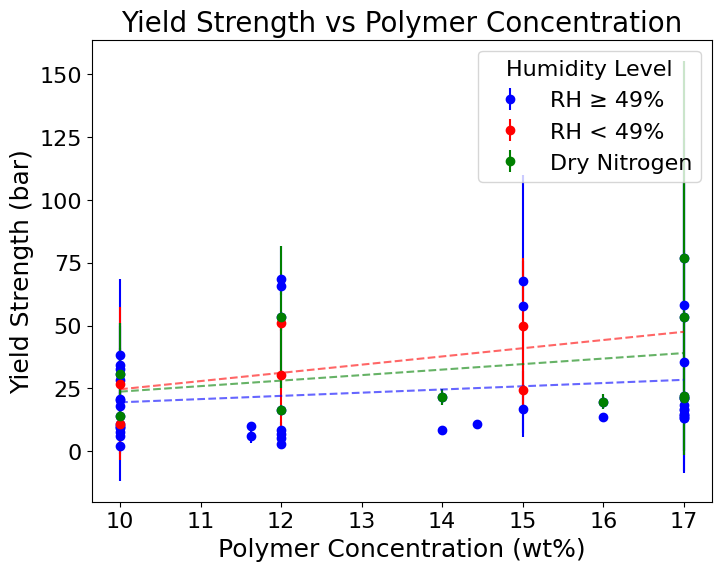

In [70]:
# Initialize figure for Yield Strength vs Concentration
plt.figure(figsize=(8, 6))

# Plot data with error bars for Yield Strength
plt.errorbar(high_RH['Concentration'], high_RH['Yield Strength_mean'], yerr=high_RH['Yield Strength_std'], fmt='o', color='blue', label=f'RH ≥ {RH_cutoff}%')
plt.errorbar(low_RH['Concentration'], low_RH['Yield Strength_mean'], yerr=low_RH['Yield Strength_std'], fmt='o', color='red', label=f'RH < {RH_cutoff}%')
plt.errorbar(dry_nitrogen['Concentration'], dry_nitrogen['Yield Strength_mean'], yerr=dry_nitrogen['Yield Strength_std'], fmt='o', color='green', label='Dry Nitrogen')

# Function to fit and extrapolate Yield Strength trends
def fit_and_extrapolate_yield(data, color, x_min, x_max):
    if len(data) > 1:
        model = LinearRegression()
        X = data[['Concentration']].values
        y = data['Yield Strength_mean'].values
        model.fit(X, y)
        x_range = np.linspace(x_min, x_max, 100).reshape(-1, 1)  # Extend beyond data range
        y_pred = model.predict(x_range)
        plt.plot(x_range, y_pred, color=color, linestyle='--', alpha=0.6)

# Fit and plot lines for Yield Strength
fit_and_extrapolate_yield(high_RH, 'blue', min(data_grouped['Concentration']), max(data_grouped['Concentration']))
fit_and_extrapolate_yield(low_RH, 'red', min(data_grouped['Concentration']), max(data_grouped['Concentration']))  # Extrapolated
fit_and_extrapolate_yield(dry_nitrogen, 'green', min(data_grouped['Concentration']), max(data_grouped['Concentration']))

# Labels and title
plt.xlabel('Polymer Concentration (wt%)', fontsize=18)
plt.ylabel('Yield Strength (bar)', fontsize=18)
plt.title('Yield Strength vs Polymer Concentration', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, title='Humidity Level', title_fontsize='16')

# Show plot
plt.show()


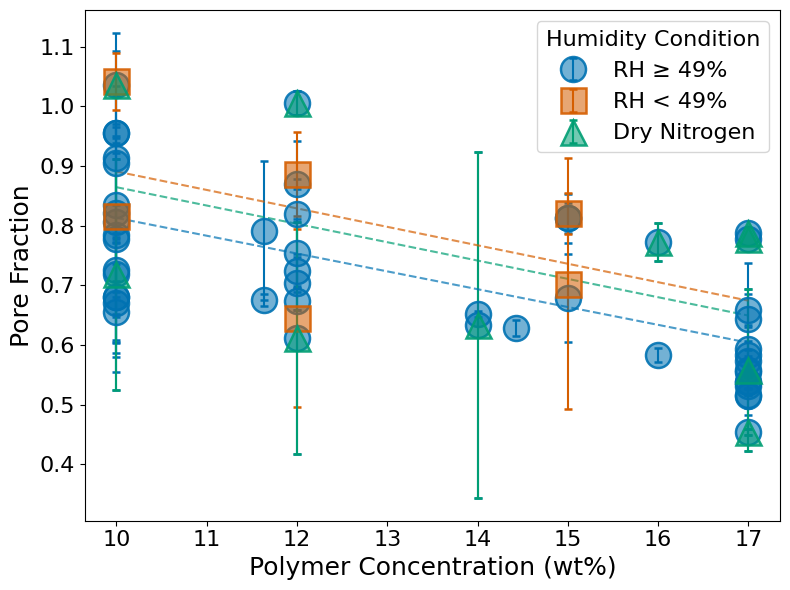

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
from sklearn.linear_model import LinearRegression

# --- Color-blind-friendly palette (Okabe–Ito) ---
palette = {
    "high_RH": "#0072B2",   # blue
    "low_RH":  "#D55E00",   # vermilion
    "dry_N2":  "#009E73",   # bluish green
}

plt.figure(figsize=(8, 6))

# Styling parameters
marker_size = 18
cap_size = 3
error_line_width = 1.5
fit_line_alpha = 0.7
fit_line_style = '--'
marker_edge_width = 1.8
marker_face_alpha = 0.55
marker_edge_alpha = 0.9

# High RH
plt.errorbar(
    high_RH['Concentration'], high_RH['Changepoint_mean'],
    yerr=high_RH['Changepoint_std'], fmt='o',
    color=palette["high_RH"], ecolor=palette["high_RH"],
    markerfacecolor=to_rgba(palette["high_RH"], marker_face_alpha),
    markeredgecolor=to_rgba(palette["high_RH"], marker_edge_alpha),
    markeredgewidth=marker_edge_width, markersize=marker_size,
    capsize=cap_size, elinewidth=error_line_width,
    label=f'RH ≥ {RH_cutoff}%'
)

# Low RH
plt.errorbar(
    low_RH['Concentration'], low_RH['Changepoint_mean'],
    yerr=low_RH['Changepoint_std'], fmt='s',
    color=palette["low_RH"], ecolor=palette["low_RH"],
    markerfacecolor=to_rgba(palette["low_RH"], marker_face_alpha),
    markeredgecolor=to_rgba(palette["low_RH"], marker_edge_alpha),
    markeredgewidth=marker_edge_width, markersize=marker_size,
    capsize=cap_size, elinewidth=error_line_width,
    label=f'RH < {RH_cutoff}%'
)

# Dry N2
plt.errorbar(
    dry_nitrogen['Concentration'], dry_nitrogen['Changepoint_mean'],
    yerr=dry_nitrogen['Changepoint_std'], fmt='^',
    color=palette["dry_N2"], ecolor=palette["dry_N2"],
    markerfacecolor=to_rgba(palette["dry_N2"], marker_face_alpha),
    markeredgecolor=to_rgba(palette["dry_N2"], marker_edge_alpha),
    markeredgewidth=marker_edge_width, markersize=marker_size,
    capsize=cap_size, elinewidth=error_line_width,
    label='Dry Nitrogen'
)

# Fit + extrapolate
def fit_and_extrapolate_changepoint(data, color, x_min, x_max):
    if len(data) > 1:
        model = LinearRegression()
        X = data[['Concentration']].values
        y = data['Changepoint_mean'].values
        model.fit(X, y)
        x_range = np.linspace(x_min, x_max, 100).reshape(-1, 1)
        y_pred = model.predict(x_range)
        plt.plot(x_range, y_pred, color=color, linestyle=fit_line_style, alpha=fit_line_alpha)

x_min = data_grouped['Concentration'].min()
x_max = data_grouped['Concentration'].max()
fit_and_extrapolate_changepoint(high_RH, palette["high_RH"], x_min, x_max)
fit_and_extrapolate_changepoint(low_RH,  palette["low_RH"],  x_min, x_max)
fit_and_extrapolate_changepoint(dry_nitrogen, palette["dry_N2"], x_min, x_max)

plt.xlabel('Polymer Concentration (wt%)', fontsize=18)
plt.ylabel('Pore Fraction', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, title='Humidity Condition', title_fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# plot Elastic Modulus vs Concentration with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(data_grouped['Concentration'], data_grouped['Plateau Slope_mean'], yerr=data_grouped['Plateau Slope_std'], fmt='o')
RH_cutoff = 48
plt.errorbar(data_grouped[data_grouped['Relative Humidity'] <= RH_cutoff]['Concentration'], data_grouped[data_grouped['Relative Humidity'] <= RH_cutoff]['Plateau Slope_mean'], yerr=data_grouped[data_grouped['Relative Humidity'] <= RH_cutoff]['Plateau Slope_std'], fmt='o', color='red')
plt.errorbar(data_grouped[data_grouped['Nitrogen (Side from drop)'] == 1]['Concentration'], data_grouped[data_grouped['Nitrogen (Side from drop)'] == 1]['Plateau Slope_mean'], yerr=data_grouped[data_grouped['Nitrogen (Side from drop)'] == 1]['Plateau Slope_std'], fmt='o', color='green')
# contour the relative humidity
plt.xlabel('Concentration (wt%)', fontsize=18)
plt.ylabel('Plateau Slope', fontsize=18)
plt.title('Plateau Slope vs Concentration', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['RH>'+str(RH_cutoff), 'RH<'+str(RH_cutoff), 'With Nitrogen'], fontsize=16)
plt.show()

In [ ]:
# plot Elastic Modulus vs Concentration with error bars
plt.figure(figsize=(6, 5))
plt.errorbar(data_grouped['Concentration'], data_grouped['Elastic Modulus_mean'], yerr=data_grouped['Elastic Modulus_std'], fmt='o')
plt.errorbar(data_grouped[data_grouped['Auto'] == False]['Concentration'], data_grouped[data_grouped['Auto'] == False]['Elastic Modulus_mean'], yerr=data_grouped[data_grouped['Auto'] == False]['Elastic Modulus_std'], fmt='o', color='red')
plt.errorbar(data_grouped[data_grouped['Mixed'] == True]['Concentration'], data_grouped[data_grouped['Mixed'] == True]['Elastic Modulus_mean'], yerr=data_grouped[data_grouped['Mixed'] == True]['Elastic Modulus_std'], fmt='o', color='green')
# contour the relative humidity
plt.xlabel('Concentration (wt%)')
plt.ylabel('Elastic Modulus (MPa)')
plt.title('Elastic Modulus vs Concentration')
plt.legend(['Auto Premixed', 'Manual Premixed', 'Auto Mixed'])
plt.show()

In [ ]:
# plot Elastic Modulus_std vs relative humidity
plt.figure(figsize=(6, 5))
plt.errorbar(data_grouped['Relative Humidity'], data_grouped['Elastic Modulus_std'], fmt='o')
plt.errorbar(data_grouped[data_grouped['Heating'] == True]['Relative Humidity'], data_grouped[data_grouped['Heating'] == True]['Elastic Modulus_std'], fmt='o', color='red')
plt.errorbar(data_grouped[data_grouped['Nitrogen (Side from drop)'] == 1]['Relative Humidity'], data_grouped[data_grouped['Nitrogen (Side from drop)'] == 1]['Elastic Modulus_std'], fmt='o', color='green')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Elastic Modulus (MPa)')
plt.title('Elastic Modulus vs Relative Humidity')
plt.legend(['No Heating', 'Heating', 'Nitrogen'])
plt.show()

In [ ]:
# plot Elastic Modulus vs Concentration with error bars
plt.figure(figsize=(6, 5))
plt.errorbar(data_grouped['Concentration'], data_grouped['Creep Strain_mean'], yerr=data_grouped['Creep Strain_std'], fmt='o')
plt.errorbar(data_grouped[data_grouped['Relative Humidity'] <= 50]['Concentration'], data_grouped[data_grouped['Relative Humidity'] <= 50]['Creep Strain_mean'], yerr=data_grouped[data_grouped['Relative Humidity'] <= 50]['Creep Strain_std'], fmt='o', color='red')
plt.errorbar(data_grouped[data_grouped['Nitrogen (Side from drop)'] == 1]['Concentration'], data_grouped[data_grouped['Nitrogen (Side from drop)'] == 1]['Creep Strain_mean'], yerr=data_grouped[data_grouped['Nitrogen (Side from drop)'] == 1]['Creep Strain_std'], fmt='o', color='green')
# contour the relative humidity
plt.xlabel('Concentration (wt%)')
plt.ylabel('Elastic Modulus (MPa)')
plt.title('Elastic Modulus vs Concentration')
plt.legend(['RH>50', 'RH<50', 'Nitrogen'])
plt.show()

# PSD

In [58]:
df = pd.read_csv('Pore_Size_Distribution_Summary_cleaned.csv')
df 

,Pore Diameter (nm),10 MEAN,10 error,12 MEAN,12 error,15 MEAN,15 error
0,0.5,9.370000e-05,1.950000e-05,1.470000e-04,2.280000e-05,2.090000e-04,4.110000e-05
1,1.5,2.223530e-04,3.860000e-05,3.410000e-04,4.600000e-05,4.770000e-04,8.800000e-05
2,2.5,5.022790e-04,6.990000e-05,7.520950e-04,8.510000e-05,1.020000e-03,1.644690e-04
3,3.5,9.650800e-04,1.030710e-04,1.407096e-03,1.322750e-04,1.845250e-03,2.270000e-04
4,4.5,1.652404e-03,1.315380e-04,2.336854e-03,1.907580e-04,2.986120e-03,2.332230e-04
5,5.5,2.598802e-03,1.515720e-04,3.531006e-03,2.679600e-04,4.492050e-03,1.831230e-04
6,6.5,3.757880e-03,1.498370e-04,4.839743e-03,3.562630e-04,6.217138e-03,9.660000e-05
7,7.5,4.946135e-03,1.144930e-04,5.970556e-03,4.322810e-04,7.713751e-03,2.000000e-05
8,8.5,5.923708e-03,1.371900e-04,6.684680e-03,4.638900e-04,8.507893e-03,1.323570e-04
9,9.5,6.560993e-03,2.709900e-04,6.974311e-03,4.202160e-04,8.472299e-03,2.190070e-04


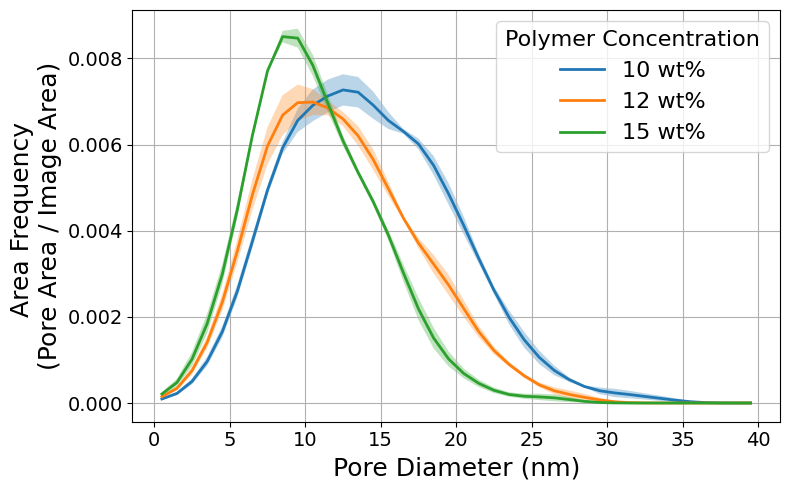

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and rename columns
df = pd.read_csv("Pore_Size_Distribution_Summary_cleaned.csv")
df.rename(columns={
    'Pore Diameter (nm)': 'Pore_Diameter',
    '10 MEAN': 'Mean_10', '10 error': 'Error_10',
    '12 MEAN': 'Mean_12', '12 error': 'Error_12',
    '15 MEAN': 'Mean_15', '15 error': 'Error_15'
}, inplace=True)

# Convert to long format
df_long = pd.DataFrame({
    'Pore_Diameter': pd.concat([df['Pore_Diameter']] * 3, ignore_index=True),
    'Concentration': ['10 wt%'] * len(df) + ['12 wt%'] * len(df) + ['15 wt%'] * len(df),
    'Mean_Intensity': pd.concat([df['Mean_10'], df['Mean_12'], df['Mean_15']], ignore_index=True),
    'Error_Intensity': pd.concat([df['Error_10'], df['Error_12'], df['Error_15']], ignore_index=True)
})

# Coerce types and clean
df_long['Pore_Diameter'] = pd.to_numeric(df_long['Pore_Diameter'], errors='coerce')
df_long['Mean_Intensity'] = pd.to_numeric(df_long['Mean_Intensity'], errors='coerce')
df_long['Error_Intensity'] = pd.to_numeric(df_long['Error_Intensity'], errors='coerce')
df_long.dropna(inplace=True)

# Ensure correct dtype
df_long = df_long.astype({
    'Pore_Diameter': 'float64',
    'Mean_Intensity': 'float64',
    'Error_Intensity': 'float64'
})

# Plot
plt.figure(figsize=(8, 5))
for conc in df_long['Concentration'].unique():
    subset = df_long[df_long['Concentration'] == conc]
    plt.plot(subset['Pore_Diameter'], subset['Mean_Intensity'], label=conc, linewidth=2)
    plt.fill_between(subset['Pore_Diameter'],
                     subset['Mean_Intensity'] - subset['Error_Intensity'],
                     subset['Mean_Intensity'] + subset['Error_Intensity'],
                     alpha=0.3)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Pore Diameter (nm)", fontsize=18)
plt.ylabel("Area Frequency \n(Pore Area / Image Area)", fontsize=18)
#plt.title("Surface Pore Size Distribution of PSf Membranes")
plt.legend(title="Polymer Concentration", fontsize=16, title_fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


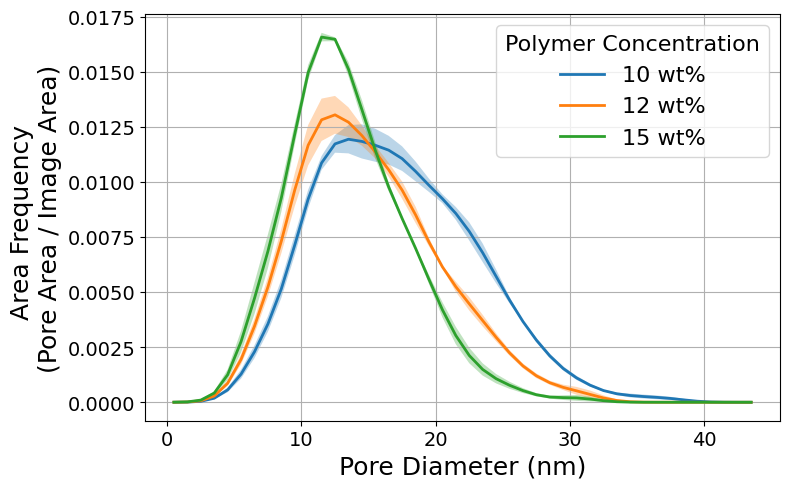

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and rename columns
df = pd.read_csv("Pore_Size_Distribution_Summary_uncoated.csv")
df.rename(columns={
    'Pore Diameter (nm)': 'Pore_Diameter',
    '10 MEAN': 'Mean_10', '10 error': 'Error_10',
    '12 MEAN': 'Mean_12', '12 error': 'Error_12',
    '15 MEAN': 'Mean_15', '15 error': 'Error_15'
}, inplace=True)

# Convert to long format
df_long = pd.DataFrame({
    'Pore_Diameter': pd.concat([df['Pore_Diameter']] * 3, ignore_index=True),
    'Concentration': ['10 wt%'] * len(df) + ['12 wt%'] * len(df) + ['15 wt%'] * len(df),
    'Mean_Intensity': pd.concat([df['Mean_10'], df['Mean_12'], df['Mean_15']], ignore_index=True),
    'Error_Intensity': pd.concat([df['Error_10'], df['Error_12'], df['Error_15']], ignore_index=True)
})

# Coerce types and clean
df_long['Pore_Diameter'] = pd.to_numeric(df_long['Pore_Diameter'], errors='coerce')
df_long['Mean_Intensity'] = pd.to_numeric(df_long['Mean_Intensity'], errors='coerce')
df_long['Error_Intensity'] = pd.to_numeric(df_long['Error_Intensity'], errors='coerce')
df_long.dropna(inplace=True)

# Ensure correct dtype
df_long = df_long.astype({
    'Pore_Diameter': 'float64',
    'Mean_Intensity': 'float64',
    'Error_Intensity': 'float64'
})

# Plot
plt.figure(figsize=(8, 5))
for conc in df_long['Concentration'].unique():
    subset = df_long[df_long['Concentration'] == conc]
    plt.plot(subset['Pore_Diameter'], subset['Mean_Intensity'], label=conc, linewidth=2)
    plt.fill_between(subset['Pore_Diameter'],
                     subset['Mean_Intensity'] - subset['Error_Intensity'],
                     subset['Mean_Intensity'] + subset['Error_Intensity'],
                     alpha=0.3)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Pore Diameter (nm)", fontsize=18)
plt.ylabel("Area Frequency \n(Pore Area / Image Area)", fontsize=18)
#plt.title("Surface Pore Size Distribution of PSf Membranes")
plt.legend(title="Polymer Concentration", fontsize=16, title_fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


# ML

In [ ]:
# plot the correlation matrix with absolute values
plt.figure(figsize=(20, 20))
sns.heatmap(data_grouped.corr().abs(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Calculate the correlation matrix with absolute values
corr_matrix = data_grouped.corr().abs()

# Convert the matrix to a DataFrame with pairs of features and their correlations
# Take the upper triangle of the correlation matrix to avoid duplication
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

# Rename columns for clarity
corr_pairs.columns = ['Feature 1', 'Feature 2', 'abs(Correlation)']

# Sort the pairs by correlation in descending order
top_corr_pairs = corr_pairs.sort_values(by='abs(Correlation)', ascending=False)

# Display the top 10 most correlated pairs
print(top_corr_pairs.head(30))


In [ ]:
data_grouped.columns

In [ ]:
# Train a decision tree regressor to predict Elastic Modulus mean
# Split the data into train and test sets
X = data_grouped.drop(['Elastic Modulus_mean', 'Elastic Modulus_std', 'Yield Strength_mean',
       'Yield Strength_std', 'Creep Strain_mean', 'Creep Strain_std',
       'Plateau Slope_mean', 'Plateau Slope_std', 'Densification Slope_mean',
       'Densification Slope_std', 'Changepoint_mean', 'Changepoint_std', 'Date', 'Average Standard Deviation_mean', 'Average Standard Deviation_std',
       'Coefficient of Variation_mean', 'Coefficient of Variation_std','Coefficient of Variation', 'Batch'], axis=1)
y = data_grouped['Elastic Modulus_mean']

# y = data_grouped['Coefficient of Variation_mean']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train the decision tree regressor
#dt = DecisionTreeRegressor(random_state=42)
# train the rfr model
dt = RandomForestRegressor(random_state=42)
dt.fit(X_train, y_train)

# hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 9, 11, 13, 15],
    'min_samples_split': [2, 4, 6, 8, 10, 12, 14]
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# best hyperparameters
grid_search.best_params_


In [ ]:
#dt = DecisionTreeRegressor(max_depth=5, min_samples_split=8, random_state=42)
dt = RandomForestRegressor(max_depth=5, min_samples_split=6, random_state=42)
dt.fit(X_train, y_train)

# Predict Elastic Modulus mean
y_pred = dt.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

# parity plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('True Elastic Modulus mean (MPa)')
plt.ylabel('Predicted Elastic Modulus mean (MPa)')
plt.title('Parity Plot')
# plot the line y = x
plt.plot([min(y_test)-10, max(y_test)+10], [min(y_test)-10, max(y_test)+10], color='red')
# xlim and ylim
plt.xlim([min(y_test)-10, max(y_test)+10])
plt.ylim([min(y_test)-10, max(y_test)+10])
plt.show()


In [ ]:
# plot the decision tree
plt.figure(figsize=(20, 20))
plot_tree(dt, feature_names=X.columns, filled=True)
plt.show()

In [ ]:
# feature importance
plt.figure(figsize=(10, 8))
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(X.columns, importances)
plt.xticks(rotation=45)
plt.title('Feature Importance')
plt.show()

In [ ]:
# SHAP Feature Importance
explainer = shap.TreeExplainer(dt)
shap_values = explainer.shap_values(X_train)

# Summary plot of feature importance using SHAP
shap.summary_plot(shap_values, X_train, feature_names=X.columns)

# SHAP dependence plot for the most important feature (based on SHAP values)
shap.dependence_plot(np.argmax(importances), shap_values, X_train)



In [ ]:
# Assuming the DecisionTreeRegressor 'dt' is already trained and 'X_train' is your training data
# Create a SHAP explainer
explainer = shap.TreeExplainer(dt)
shap_values = explainer.shap_values(X_train)

# Calculate the mean absolute SHAP values for each feature
shap_values_df = pd.DataFrame(shap_values, columns=X_train.columns)
shap_mean_importance = shap_values_df.abs().mean().sort_values(ascending=False)

# Select the top 'n' important features
n = 3  # Change this value to select how many top features you want to plot
top_n_features = shap_mean_importance.head(n).index

# Filter SHAP values for the top 'n' features
shap_values_top_n = shap_values_df[top_n_features].values

# Create a SHAP summary plot for only the top 'n' features
shap.summary_plot(shap_values_top_n, X_train[top_n_features], feature_names=top_n_features)


In [ ]:
# train a model just on 17% concentration
X_17 = X[X['Concentration'] == 17]
y_17 = y[X['Concentration'] == 17]
X_train_17, X_test_17, y_train_17, y_test_17 = train_test_split(X_17, y_17, test_size=0.01, random_state=42)

dt_17 = DecisionTreeRegressor(max_depth=5, min_samples_split=2, random_state=42)
dt_17.fit(X_train_17, y_train_17)

# Predict Elastic Modulus mean
y_pred_17 = dt_17.predict(X_test_17)

# Calculate the mean squared error
mse_17 = mean_squared_error(y_test_17, y_pred_17)
print("Mean Squared Error:", mse_17)

# Calculate the R^2 score
r2_17 = r2_score(y_test_17, y_pred_17)
print("R^2 Score:", r2_17)

# parity plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_17, y_pred_17)
plt.xlabel('True Elastic Modulus mean (MPa)')
plt.ylabel('Predicted Elastic Modulus mean (MPa)')
plt.title('Parity Plot')
# plot the line y = x
plt.plot([min(y_test_17)-10, max(y_test_17)+10], [min(y_test_17)-10, max(y_test_17)+10], color='red')
# xlim and ylim
plt.xlim([min(y_test_17)-10, max(y_test_17)+10])
plt.ylim([min(y_test_17)-10, max(y_test_17)+10])
plt.show()


In [ ]:
# plot the tree
plt.figure(figsize=(20, 20))
plot_tree(dt_17, feature_names=X.columns, filled=True)
plt.show()


In [ ]:
# SHAP Feature Importance
explainer_17 = shap.TreeExplainer(dt_17)
shap_values_17 = explainer_17.shap_values(X_train_17)

# Summary plot of feature importance using SHAP
shap.summary_plot(shap_values_17, X_train_17, feature_names=X.columns)


In [ ]:
# now do the same for Elastic Modulus std
# drop nan values
data_grouped = data_grouped.dropna(subset=['Elastic Modulus_std'])
# Split the data into train and test sets
X = data_grouped.drop(['Elastic Modulus_mean', 'Elastic Modulus_std', 'Yield Strength_mean',
       'Yield Strength_std', 'Creep Strain_mean', 'Creep Strain_std',
       'Plateau Slope_mean', 'Plateau Slope_std', 'Densification Slope_mean',
       'Densification Slope_std', 'Changepoint_mean', 'Changepoint_std', 'Date'], axis=1)
y = data_grouped['Elastic Modulus_std']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train the decision tree regressor
#dt = DecisionTreeRegressor(random_state=42)
dt = RandomForestRegressor(random_state=42)
dt.fit(X_train, y_train)

# hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 9, 11, 13, 15],
    'min_samples_split': [2, 4, 6, 8, 10, 12, 14]
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# best hyperparameters
grid_search.best_params_


In [ ]:
#dt = DecisionTreeRegressor(max_depth=3, min_samples_split=4, random_state=42)
dt = RandomForestRegressor(max_depth=5, min_samples_split=14, random_state=42)
dt.fit(X_train, y_train)

# Predict Elastic Modulus std
y_pred = dt.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

# parity plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('True Elastic Modulus std (MPa)')
plt.ylabel('Predicted Elastic Modulus std (MPa)')
plt.title('Parity Plot')
# plot the line y = x
plt.plot([min(y_test)-2, max(y_test)+2], [min(y_test)-2, max(y_test)+2], color='red')
# xlim and ylim
plt.xlim([min(y_test)-2, max(y_test)+2])
plt.ylim([min(y_test)-2, max(y_test)+2])
plt.show()



In [ ]:
# plot the decision tree
plt.figure(figsize=(20, 20))
plot_tree(dt, feature_names=X.columns, filled=True)
plt.show()

In [ ]:
# feature importance
plt.figure(figsize=(10, 8))
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(X.columns, importances)
plt.xticks(rotation=45)
plt.title('Feature Importance')
plt.show()

In [ ]:
# SHAP Feature Importance
explainer_17 = shap.TreeExplainer(dt_17)
shap_values_17 = explainer_17.shap_values(X_train_17)

# Summary plot of feature importance using SHAP
shap.summary_plot(shap_values_17, X_train_17, feature_names=X.columns)


# GPR

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split

# Use only "Concentration" as the feature
X = data_grouped[['Concentration']].values  # Ensure it's a 2D array
y = data_grouped['Elastic Modulus_mean'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the kernel: Constant kernel times RBF kernel
# kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))

# # Create a new Gaussian Process Regressor model using "Concentration" only
# gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

# Define a more flexible kernel: combination of RBF, Rational Quadratic, and Matern
kernel = C(1.0, (1e-4, 1e1)) * (RBF(1.0, (1e-4, 1e1)) + RationalQuadratic() + Matern(nu=1.5))

# Create and train the GPR model
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
# Standardize the concentration data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Refit the GPR model using the scaled data
gpr.fit(X_scaled, y_train)

# Predict and plot using the scaled data
X_conc_range = np.linspace(min(data_grouped['Concentration']), max(data_grouped['Concentration']), 100).reshape(-1, 1)
X_conc_range_scaled = scaler.transform(X_conc_range)
y_pred_range, y_std_range = gpr.predict(X_conc_range_scaled, return_std=True)

# Train the GPR model
gpr.fit(X_train, y_train)

# Make predictions on the test set (this is just for validation purposes, can skip)
y_pred, y_std = gpr.predict(X_test, return_std=True)

# Calculate the R² score for the refitted model (optional)
from sklearn.metrics import r2_score
print("R² Score:", r2_score(y_test, y_pred))


In [ ]:


# Create a smooth range of "Concentration" values for plotting the predictions
X_conc_range = np.linspace(min(data_grouped['Concentration']), max(data_grouped['Concentration']), 100).reshape(-1, 1)

# Predict Elastic Modulus using the refitted GPR model for the range of concentration values
y_pred_range, y_std_range = gpr.predict(X_conc_range, return_std=True)

# Plot the actual Elastic Modulus data over "Concentration"
plt.figure(figsize=(8, 6))
plt.scatter(data_grouped['Concentration'], data_grouped['Elastic Modulus_mean'], color='blue', alpha=0.6, label='Actual Data')

# Plot the GPR predictions over "Concentration"
plt.plot(X_conc_range, y_pred_range, color='red', label='GPR Prediction')

# Plot the 95% confidence interval
plt.fill_between(X_conc_range.ravel(), 
                 y_pred_range - 1.96 * y_std_range, 
                 y_pred_range + 1.96 * y_std_range, 
                 color='gray', alpha=0.2, label="95% Confidence Interval")

# Labels and Title
plt.xlabel('Concentration')
plt.ylabel('Elastic Modulus (MPa)')
plt.title('Elastic Modulus vs Concentration with GPR Prediction')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, RationalQuadratic, Matern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Step 1: Data Preparation
# Assuming 'data_grouped' is a DataFrame and 'Concentration' is the column with concentration data
X = data_grouped[['Concentration']].values  # Use Concentration as the feature
y = data_grouped['Elastic Modulus_mean'].values  # Target is the Elastic Modulus

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Data Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit the scalers on training data and transform both X and y
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Step 4: Define a more flexible kernel
kernel = C(1.0, (1e-4, 1e1)) * (RBF(1.0, (1e-4, 1e1)) + RationalQuadratic() + Matern(nu=1.5))

# Step 5: Train the Gaussian Process Regressor with the flexible kernel
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr.fit(X_train_scaled, y_train_scaled)

# Step 6: Predict on the test set to evaluate model performance (optional)
X_test_scaled = scaler_X.transform(X_test)
y_pred_scaled, y_std_scaled = gpr.predict(X_test_scaled, return_std=True)

# Inverse transform the predictions and the standard deviation back to the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_std = scaler_y.inverse_transform(y_std_scaled.reshape(-1, 1)).ravel()

# Calculate and print the R² score
print("R² Score:", r2_score(y_test, y_pred))

# Step 7: Generate predictions over a range of concentration values
X_conc_range = np.linspace(min(data_grouped['Concentration']), max(data_grouped['Concentration']), 100).reshape(-1, 1)
X_conc_range_scaled = scaler_X.transform(X_conc_range)

# Predict Elastic Modulus over this range
y_pred_range_scaled, y_std_range_scaled = gpr.predict(X_conc_range_scaled, return_std=True)

# Inverse transform predictions and uncertainty back to the original scale
y_pred_range = scaler_y.inverse_transform(y_pred_range_scaled.reshape(-1, 1)).ravel()
y_std_range = scaler_y.inverse_transform(y_std_range_scaled.reshape(-1, 1)).ravel()

# Step 8: Plot the actual data and the GPR predictions with confidence intervals
plt.figure(figsize=(8, 6))

# Scatter plot of the actual data
plt.scatter(data_grouped['Concentration'], data_grouped['Elastic Modulus_mean'], color='blue', alpha=0.6, label='Actual Data')

# GPR prediction plot
plt.plot(X_conc_range, y_pred_range, color='red', label='GPR Prediction')

# 95% Confidence Interval
plt.fill_between(X_conc_range.ravel(),
                 y_pred_range - 1.96 * y_std_range,
                 y_pred_range + 1.96 * y_std_range,
                 color='gray', alpha=0.2, label="95% Confidence Interval")

# Labels and Title
plt.xlabel('Concentration')
plt.ylabel('Elastic Modulus (MPa)')
plt.title('Elastic Modulus vs Concentration with GPR Prediction')
plt.legend()
plt.grid(True)
plt.show()

# Step 9: Print the learned kernel for inspection
print("Learned Kernel:", gpr.kernel_)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Step 1: Data Preparation
# Assuming 'data_grouped' is a DataFrame and 'Concentration' is the column with concentration data
X = data_grouped[['Concentration']].values  # Use Concentration as the feature
y = data_grouped['Elastic Modulus_mean'].values  # Target is the Elastic Modulus

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Option to scale data (set use_scaling to True to enable scaling)
use_scaling = True

if use_scaling:
    # Data Scaling
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Fit the scalers on training data and transform both X and y
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
    X_test_scaled = scaler_X.transform(X_test)
else:
    # If not using scaling, work with raw data
    X_train_scaled = X_train
    y_train_scaled = y_train
    X_test_scaled = X_test

# Step 4: Use a Matern kernel with nu=1.5 (better suited for some roughness in data)
kernel = C(1.0, (1e-4, 1e1)) * Matern(nu=1.5)

# Step 5: Train the Gaussian Process Regressor with a lower noise parameter (alpha)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=10, random_state=42)
gpr.fit(X_train_scaled, y_train_scaled)

# Step 6: Predict on the test set to evaluate model performance
y_pred_scaled, y_std_scaled = gpr.predict(X_test_scaled, return_std=True)

if use_scaling:
    # Inverse transform the predictions and the standard deviation back to the original scale
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_std = scaler_y.inverse_transform(y_std_scaled.reshape(-1, 1)).ravel()
else:
    y_pred = y_pred_scaled
    y_std = y_std_scaled

# Calculate and print the R² score
print("R² Score:", r2_score(y_test, y_pred))

# Step 7: Generate predictions over a range of concentration values
X_conc_range = np.linspace(min(data_grouped['Concentration']), max(data_grouped['Concentration']), 100).reshape(-1, 1)

if use_scaling:
    X_conc_range_scaled = scaler_X.transform(X_conc_range)
else:
    X_conc_range_scaled = X_conc_range

# Predict Elastic Modulus over this range
y_pred_range_scaled, y_std_range_scaled = gpr.predict(X_conc_range_scaled, return_std=True)

if use_scaling:
    # Inverse transform predictions and uncertainty back to the original scale
    y_pred_range = scaler_y.inverse_transform(y_pred_range_scaled.reshape(-1, 1)).ravel()
    y_std_range = scaler_y.inverse_transform(y_std_range_scaled.reshape(-1, 1)).ravel()
else:
    y_pred_range = y_pred_range_scaled
    y_std_range = y_std_range_scaled

# Step 8: Plot the actual data and the GPR predictions with confidence intervals
plt.figure(figsize=(8, 6))

# Scatter plot of the actual data
plt.scatter(data_grouped['Concentration'], data_grouped['Elastic Modulus_mean'], color='blue', alpha=0.6, label='Actual Data')

# GPR prediction plot
plt.plot(X_conc_range, y_pred_range, color='red', label='GPR Prediction')

# 95% Confidence Interval
plt.fill_between(X_conc_range.ravel(),
                 y_pred_range - 1.96 * y_std_range,
                 y_pred_range + 1.96 * y_std_range,
                 color='gray', alpha=0.2, label="95% Confidence Interval")

# Labels and Title
plt.xlabel('Concentration')
plt.ylabel('Elastic Modulus (MPa)')
plt.title('Elastic Modulus vs Concentration with GPR Prediction')
plt.legend()
plt.grid(True)
plt.show()

# Step 9: Print the learned kernel for inspection
print("Learned Kernel:", gpr.kernel_)
